# Stock Market Liquidity Shock Prediction

## Project Objectives

* Continuously fetch real-time stock market data
* Compute liquidity-sensitive indicators
* Predict upcoming liquidity stress levels (Low, Moderate, or High)

In [1]:
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow xgboost optuna shap plotly imbalanced-learn networkx scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# For preprocessing and modeling
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# For deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping

# For hyperparameter tuning
import optuna

# Set visualization style
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Enable interactive visualizations
%matplotlib inline

## Data Collection

We'll fetch data from Yahoo Finance using the `yfinance` API. We'll collect data for multiple stocks/indices to build a robust liquidity shock prediction system.

In [3]:
import warnings
from IPython.display import clear_output, display, HTML
import pandas as pd

warnings.filterwarnings('ignore')

# Define tickers for analysis - focusing on 4 companies
tickers = ['IVC.NS', 'RS', 'PHARMABEES.NS', 'CHWY']  # 4 remaining stocks

# Set time period for data collection (3 years)
end_date = datetime.today()
start_date = end_date - timedelta(days=1095)

# Display professional header
print("=" * 80)
print(f"{'STOCK DATA FETCHING PROCESS':^80}")
print("=" * 80)
print(f"\nDate Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Tickers: {', '.join(tickers)}")
print(f"Period: 3 years (1095 days)")
print("\n" + "-" * 80 + "\n")

# Function to fetch and process data for a single ticker
def fetch_stock_data(ticker, start_date, end_date):
    try:
        # Download data with auto_adjust explicitly set to suppress warning
        data = yf.download(ticker, start=start_date, end=end_date, interval='1d', 
                          progress=False, auto_adjust=True)
        
        if len(data) == 0:
            print(f"[FAIL] {ticker:15s} - No data available")
            return None
        
        # Add ticker column
        data['Ticker'] = ticker
        
        # Reset timezone to avoid timezone issues
        data.index = data.index.tz_localize(None)
        
        print(f"[SUCCESS] {ticker:15s} - Successfully fetched {len(data):,} rows")
        return data
    
    except Exception as e:
        print(f"[ERROR] {ticker:15s} - {str(e)[:50]}")
        return None

# Create a dictionary to store data for each ticker
all_data = {}

# Fetch data for all tickers
print("Downloading stock data...\n")
for ticker in tickers:
    data = fetch_stock_data(ticker, start_date, end_date)
    if data is not None:
        # Fix for multi-index issues: convert to standard format
        data_reset = data.reset_index()
        all_data[ticker] = data_reset

# Display summary
print("\n" + "-" * 80)
print(f"\n{'SUMMARY':^80}")
print("-" * 80)
print(f"Total tickers processed: {len(tickers)}")
print(f"Successfully fetched: {len(all_data)}")
print(f"Failed: {len(tickers) - len(all_data)}")
print(f"Total data points: {sum(len(df) for df in all_data.values()):,}")
print("\n" + "=" * 80)

                          STOCK DATA FETCHING PROCESS                           

Date Range: 2022-10-29 to 2025-10-28
Tickers: IVC.NS, RS, PHARMABEES.NS, CHWY
Period: 3 years (1095 days)

--------------------------------------------------------------------------------


[SUCCESS] IVC.NS          - Successfully fetched 740 rows
[SUCCESS] RS              - Successfully fetched 750 rows
[SUCCESS] PHARMABEES.NS   - Successfully fetched 721 rows
[SUCCESS] CHWY            - Successfully fetched 750 rows

--------------------------------------------------------------------------------

                                    SUMMARY                                     
--------------------------------------------------------------------------------
Total tickers processed: 4
Successfully fetched: 4
Failed: 0
Total data points: 2,961



### Preview of the collected data

In [ ]:
# Display a sample of the fetched data for one ticker
sample_ticker = 'IVC.NS'
if sample_ticker in all_data:
    df_sample = all_data[sample_ticker].copy()
    
    print("=" * 80)
    print(f"{'DATA PREVIEW: ' + sample_ticker:^80}")
    print("=" * 80)
    print("\nFirst 5 rows of data:")
    print("-" * 80)
    display(df_sample.head())
    
    # Display basic statistics
    print("\n" + "=" * 80)
    print(f"{'BASIC STATISTICS':^80}")
    print("=" * 80)
    display(df_sample.describe())
    
    # Check for missing values
    print("\n" + "=" * 80)
    print(f"{'MISSING VALUES ANALYSIS':^80}")
    print("=" * 80)
    missing_df = df_sample.isnull().sum()
    if missing_df.sum() == 0:
        print("\nNo missing values found in the dataset")
    else:
        display(missing_df[missing_df > 0])
    print("\n" + "=" * 80)

                              DATA PREVIEW: IVC.NS                              

First 5 rows of data:
--------------------------------------------------------------------------------


Price,Date,Close,High,Low,Open,Volume,Ticker
Ticker,,IVC.NS,IVC.NS,IVC.NS,IVC.NS,IVC.NS,
0,2022-10-31,6.9452,7.1962,6.5268,6.6105,2252293,IVC.NS
1,2022-11-01,6.7360,7.1543,6.6941,6.9452,585148,IVC.NS
2,2022-11-02,6.6523,6.8615,6.6523,6.7360,289748,IVC.NS
3,2022-11-03,6.6523,6.7360,6.6105,6.7360,342174,IVC.NS
4,2022-11-04,6.6523,6.7360,6.3176,6.3176,410978,IVC.NS



                                BASIC STATISTICS                                


Price,Date,Close,High,Low,Open,Volume
Ticker,,IVC.NS,IVC.NS,IVC.NS,IVC.NS,IVC.NS
count,739,739.0000,739.0000,739.0000,739.0000,739.0000
mean,2024-04-28 07:57:24.113667072,8.7529,8.9882,8.5921,8.8270,549513.8417
min,2022-10-31 00:00:00,4.8532,5.0206,4.7277,4.8532,0.0000
25%,2023-07-27 12:00:00,6.9452,7.0707,6.8615,6.9912,179261.5000
50%,2024-05-02 00:00:00,8.8268,9.0494,8.6913,8.8559,277330.0000
75%,2025-01-27 12:00:00,10.4238,10.7577,10.1721,10.5391,471175.0000
max,2025-10-27 00:00:00,14.6627,16.9269,14.2669,15.8316,26717436.0000
std,NaN,2.1428,2.2328,2.0780,2.1640,1567684.4310



                            MISSING VALUES ANALYSIS                             

[INFO] No missing values found in the dataset



## Data Preprocessing


### Feature Engineering and Preprocessing


Engineering features for IVC.NS...
Engineering features for RS...
Engineering features for PHARMABEES.NS...
Engineering features for CHWY...

FEATURE ENGINEERING RESULTS FOR ALL STOCKS

1. Features created for IVC.NS:
   Shape: (720, 33)
   Date range: 2022-11-28 00:00:00 to 2025-10-28 00:00:00


Price,Close,High,Low,Open,Volume,returns,volatility,spread_proxy,turnover,volume_rolling_mean,volume_rolling_std,returns_lag_1,volume_lag_1,spread_proxy_lag_1,returns_lag_2,volume_lag_2,spread_proxy_lag_2,returns_lag_3,volume_lag_3,spread_proxy_lag_3,returns_lag_4,volume_lag_4,spread_proxy_lag_4,returns_lag_5,volume_lag_5,spread_proxy_lag_5,tr1,tr2,tr3,true_range,atr,volume_change,price_volume_ratio
Ticker,IVC.NS,IVC.NS,IVC.NS,IVC.NS,IVC.NS,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-28,6.3594,6.4431,6.3176,6.3176,208421,0.0066,0.0205,0.0197,1325436.7382,428499.3500,442270.3449,0.0067,363754.0000,0.0265,0.0274,340726.0000,0.0667,-0.0201,561697.0000,0.0342,0.0068,194650.0000,0.0268,-0.0199,259762.0000,0.0338,0.1255,0.1255,0.0000,0.1255,0.2630,-0.4270,-0.0155
2022-11-29,6.2757,6.4431,6.2339,6.4431,270643,-0.0132,0.0205,0.0333,1698486.1729,329416.8500,107313.2688,0.0066,208421.0000,0.0197,0.0067,363754.0000,0.0265,0.0274,340726.0000,0.0667,-0.0201,561697.0000,0.0342,0.0068,194650.0000,0.0268,0.2092,0.0837,0.1255,0.2092,0.2510,0.2985,-0.0441
2022-11-30,6.3594,6.4013,6.2757,6.2757,176024,0.0133,0.0194,0.0197,1119410.5988,308960.6500,94191.4173,-0.0132,270643.0000,0.0333,0.0066,208421.0000,0.0197,0.0067,363754.0000,0.0265,0.0274,340726.0000,0.0667,-0.0201,561697.0000,0.0342,0.1255,0.1255,0.0000,0.1255,0.2451,-0.3496,-0.0381
2022-12-01,6.4013,6.4431,6.3594,6.4431,275947,0.0066,0.0174,0.0131,1766408.2022,308270.6000,94389.9221,0.0133,176024.0000,0.0197,-0.0132,270643.0000,0.0333,0.0066,208421.0000,0.0197,0.0067,363754.0000,0.0265,0.0274,340726.0000,0.0667,0.0837,0.0837,0.0000,0.0837,0.2331,0.5677,0.0116
2022-12-02,6.2757,6.4849,6.1502,6.4431,856054,-0.0196,0.0165,0.0533,5372375.7211,333964.6000,154748.2285,0.0066,275947.0000,0.0131,0.0133,176024.0000,0.0197,-0.0132,270643.0000,0.0333,0.0066,208421.0000,0.0197,0.0067,363754.0000,0.0265,0.3347,0.0837,0.2510,0.3347,0.2301,2.1022,-0.0093


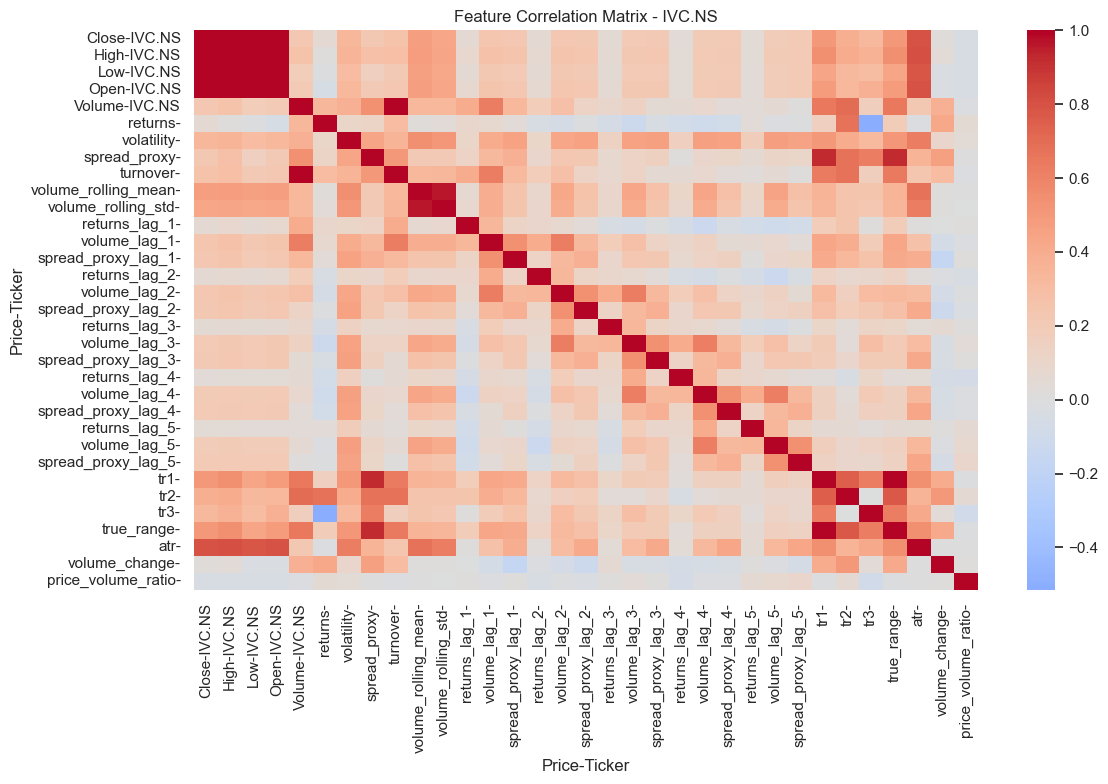


Key Statistics for IVC.NS:


Price,returns,volatility,Volume,spread_proxy,atr
Ticker,,,IVC.NS,,
count,720.0000,720.0000,720.0000,720.0000,720.0000
mean,0.0006,0.0230,552161.9889,0.0437,0.4054
std,0.0265,0.0136,1586610.6561,0.0283,0.1910
min,-0.0975,0.0045,0.0000,0.0000,0.1195
25%,-0.0127,0.0146,176666.7500,0.0257,0.2531
50%,0.0000,0.0195,275410.0000,0.0370,0.3717
75%,0.0108,0.0269,474838.5000,0.0511,0.5128
max,0.1995,0.0894,26717436.0000,0.2047,1.0756


------------------------------------------------------------

2. Features created for RS:
   Shape: (729, 33)
   Date range: 2022-11-28 00:00:00 to 2025-10-27 00:00:00


Price,Close,High,Low,Open,Volume,returns,volatility,spread_proxy,turnover,volume_rolling_mean,volume_rolling_std,returns_lag_1,volume_lag_1,spread_proxy_lag_1,returns_lag_2,volume_lag_2,spread_proxy_lag_2,returns_lag_3,volume_lag_3,spread_proxy_lag_3,returns_lag_4,volume_lag_4,spread_proxy_lag_4,returns_lag_5,volume_lag_5,spread_proxy_lag_5,tr1,tr2,tr3,true_range,atr,volume_change,price_volume_ratio
Ticker,RS,RS,RS,RS,RS,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-28,199.2829,203.4626,199.2638,200.8839,260700,-0.0183,0.0157,0.0211,51953059.4513,378125.0000,155412.1274,0.0008,94400.0000,0.0149,-0.0063,263900.0000,0.0167,0.0220,408900.0000,0.0164,0.0116,347100.0000,0.0269,0.0031,339100.0000,0.0225,4.1989,0.4697,3.7291,4.1989,5.8487,1.7617,-0.0104
2022-11-29,200.5867,204.2583,200.1074,200.6155,239300,0.0065,0.0118,0.0207,48000397.4152,369925.0000,158313.3896,-0.0183,260700.0000,0.0211,0.0008,94400.0000,0.0149,-0.0063,263900.0000,0.0167,0.0220,408900.0000,0.0164,0.0116,347100.0000,0.0269,4.1509,4.9754,0.8244,4.9754,5.9027,-0.0821,-0.0797
2022-11-30,202.5519,202.5519,196.8288,200.9893,403000,0.0098,0.0118,0.0283,81628419.8914,367315.0000,157260.3181,0.0065,239300.0000,0.0207,-0.0183,260700.0000,0.0211,0.0008,94400.0000,0.0149,-0.0063,263900.0000,0.0167,0.0220,408900.0000,0.0164,5.7231,1.9652,3.7579,5.7231,5.9051,0.6841,0.0143
2022-12-01,203.0121,204.2104,200.7592,203.2325,263700,0.0023,0.0116,0.0170,53534278.7567,361390.0000,158893.8305,0.0098,403000.0000,0.0283,0.0065,239300.0000,0.0207,-0.0183,260700.0000,0.0211,0.0008,94400.0000,0.0149,-0.0063,263900.0000,0.0167,3.4511,1.6584,1.7927,3.4511,5.6642,-0.3457,-0.0066
2022-12-02,204.3829,207.7957,201.5837,201.9767,520100,0.0068,0.0108,0.0304,106299548.3978,372160.0000,162116.4279,0.0023,263700.0000,0.0170,0.0098,403000.0000,0.0283,0.0065,239300.0000,0.0207,-0.0183,260700.0000,0.0211,0.0008,94400.0000,0.0149,6.2120,4.7836,1.4284,6.2120,5.0163,0.9723,0.0069


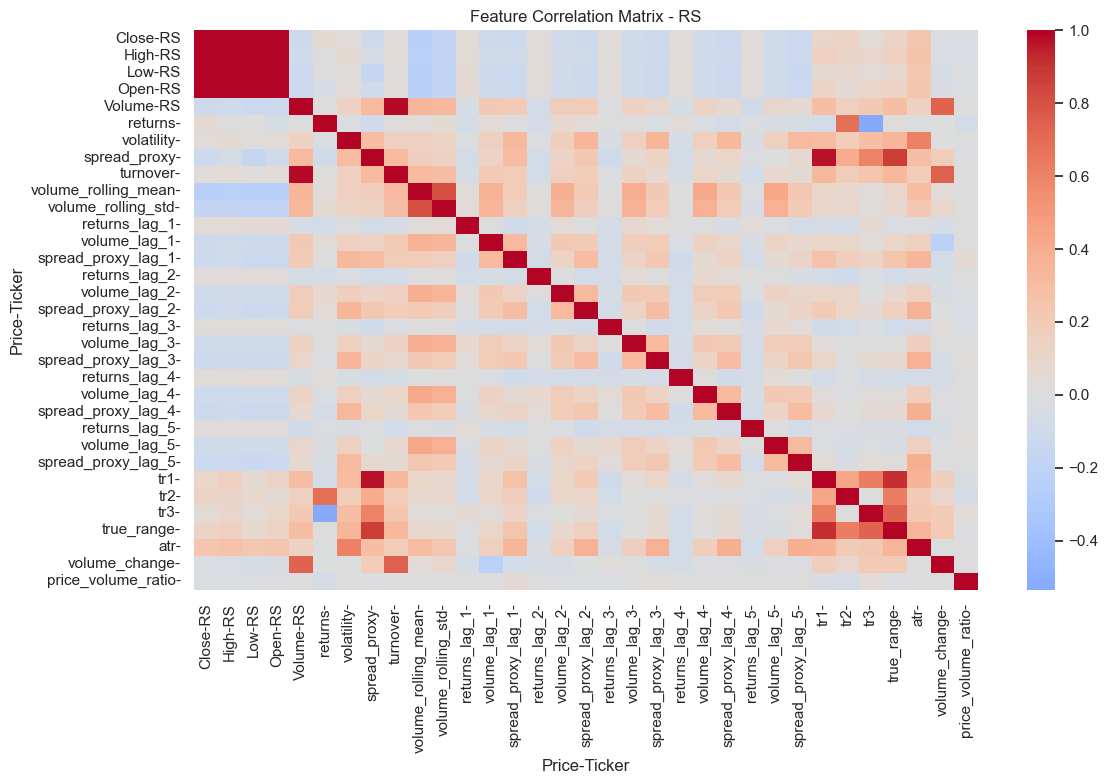


Key Statistics for RS:


Price,returns,volatility,Volume,spread_proxy,atr
Ticker,,,RS,,
count,729.0000,729.0000,729.0000,729.0000,729.0000
mean,0.0005,0.0152,365617.6955,0.0215,6.2516
std,0.0168,0.0074,291162.7578,0.0110,1.5293
min,-0.1232,0.0048,81300.0000,0.0057,3.1862
25%,-0.0085,0.0109,239500.0000,0.0151,5.3534
50%,0.0005,0.0133,309900.0000,0.0191,5.8594
75%,0.0101,0.0170,406600.0000,0.0253,6.9371
max,0.1279,0.0455,4348300.0000,0.1523,13.0786


------------------------------------------------------------

3. Features created for PHARMABEES.NS:
   Shape: (701, 33)
   Date range: 2022-11-28 00:00:00 to 2025-10-28 00:00:00


Price,Close,High,Low,Open,Volume,returns,volatility,spread_proxy,turnover,volume_rolling_mean,volume_rolling_std,returns_lag_1,volume_lag_1,spread_proxy_lag_1,returns_lag_2,volume_lag_2,spread_proxy_lag_2,returns_lag_3,volume_lag_3,spread_proxy_lag_3,returns_lag_4,volume_lag_4,spread_proxy_lag_4,returns_lag_5,volume_lag_5,spread_proxy_lag_5,tr1,tr2,tr3,true_range,atr,volume_change,price_volume_ratio
Ticker,PHARMABEES.NS,PHARMABEES.NS,PHARMABEES.NS,PHARMABEES.NS,PHARMABEES.NS,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-28,13.1100,13.1700,13.0500,13.1100,2917990,0.0023,0.0047,0.0092,38254847.8982,2759670.7000,2402448.0758,0.0046,1586178.0000,0.0092,0.0008,961595.0000,0.0069,0.0031,897413.0000,0.0323,0.0023,2158110.0000,0.0069,-0.0008,2188607.0000,0.0147,0.1200,0.0900,0.0300,0.1200,0.3071,0.8396,0.0027
2022-11-29,13.1900,13.2000,13.1200,13.1500,1152558,0.0061,0.0051,0.0061,15202239.5364,2785379.3500,2381210.6375,0.0023,2917990.0000,0.0092,0.0046,1586178.0000,0.0092,0.0008,961595.0000,0.0069,0.0031,897413.0000,0.0323,0.0023,2158110.0000,0.0069,0.0800,0.0900,0.0100,0.0900,0.2536,-0.6050,-0.0101
2022-11-30,13.2600,13.3000,13.1900,13.1900,1577203,0.0053,0.0050,0.0083,20913712.1410,2743224.4500,2395434.0896,0.0061,1152558.0000,0.0061,0.0023,2917990.0000,0.0092,0.0046,1586178.0000,0.0092,0.0008,961595.0000,0.0069,0.0031,897413.0000,0.0323,0.1100,0.1100,0.0000,0.1100,0.2407,0.3684,0.0144
2022-12-01,13.2500,13.4000,13.2200,13.4000,1445118,-0.0008,0.0048,0.0136,19147813.5000,2742330.6500,2395940.2006,0.0053,1577203.0000,0.0083,0.0061,1152558.0000,0.0061,0.0023,2917990.0000,0.0092,0.0046,1586178.0000,0.0092,0.0008,961595.0000,0.0069,0.1800,0.1400,0.0400,0.1800,0.2250,-0.0837,0.0090
2022-12-02,13.2000,13.4900,13.1100,13.4900,2382290,-0.0038,0.0031,0.0288,31446227.5456,2842296.5000,2333207.1532,-0.0008,1445118.0000,0.0136,0.0053,1577203.0000,0.0083,0.0061,1152558.0000,0.0061,0.0023,2917990.0000,0.0092,0.0046,1586178.0000,0.0092,0.3800,0.2400,0.1400,0.3800,0.2350,0.6485,-0.0058


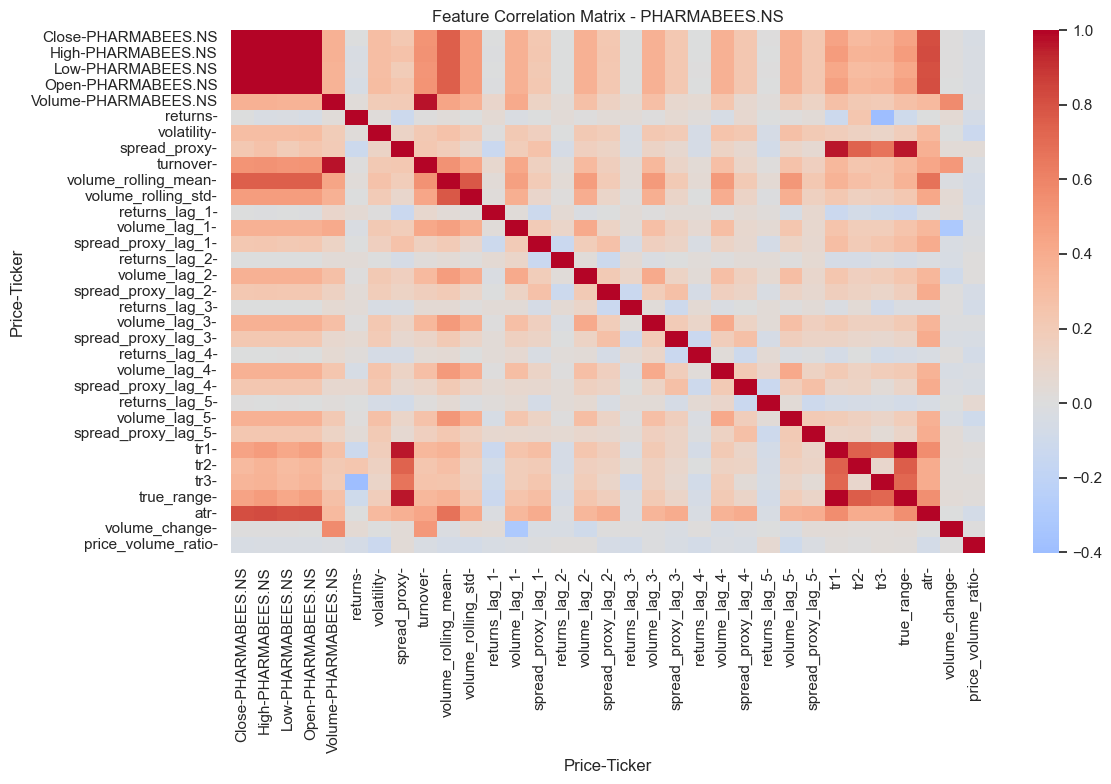


Key Statistics for PHARMABEES.NS:


Price,returns,volatility,Volume,spread_proxy,atr
Ticker,,,PHARMABEES.NS,,
count,701.0000,701.0000,701.0000,701.0000,701.0000
mean,0.0008,0.0084,3534762.3039,0.0241,0.4658
std,0.0090,0.0030,2469648.1732,0.0150,0.1862
min,-0.0393,0.0025,0.0000,0.0031,0.1343
25%,-0.0044,0.0062,1948005.0000,0.0136,0.3043
50%,0.0006,0.0079,2835787.0000,0.0204,0.4679
75%,0.0064,0.0100,4287352.0000,0.0306,0.5864
max,0.0354,0.0209,17522150.0000,0.1228,1.0793


------------------------------------------------------------

4. Features created for CHWY:
   Shape: (731, 33)
   Date range: 2022-11-28 00:00:00 to 2025-10-27 00:00:00


Price,Close,High,Low,Open,Volume,returns,volatility,spread_proxy,turnover,volume_rolling_mean,volume_rolling_std,returns_lag_1,volume_lag_1,spread_proxy_lag_1,returns_lag_2,volume_lag_2,spread_proxy_lag_2,returns_lag_3,volume_lag_3,spread_proxy_lag_3,returns_lag_4,volume_lag_4,spread_proxy_lag_4,returns_lag_5,volume_lag_5,spread_proxy_lag_5,tr1,tr2,tr3,true_range,atr,volume_change,price_volume_ratio
Ticker,CHWY,CHWY,CHWY,CHWY,CHWY,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-28,40.9600,42.6300,40.7000,40.8800,2252800,-0.0058,0.0221,0.0471,92274685.9375,3249930.0000,1373233.9990,-0.0134,755800.0000,0.0272,0.0170,1720600.0000,0.0318,-0.0080,1906500.0000,0.0431,0.0115,3090700.0000,0.0423,-0.0012,2862500.0000,0.0645,1.9300,1.4300,0.5000,1.9300,2.7635,1.9807,-0.0029
2022-11-29,40.2000,41.4200,39.4900,41.2600,2643500,-0.0186,0.0138,0.0480,106268702.0168,3250030.0000,1373187.4327,-0.0058,2252800.0000,0.0471,-0.0134,755800.0000,0.0272,0.0170,1720600.0000,0.0318,-0.0080,1906500.0000,0.0431,0.0115,3090700.0000,0.0423,1.9300,0.4600,1.4700,1.9300,2.7449,0.1734,-0.1070
2022-11-30,43.1300,43.1700,40.3900,41.3900,3061500,0.0729,0.0288,0.0645,132042498.2700,3304720.0000,1340828.1846,-0.0186,2643500.0000,0.0480,-0.0058,2252800.0000,0.0471,-0.0134,755800.0000,0.0272,0.0170,1720600.0000,0.0318,-0.0080,1906500.0000,0.0431,2.7800,2.9700,0.1900,2.9700,2.7314,0.1581,0.4609
2022-12-01,44.3500,44.4700,42.6900,42.6900,2358000,0.0283,0.0294,0.0401,104577296.4020,3257365.0000,1357435.9127,0.0729,3061500.0000,0.0645,-0.0186,2643500.0000,0.0480,-0.0058,2252800.0000,0.0471,-0.0134,755800.0000,0.0272,0.0170,1720600.0000,0.0318,1.7800,1.3400,0.4400,1.7800,2.4049,-0.2298,-0.1231
2022-12-02,44.9200,45.6350,42.4300,42.9400,2750400,0.0129,0.0267,0.0713,123547962.9639,3243165.0000,1361370.8301,0.0283,2358000.0000,0.0401,0.0729,3061500.0000,0.0645,-0.0186,2643500.0000,0.0480,-0.0058,2252800.0000,0.0471,-0.0134,755800.0000,0.0272,3.2050,1.2850,1.9200,3.2050,2.3817,0.1664,0.0772


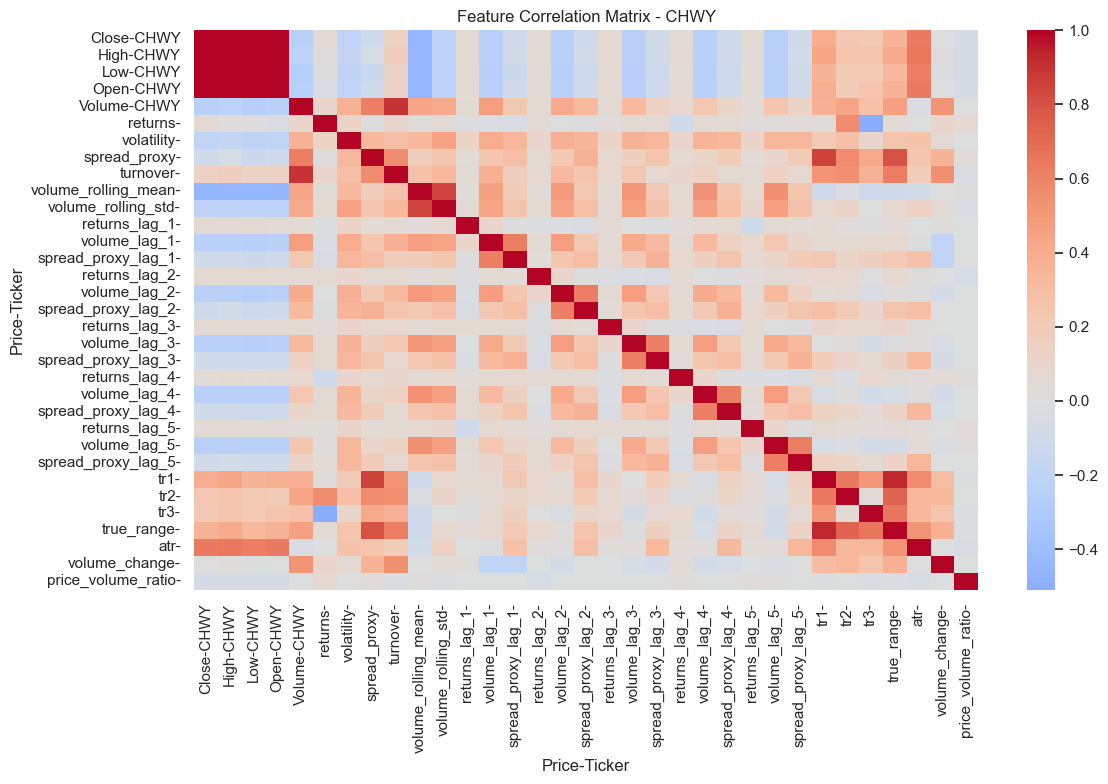


Key Statistics for CHWY:


Price,returns,volatility,Volume,spread_proxy,atr
Ticker,,,CHWY,,
count,731.0000,731.0000,731.0000,731.0000,731.0000
mean,0.0003,0.0312,6872177.2914,0.0451,1.4640
std,0.0340,0.0135,5793007.6379,0.0249,0.5565
min,-0.1660,0.0084,1749500.0000,0.0136,0.6453
25%,-0.0191,0.0219,4110550.0000,0.0307,1.0866
50%,0.0000,0.0288,5440200.0000,0.0395,1.3466
75%,0.0170,0.0376,7814700.0000,0.0528,1.7421
max,0.2714,0.0903,66623100.0000,0.4114,3.2386


------------------------------------------------------------

Total stocks processed: 4
Available tickers: ['IVC.NS', 'RS', 'PHARMABEES.NS', 'CHWY']


In [4]:
# Function to engineer features for liquidity analysis
def engineer_features(df, volatility_window=10, volume_window=20):
    # Create a copy to avoid modifying the original dataframe
    df_features = df.copy()
    
    # Set the date as index for time-series calculations
    if 'Date' in df_features.columns:
        df_features.set_index('Date', inplace=True)
    
    # Remove non-numeric columns before calculations
    # Keep only necessary columns for feature engineering
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    df_features = df_features[numeric_columns]
    
    # Calculate daily returns
    df_features['returns'] = df_features['Close'].pct_change()
    
    # Calculate volatility (rolling std dev of returns)
    df_features['volatility'] = df_features['returns'].rolling(window=volatility_window).std()
    
    # Calculate spread proxy: (High - Low) / Close
    df_features['spread_proxy'] = (df_features['High'] - df_features['Low']) / df_features['Close']
    
    # Calculate turnover: Volume × Close
    df_features['turnover'] = df_features['Volume'] * df_features['Close']
    
    # Create rolling volume metrics
    df_features['volume_rolling_mean'] = df_features['Volume'].rolling(window=volume_window).mean()
    df_features['volume_rolling_std'] = df_features['Volume'].rolling(window=volume_window).std()
    
    # Create lagged features for temporal dependencies
    for lag in range(1, 6):  # Create 5 lags
        df_features[f'returns_lag_{lag}'] = df_features['returns'].shift(lag)
        df_features[f'volume_lag_{lag}'] = df_features['Volume'].shift(lag)
        df_features[f'spread_proxy_lag_{lag}'] = df_features['spread_proxy'].shift(lag)
        
    # Calculate additional technical indicators that might help with liquidity prediction
    
    # Average True Range (ATR) - a measure of volatility
    df_features['tr1'] = abs(df_features['High'] - df_features['Low'])
    df_features['tr2'] = abs(df_features['High'] - df_features['Close'].shift(1))
    df_features['tr3'] = abs(df_features['Low'] - df_features['Close'].shift(1))
    df_features['true_range'] = df_features[['tr1', 'tr2', 'tr3']].max(axis=1)
    df_features['atr'] = df_features['true_range'].rolling(window=14).mean()
    
    # Volume change
    df_features['volume_change'] = df_features['Volume'].pct_change()
    
    # Price-volume relationship
    # Handle division by zero or infinity issues
    df_features['price_volume_ratio'] = df_features['returns'] / df_features['volume_change']
    df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows with NaN values created by rolling windows and lagged features
    df_features.dropna(inplace=True)
    
    return df_features

# Apply feature engineering to all datasets
featured_data = {}
for ticker, df in all_data.items():
    print(f"Engineering features for {ticker}...")
    featured_data[ticker] = engineer_features(df)

# Display feature engineering results for all stocks individually
print("\n" + "="*80)
print("FEATURE ENGINEERING RESULTS FOR ALL STOCKS")
print("="*80)

for i, (ticker, df_featured) in enumerate(featured_data.items(), 1):
    print(f"\n{i}. Features created for {ticker}:")
    print(f"   Shape: {df_featured.shape}")
    print(f"   Date range: {df_featured.index[0]} to {df_featured.index[-1]}")
    
    # Display first few rows for each stock
    display(df_featured.head())
    
    # Display correlation matrix for each stock
    plt.figure(figsize=(12, 8))
    correlation_matrix = df_featured.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, cbar=True)
    plt.title(f'Feature Correlation Matrix - {ticker}')
    plt.tight_layout()
    plt.show()
    
    # Display key statistics
    print(f"\nKey Statistics for {ticker}:")
    key_stats = df_featured[['returns', 'volatility', 'Volume', 'spread_proxy', 'atr']].describe()
    display(key_stats)
    
    print("-" * 60)

print(f"\nTotal stocks processed: {len(featured_data)}")
print("Available tickers:", list(featured_data.keys()))

### 3. Label Construction

we create the target variable - the liquidity shock indicator
- Volatility is above a threshold AND
- Volume is below the rolling mean minus a deviation

Identifying liquidity shocks for IVC.NS...
Identifying liquidity shocks for RS...
Identifying liquidity shocks for PHARMABEES.NS...
Identifying liquidity shocks for CHWY...

LIQUIDITY SHOCK IDENTIFICATION RESULTS FOR ALL STOCKS

1. Liquidity Shock Analysis for IVC.NS:
   Total periods: 720
   Shock periods: 60
   Shock percentage: 8.33%
   Shock type distribution:
     No Shock: 660 (91.7%)
     Volatility Shock: 24 (3.3%)
     Spread Shock: 26 (3.6%)
     Combined Shock: 10 (1.4%)
------------------------------------------------------------

2. Liquidity Shock Analysis for RS:
   Total periods: 729
   Shock periods: 72
   Shock percentage: 9.88%
   Shock type distribution:
     No Shock: 657 (90.1%)
     Volatility Shock: 32 (4.4%)
     Spread Shock: 31 (4.3%)
     Volume Shock: 4 (0.5%)
     Combined Shock: 5 (0.7%)
------------------------------------------------------------

3. Liquidity Shock Analysis for PHARMABEES.NS:
   Total periods: 701
   Shock periods: 56
   Shock percentag

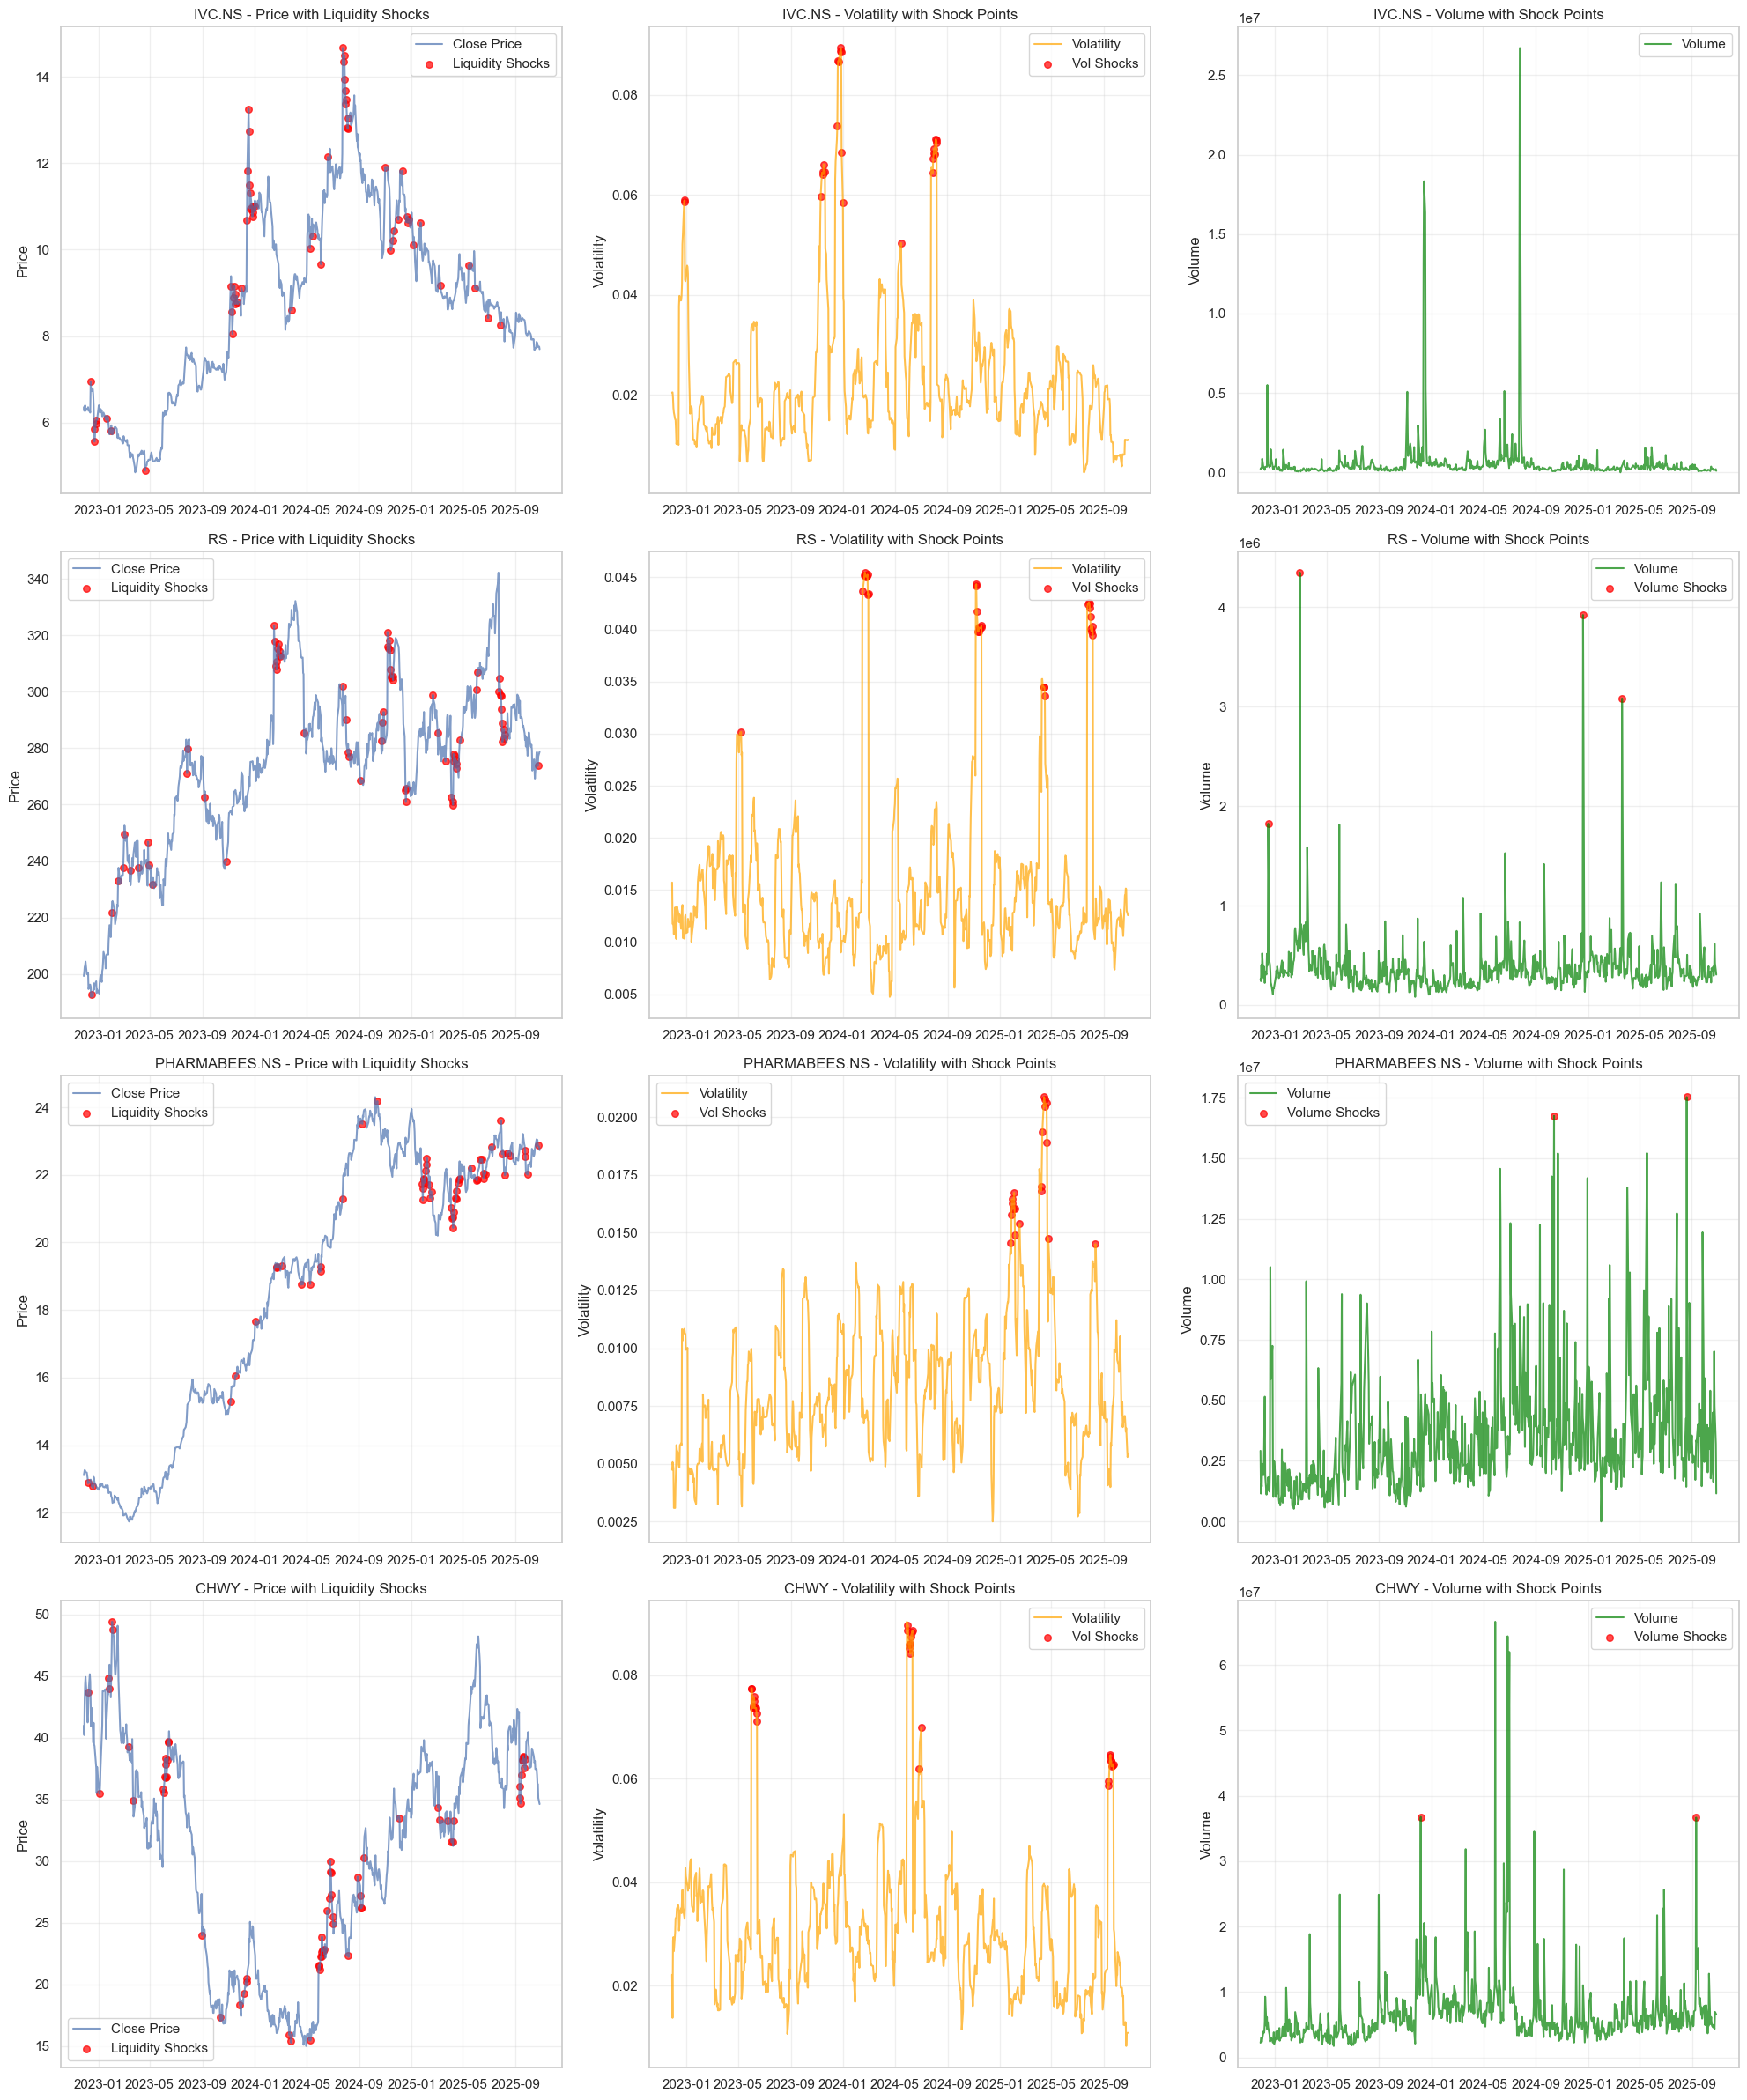


SUMMARY STATISTICS ACROSS ALL STOCKS:


,Ticker,Total_Periods,Shock_Periods,Shock_Percentage,Avg_Volatility,Max_Volatility,Avg_Volume,Max_Volume
0,IVC.NS,720,60,8.3333,0.0230,0.0894,Ticker IVC.NS 552161.9889 dtype: float64,Ticker IVC.NS 26717436 dtype: int64
1,RS,729,72,9.8765,0.0152,0.0455,Ticker RS 365617.6955 dtype: float64,Ticker RS 4348300 dtype: int64
2,PHARMABEES.NS,701,56,7.9886,0.0084,0.0209,Ticker PHARMABEES.NS 3534762.3039 dtype: flo...,Ticker PHARMABEES.NS 17522150 dtype: int64
3,CHWY,731,68,9.3023,0.0312,0.0903,Ticker CHWY 6872177.2914 dtype: float64,Ticker CHWY 66623100 dtype: int64



Total stocks analyzed: 4
All stocks successfully labeled for liquidity shock prediction!


In [5]:
# Define a function to identify liquidity shocks based on multiple criteria
def identify_liquidity_shocks(df_featured, vol_threshold=2, spread_threshold=95, volume_threshold=5):
    df_labeled = df_featured.copy()
    
    # Identify volatility spikes (z-score > threshold)
    volatility_mean = df_labeled['volatility'].mean()
    volatility_std = df_labeled['volatility'].std()
    df_labeled['vol_zscore'] = (df_labeled['volatility'] - volatility_mean) / volatility_std
    
    # Identify spread spikes (percentile-based)
    spread_threshold_value = np.percentile(df_labeled['spread_proxy'], spread_threshold)
    
    # Identify volume spikes (z-score > threshold)
    volume_mean = df_labeled['Volume'].mean()
    volume_std = df_labeled['Volume'].std()
    df_labeled['volume_zscore'] = (df_labeled['Volume'] - volume_mean) / volume_std
    
    # Create liquidity shock indicator (binary classification)
    df_labeled['liquidity_shock'] = (
        (df_labeled['vol_zscore'] > vol_threshold) |
        (df_labeled['spread_proxy'] > spread_threshold_value) |
        (df_labeled['volume_zscore'] > volume_threshold)
    ).astype(int)
    
    # Create multi-class labels for different types of shocks
    df_labeled['shock_type'] = 0  # No shock
    df_labeled.loc[df_labeled['vol_zscore'] > vol_threshold, 'shock_type'] = 1  # Volatility shock
    df_labeled.loc[df_labeled['spread_proxy'] > spread_threshold_value, 'shock_type'] = 2  # Spread shock
    df_labeled.loc[df_labeled['volume_zscore'] > volume_threshold, 'shock_type'] = 3  # Volume shock
    
    # Handle cases where multiple conditions are met (choose the most severe)
    df_labeled.loc[(df_labeled['vol_zscore'] > vol_threshold) & 
                   (df_labeled['spread_proxy'] > spread_threshold_value), 'shock_type'] = 4  # Combined shock
    
    return df_labeled

# Apply labeling to all stocks
labeled_data = {}
for ticker, df_featured in featured_data.items():
    print(f"Identifying liquidity shocks for {ticker}...")
    labeled_data[ticker] = identify_liquidity_shocks(df_featured)

# Display liquidity shock analysis for all stocks individually
print("\n" + "="*80)
print("LIQUIDITY SHOCK IDENTIFICATION RESULTS FOR ALL STOCKS")
print("="*80)

# Create comprehensive visualization for all stocks
fig, axes = plt.subplots(len(labeled_data), 3, figsize=(20, 6*len(labeled_data)))
if len(labeled_data) == 1:
    axes = axes.reshape(1, -1)

for i, (ticker, df_labeled) in enumerate(labeled_data.items()):
    shock_count = df_labeled['liquidity_shock'].sum()
    total_periods = len(df_labeled)
    shock_percentage = (shock_count / total_periods) * 100
    
    print(f"\n{i+1}. Liquidity Shock Analysis for {ticker}:")
    print(f"   Total periods: {total_periods}")
    print(f"   Shock periods: {shock_count}")
    print(f"   Shock percentage: {shock_percentage:.2f}%")
    
    # Distribution of shock types
    shock_type_counts = df_labeled['shock_type'].value_counts().sort_index()
    print(f"   Shock type distribution:")
    shock_labels = ['No Shock', 'Volatility Shock', 'Spread Shock', 'Volume Shock', 'Combined Shock']
    for shock_type, count in shock_type_counts.items():
        if shock_type < len(shock_labels):
            print(f"     {shock_labels[shock_type]}: {count} ({count/total_periods*100:.1f}%)")
    
    # Plot 1: Time series with shock indicators
    axes[i, 0].plot(df_labeled.index, df_labeled['Close'], alpha=0.7, label='Close Price')
    shock_dates = df_labeled[df_labeled['liquidity_shock'] == 1].index
    shock_prices = df_labeled[df_labeled['liquidity_shock'] == 1]['Close']
    axes[i, 0].scatter(shock_dates, shock_prices, color='red', alpha=0.7, s=30, label='Liquidity Shocks')
    axes[i, 0].set_title(f'{ticker} - Price with Liquidity Shocks')
    axes[i, 0].set_ylabel('Price')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Plot 2: Volatility with shock indicators
    axes[i, 1].plot(df_labeled.index, df_labeled['volatility'], alpha=0.7, color='orange', label='Volatility')
    vol_shocks = df_labeled[df_labeled['shock_type'] == 1]
    if not vol_shocks.empty:
        axes[i, 1].scatter(vol_shocks.index, vol_shocks['volatility'], 
                          color='red', alpha=0.7, s=30, label='Vol Shocks')
    axes[i, 1].set_title(f'{ticker} - Volatility with Shock Points')
    axes[i, 1].set_ylabel('Volatility')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    
    # Plot 3: Volume with shock indicators  
    axes[i, 2].plot(df_labeled.index, df_labeled['Volume'], alpha=0.7, color='green', label='Volume')
    vol_shocks = df_labeled[df_labeled['shock_type'] == 3]
    if not vol_shocks.empty:
        axes[i, 2].scatter(vol_shocks.index, vol_shocks['Volume'], 
                          color='red', alpha=0.7, s=30, label='Volume Shocks')
    axes[i, 2].set_title(f'{ticker} - Volume with Shock Points')
    axes[i, 2].set_ylabel('Volume')
    axes[i, 2].legend()
    axes[i, 2].grid(True, alpha=0.3)
    
    print("-" * 60)

plt.tight_layout()
plt.show()

# Summary statistics for all stocks
print("\nSUMMARY STATISTICS ACROSS ALL STOCKS:")
print("=" * 50)

summary_stats = []
for ticker, df_labeled in labeled_data.items():
    stats = {
        'Ticker': ticker,
        'Total_Periods': len(df_labeled),
        'Shock_Periods': df_labeled['liquidity_shock'].sum(),
        'Shock_Percentage': (df_labeled['liquidity_shock'].sum() / len(df_labeled)) * 100,
        'Avg_Volatility': df_labeled['volatility'].mean(),
        'Max_Volatility': df_labeled['volatility'].max(),
        'Avg_Volume': df_labeled['Volume'].mean(),
        'Max_Volume': df_labeled['Volume'].max()
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
display(summary_df)

print(f"\nTotal stocks analyzed: {len(labeled_data)}")
print("All stocks successfully labeled for liquidity shock prediction!")

### Train-Test Split


In [6]:
# Enhanced function to perform time-series aware train-test split
def time_series_train_test_split(X, y, test_size=0.15, random_state=None):
    """
    Perform a time-series aware train-test split.
    
    Args:
        X: Feature dataframe with time index
        y: Target series with time index
        test_size: Proportion of data to use for testing
        random_state: Random state for reproducibility
        
    Returns:
        X_train, X_test, y_train, y_test: Train and test splits
    """
    # Calculate split point based on the index (which should be time-based)
    split_idx = int(len(X) * (1 - test_size))
    
    # Split the data
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    
    print(f"Training data: {X_train.shape[0]} samples ({(1-test_size)*100:.0f}%)")
    print(f"Testing data: {X_test.shape[0]} samples ({test_size*100:.0f}%)")
    print(f"Training period: {X_train.index[0]} to {X_train.index[-1]}")
    print(f"Testing period: {X_test.index[0]} to {X_test.index[-1]}")
    
    return X_train, X_test, y_train, y_test

# Prepare data for each stock individually
print("="*80)
print("PREPARING DATA FOR MACHINE LEARNING - INDIVIDUAL STOCK ANALYSIS")
print("="*80)

# Store prepared data for each stock
stock_data_prepared = {}

for ticker, data in labeled_data.items():
    print(f"\nProcessing {ticker}...")
    
    # Extract features (exclude target columns and helper columns)
    feature_columns = [col for col in data.columns if col not in ['liquidity_shock', 'shock_type', 'vol_zscore', 'volume_zscore']]
    features = data[feature_columns].copy()
    
    # Extract targets - use the columns we actually created
    binary_target = data['liquidity_shock']  # This is our binary target
    multiclass_target = data['shock_type']   # This is our multiclass target
    
    # Handle any infinite or NaN values
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(features.median())
    
    # Perform train-test split for this stock
    X_train, X_test, y_train_binary, y_test_binary = time_series_train_test_split(
        features, binary_target, test_size=0.15
    )
    
    # Same split for multiclass
    _, _, y_train_multiclass, y_test_multiclass = time_series_train_test_split(
        features, multiclass_target, test_size=0.15
    )
    
    # Store prepared data
    stock_data_prepared[ticker] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train_binary': y_train_binary,
        'y_test_binary': y_test_binary,
        'y_train_multiclass': y_train_multiclass,
        'y_test_multiclass': y_test_multiclass,
        'feature_names': list(features.columns)
    }
    
    # Print summary statistics for this stock
    print(f"  Features shape: {features.shape}")
    print(f"  Training samples: {len(X_train)} ({len(X_train)/len(features)*100:.1f}%)")
    print(f"  Testing samples: {len(X_test)} ({len(X_test)/len(features)*100:.1f}%)")
    
    print(f"  Binary Target Distribution (Training):")
    train_dist = y_train_binary.value_counts(normalize=True)
    for value, pct in train_dist.items():
        label = "No Shock" if value == 0 else "Shock"
        print(f"    {label}: {pct:.1%}")
    
    print(f"  Multiclass Target Distribution (Training):")
    multi_dist = y_train_multiclass.value_counts(normalize=True).sort_index()
    shock_labels = ['No Shock', 'Volatility Shock', 'Spread Shock', 'Volume Shock', 'Combined Shock']
    for value, pct in multi_dist.items():
        if value < len(shock_labels):
            print(f"    {shock_labels[value]}: {pct:.1%}")
    
    print("-" * 60)

print(f"\nTotal stocks prepared for modeling: {len(stock_data_prepared)}")

# Also create a combined dataset for comparison
print("\nCreating combined dataset for comparison...")
all_features = []
all_binary_targets = []
all_multiclass_targets = []
all_tickers = []

for ticker, data in labeled_data.items():
    feature_columns = [col for col in data.columns if col not in ['liquidity_shock', 'shock_type', 'vol_zscore', 'volume_zscore']]
    features = data[feature_columns].copy()
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(features.median())
    
    # Add ticker as a feature for the combined model
    features['ticker'] = ticker
    
    all_features.append(features)
    all_binary_targets.append(data['liquidity_shock'])
    all_multiclass_targets.append(data['shock_type'])

# Combine all data
X_combined = pd.concat(all_features, axis=0)
y_binary_combined = pd.concat(all_binary_targets, axis=0)
y_multiclass_combined = pd.concat(all_multiclass_targets, axis=0)

# Convert ticker to dummy variables
X_combined = pd.get_dummies(X_combined, columns=['ticker'], drop_first=True)

# Combined train-test split
X_train_combined, X_test_combined, y_train_binary_combined, y_test_binary_combined = time_series_train_test_split(
    X_combined, y_binary_combined, test_size=0.2
)

_, _, y_train_multiclass_combined, y_test_multiclass_combined = time_series_train_test_split(
    X_combined, y_multiclass_combined, test_size=0.2
)

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Combined training samples: {len(X_train_combined)}")
print(f"Combined testing samples: {len(X_test_combined)}")

print("\nData preparation completed successfully!")


PREPARING DATA FOR MACHINE LEARNING - INDIVIDUAL STOCK ANALYSIS

Processing IVC.NS...
Training data: 612 samples (85%)
Testing data: 108 samples (15%)
Training period: 2022-11-28 00:00:00 to 2025-05-23 00:00:00
Testing period: 2025-05-26 00:00:00 to 2025-10-28 00:00:00
Training data: 612 samples (85%)
Testing data: 108 samples (15%)
Training period: 2022-11-28 00:00:00 to 2025-05-23 00:00:00
Testing period: 2025-05-26 00:00:00 to 2025-10-28 00:00:00
  Features shape: (720, 37)
  Training samples: 612 (85.0%)
  Testing samples: 108 (15.0%)
  Binary Target Distribution (Training):
    No Shock: 90.7%
    Shock: 9.3%
  Multiclass Target Distribution (Training):
    No Shock: 90.7%
    Volatility Shock: 3.9%
    Spread Shock: 3.8%
    Combined Shock: 1.6%
------------------------------------------------------------

Processing RS...
Training data: 619 samples (85%)
Testing data: 110 samples (15%)
Training period: 2022-11-28 00:00:00 to 2025-05-20 00:00:00
Testing period: 2025-05-21 00:00:0

## Model Implementation and Evaluation


1. Deep Learning Models:
   - LSTM (Long Short-Term Memory)
   - Fuzzy Time Series
   - GRU (Gated Recurrent Unit)

2. Advanced Ensemble:
   - Weighted combination of all three models

### Deep Learning Models

#### LSTM 

TRAINING LSTM FOR LIQUIDITY SHOCK PREDICTION
DEEP LEARNING TIME SERIES MODEL WITH CLASS IMBALANCE HANDLING
[CONFIG] Class Imbalance Strategy: Computed class weights (balanced)

==================== LSTM TRAINING FOR IVC.NS ====================
Training set size: (612, 37)
Test set size: (108, 37)
Training period: 2022-11-28 to 2025-05-23
Test period: 2025-05-26 to 2025-10-28
Training distribution: Normal=555, Shock=57
Test distribution: Normal=105, Shock=3
Class imbalance ratio: 9.74:1

[TRAINING] LSTM Model...
   Created 602 training sequences and 98 test sequences
   Class weights: {0: 0.5522935779816514, 1: 5.280701754385965}
   Applying class weights to handle imbalance ratio of 9.74:1
   Training LSTM with class weights (this may take a moment)...
   Training completed in 33 epochs

   [RESULTS] Training Results:
      Accuracy: 0.940
      F1 Score: 0.936

   [RESULTS] Test Results:
      Accuracy: 0.980
      Precision: 0.960
      Recall: 0.980
      F1 Score: 0.969
      ROC-A

,Ticker,Model,Train_Accuracy,Train_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Sequences_Train,Sequences_Test
0,IVC.NS,LSTM,0.9402,0.9358,0.9796,0.9596,0.9796,0.9695,0.2656,602,98
1,RS,LSTM,0.9097,0.9147,0.9300,0.9400,0.9300,0.9336,0.9336,609,100
2,PHARMABEES.NS,LSTM,0.9350,0.9037,0.8438,0.7119,0.8438,0.7722,0.5185,585,96
3,CHWY,LSTM,0.9002,0.9075,0.9200,0.9265,0.9200,0.8950,0.9400,611,100



[RANKING] BEST PERFORMING STOCKS (by Test F1 Score):
--------------------------------------------------
IVC.NS         : Test F1=0.969, ROC-AUC=0.266, Accuracy=0.980
RS             : Test F1=0.934, ROC-AUC=0.934, Accuracy=0.930
CHWY           : Test F1=0.895, ROC-AUC=0.940, Accuracy=0.920
PHARMABEES.NS  : Test F1=0.772, ROC-AUC=0.519, Accuracy=0.844


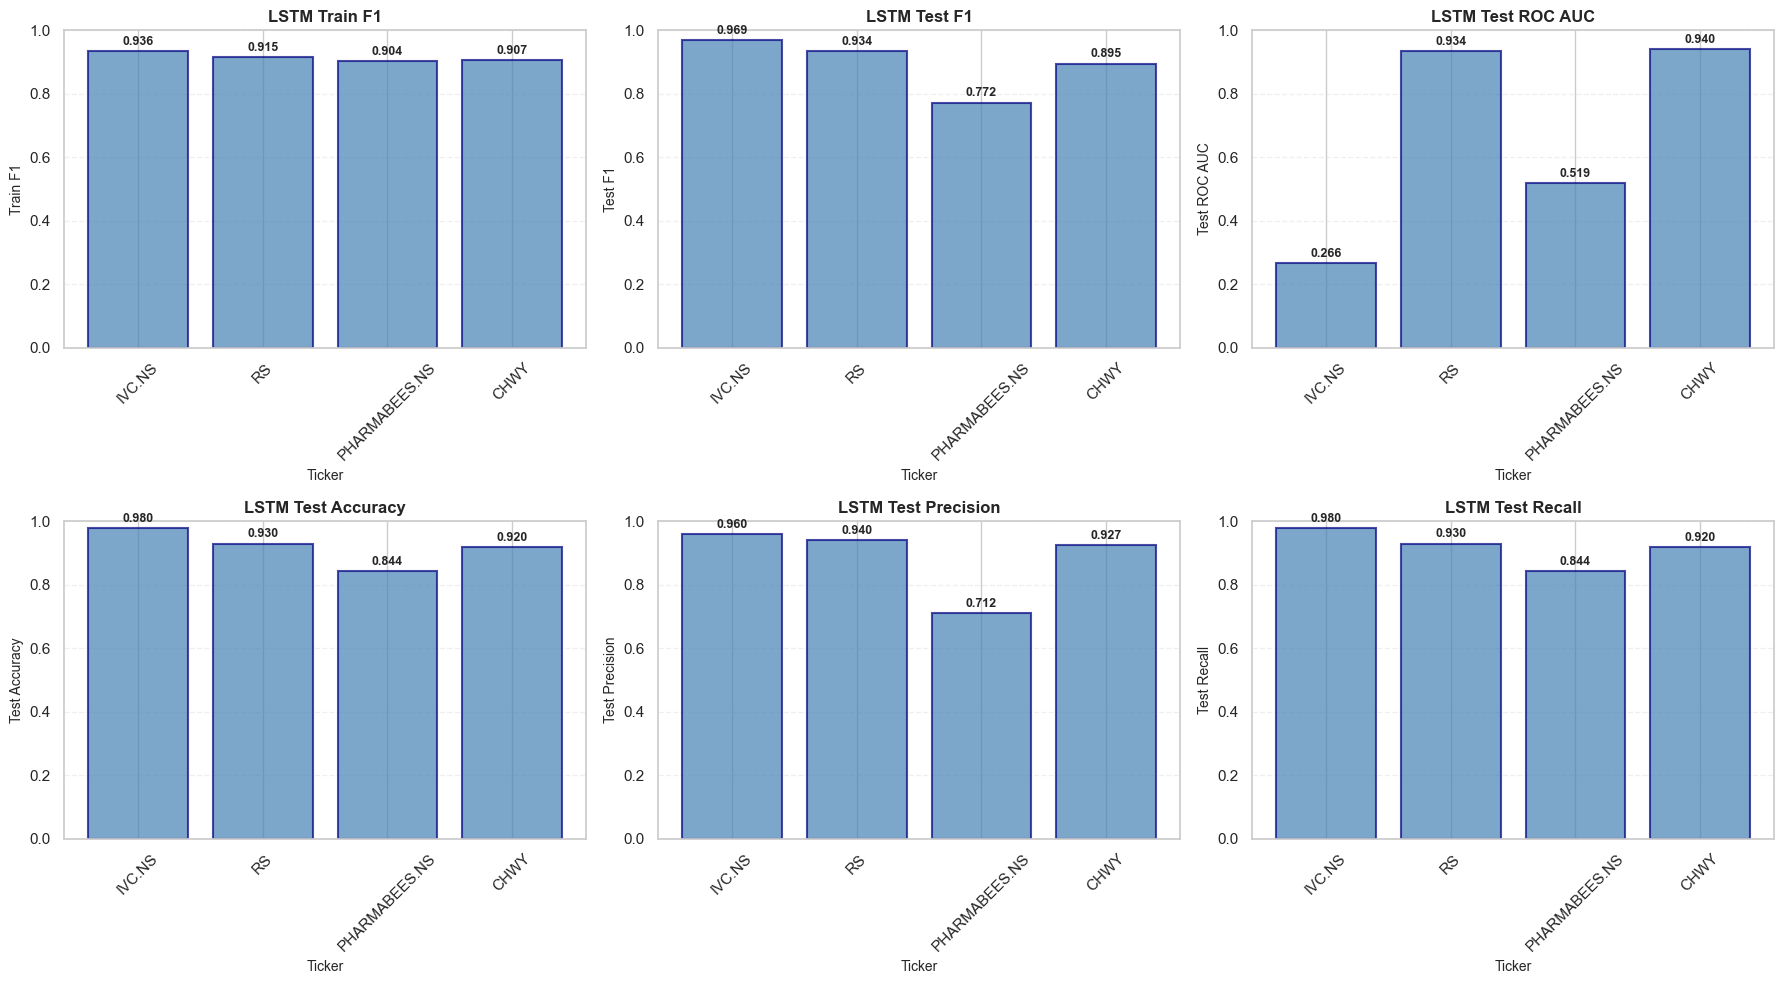


LSTM MODEL SUMMARY STATISTICS


,Train_Accuracy,Train_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC
count,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000
mean,0.9213,0.9154,0.9183,0.8845,0.9183,0.8926,0.6644
std,0.0194,0.0143,0.0561,0.1159,0.0561,0.0858,0.3310
min,0.9002,0.9037,0.8438,0.7119,0.8438,0.7722,0.2656
25%,0.9073,0.9065,0.9009,0.8729,0.9009,0.8643,0.4553
50%,0.9224,0.9111,0.9250,0.9333,0.9250,0.9143,0.7261
75%,0.9363,0.9199,0.9424,0.9449,0.9424,0.9426,0.9352
max,0.9402,0.9358,0.9796,0.9596,0.9796,0.9695,0.9400



TRAINING VS TEST PERFORMANCE


,Ticker,Train_Accuracy,Test_Accuracy,Train_F1,Test_F1,Accuracy_Diff,F1_Diff
0,IVC.NS,0.9402,0.9796,0.9358,0.9695,-0.0394,-0.0337
1,RS,0.9097,0.9300,0.9147,0.9336,-0.0203,-0.0189
2,PHARMABEES.NS,0.9350,0.8438,0.9037,0.7722,0.0913,0.1314
3,CHWY,0.9002,0.9200,0.9075,0.8950,-0.0198,0.0125



[ANALYSIS] Overfitting Analysis:
   Average Train-Test Accuracy Gap: 0.003
   Average Train-Test F1 Gap: 0.023
   [SUCCESS] Model shows good generalization

[SUCCESS] Successfully trained LSTM models for 4 stocks!
[INFO] LSTM: Deep learning time series model with 10-step sequence processing
[METRICS] Average Test Performance: F1=0.893, ROC-AUC=0.664


In [ ]:
# Deep Learning LSTM Model for Financial Time Series
print("="*80)
print("TRAINING LSTM FOR LIQUIDITY SHOCK PREDICTION")
print("DEEP LEARNING TIME SERIES MODEL WITH CLASS IMBALANCE HANDLING")
print("="*80)
print("Class Imbalance Strategy: Computed class weights (balanced)")
print("="*80)

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import TensorFlow for LSTM
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_sequences(X, y, sequence_length=10):
    """
    Create sequences for LSTM training
    """
    X_seq, y_seq = [], []
    
    # Convert to numpy arrays for reliable indexing
    X_array = X.values if isinstance(X, pd.DataFrame) else X
    y_array = y.values if isinstance(y, pd.Series) else np.array(y)
    
    # Ensure y_array is 1D
    if y_array.ndim > 1:
        y_array = y_array.flatten()
    
    # Create sequences using array indexing
    for i in range(sequence_length, len(X_array)):
        X_seq.append(X_array[i-sequence_length:i])
        y_seq.append(y_array[i])
    
    if len(X_seq) == 0:
        return np.array([]), np.array([])
    
    return np.array(X_seq), np.array(y_seq)

def create_lstm_model(input_shape):
    """
    Create LSTM model architecture
    """
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

# Store results for all stocks
all_results = {}
model_performance = []

# Parameters
sequence_length = 10

# Train LSTM model for each stock individually
for ticker in stock_data_prepared.keys():
    print(f"\n{'='*20} LSTM TRAINING FOR {ticker} {'='*20}")
    
    # Get data for this stock
    stock_data = stock_data_prepared[ticker]
    X_train = stock_data['X_train']
    X_test = stock_data['X_test']
    y_train_binary = stock_data['y_train_binary']
    y_test_binary = stock_data['y_test_binary']
    
    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    print(f"Training period: {X_train.index.min().date()} to {X_train.index.max().date()}")
    print(f"Test period: {X_test.index.min().date()} to {X_test.index.max().date()}")
    
    # Analyze class distribution
    train_dist = y_train_binary.value_counts().sort_index()
    test_dist = y_test_binary.value_counts().sort_index()
    
    print(f"Training distribution: Normal={train_dist.get(0, 0)}, Shock={train_dist.get(1, 0)}")
    print(f"Test distribution: Normal={test_dist.get(0, 0)}, Shock={test_dist.get(1, 0)}")
    
    # Skip if we don't have both classes in training set
    if len(train_dist) < 2:
        print(f"[WARNING] Only one class present in training data for {ticker}. Skipping...")
        continue
    
    # Calculate class imbalance ratio
    minority_class = train_dist.min()
    majority_class = train_dist.max()
    imbalance_ratio = majority_class / minority_class if minority_class > 0 else float('inf')
    
    print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")
    
    all_results[ticker] = {}
    
    # LSTM Training
    print(f"\n[TRAINING] LSTM Model...")
    
    try:
        # Scale features for LSTM
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), 
            index=X_train.index, 
            columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test), 
            index=X_test.index, 
            columns=X_test.columns
        )
        
        # Create sequences for training and testing
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_binary, sequence_length)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_binary, sequence_length)
        
        if len(X_train_seq) > 0 and len(X_test_seq) > 0:
            print(f"   Created {len(X_train_seq)} training sequences and {len(X_test_seq)} test sequences")
            
            # Calculate class weights to handle imbalance
            from sklearn.utils.class_weight import compute_class_weight
            classes = np.unique(y_train_seq)
            class_weights_array = compute_class_weight('balanced', classes=classes, y=y_train_seq)
            class_weights = {int(classes[i]): class_weights_array[i] for i in range(len(classes))}
            
            print(f"   Class weights: {class_weights}")
            print(f"   Applying class weights to handle imbalance ratio of {imbalance_ratio:.2f}:1")
            
            # Create LSTM model
            lstm_model = create_lstm_model((sequence_length, X_train_seq.shape[2]))
            
            # Train model with early stopping
            early_stopping = EarlyStopping(
                monitor='val_loss', 
                patience=20, 
                restore_best_weights=True,
                verbose=0
            )
            
            # Train the model with class weights
            print(f"   Training LSTM with class weights (this may take a moment)...")
            history = lstm_model.fit(
                X_train_seq, y_train_seq, 
                epochs=150, 
                batch_size=16, 
                verbose=0, 
                callbacks=[early_stopping],
                validation_split=0.2,
                class_weight=class_weights  # Added class weights
            )
            
            print(f"   Training completed in {len(history.history['loss'])} epochs")
            
            # Make predictions
            y_pred_prob_lstm = lstm_model.predict(X_test_seq, verbose=0)
            y_pred_test_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten()
            
            # Also get training predictions
            y_pred_prob_train = lstm_model.predict(X_train_seq, verbose=0)
            y_pred_train_lstm = (y_pred_prob_train > 0.5).astype(int).flatten()
            
            # Calculate training metrics
            train_accuracy_lstm = accuracy_score(y_train_seq, y_pred_train_lstm)
            train_precision_lstm = precision_score(y_train_seq, y_pred_train_lstm, average='weighted', zero_division=0)
            train_recall_lstm = recall_score(y_train_seq, y_pred_train_lstm, average='weighted', zero_division=0)
            train_f1_lstm = f1_score(y_train_seq, y_pred_train_lstm, average='weighted', zero_division=0)
            
            # Calculate test metrics
            test_accuracy_lstm = accuracy_score(y_test_seq, y_pred_test_lstm)
            test_precision_lstm = precision_score(y_test_seq, y_pred_test_lstm, average='weighted', zero_division=0)
            test_recall_lstm = recall_score(y_test_seq, y_pred_test_lstm, average='weighted', zero_division=0)
            test_f1_lstm = f1_score(y_test_seq, y_pred_test_lstm, average='weighted', zero_division=0)
            
            # ROC AUC
            try:
                if len(np.unique(y_test_seq)) > 1:
                    test_roc_auc_lstm = roc_auc_score(y_test_seq, y_pred_prob_lstm.flatten())
                else:
                    test_roc_auc_lstm = 0.5
            except:
                test_roc_auc_lstm = 0.5
            
            # Store results
            all_results[ticker]['LSTM'] = {
                'model': lstm_model,
                'scaler': scaler,
                'sequence_length': sequence_length,
                'train_accuracy': train_accuracy_lstm,
                'train_precision': train_precision_lstm,
                'train_recall': train_recall_lstm,
                'train_f1': train_f1_lstm,
                'test_accuracy': test_accuracy_lstm,
                'test_precision': test_precision_lstm,
                'test_recall': test_recall_lstm,
                'test_f1': test_f1_lstm,
                'test_roc_auc': test_roc_auc_lstm,
                'predictions': y_pred_test_lstm,
                'probabilities': y_pred_prob_lstm,
                'training_history': history.history
            }
            
            model_performance.append({
                'Ticker': ticker,
                'Model': 'LSTM',
                'Train_Accuracy': train_accuracy_lstm,
                'Train_F1': train_f1_lstm,
                'Test_Accuracy': test_accuracy_lstm,
                'Test_Precision': test_precision_lstm,
                'Test_Recall': test_recall_lstm,
                'Test_F1': test_f1_lstm,
                'Test_ROC_AUC': test_roc_auc_lstm,
                'Sequences_Train': len(X_train_seq),
                'Sequences_Test': len(X_test_seq)
            })
            
            print(f"\n   [RESULTS] Training Results:")
            print(f"      Accuracy: {train_accuracy_lstm:.3f}")
            print(f"      F1 Score: {train_f1_lstm:.3f}")
            
            print(f"\n   [RESULTS] Test Results:")
            print(f"      Accuracy: {test_accuracy_lstm:.3f}")
            print(f"      Precision: {test_precision_lstm:.3f}")
            print(f"      Recall: {test_recall_lstm:.3f}")
            print(f"      F1 Score: {test_f1_lstm:.3f}")
            print(f"      ROC-AUC: {test_roc_auc_lstm:.3f}")
            
            # Classification Report
            print(f"\n   [REPORT] Classification Report (Test):")
            target_names = ['Normal', 'Liquidity Shock']
            # Only show classification report if we have both classes in predictions
            unique_preds = np.unique(y_pred_test_lstm)
            if len(unique_preds) > 1:
                print(classification_report(y_test_seq, y_pred_test_lstm, target_names=target_names, zero_division=0))
            else:
                print(f"      Only one class predicted: {target_names[unique_preds[0]]}")
                print(f"      Accuracy: {test_accuracy_lstm:.3f}")
        
        else:
            print(f"   [WARNING] Insufficient data for LSTM sequence creation")
    
    except Exception as e:
        print(f"   [ERROR] LSTM training failed for {ticker}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue
    
    print("-" * 60)

# Performance Summary
print(f"\n{'='*80}")
print("LSTM MODEL PERFORMANCE SUMMARY")
print("="*80)

if model_performance:
    performance_df = pd.DataFrame(model_performance)
    display(performance_df)
    
    # Best performing ticker
    print(f"\n[RANKING] BEST PERFORMING STOCKS (by Test F1 Score):")
    print("-" * 50)
    best_performers = performance_df.nlargest(len(performance_df), 'Test_F1')
    for idx, row in best_performers.iterrows():
        print(f"{row['Ticker']:15s}: Test F1={row['Test_F1']:.3f}, ROC-AUC={row['Test_ROC_AUC']:.3f}, Accuracy={row['Test_Accuracy']:.3f}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    metrics = ['Train_F1', 'Test_F1', 'Test_ROC_AUC', 'Test_Accuracy', 'Test_Precision', 'Test_Recall']
    
    for i, metric in enumerate(metrics):
        row, col = divmod(i, 3)
        ax = axes[row, col]
        
        # Bar plot for each ticker
        bars = ax.bar(performance_df['Ticker'], performance_df[metric], 
                     color='steelblue', alpha=0.7, edgecolor='navy', linewidth=1.5)
        
        # Add value labels on bars
        for bar, value in zip(bars, performance_df[metric]):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_title(f'LSTM {metric.replace("_", " ")}', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric.replace('_', ' '), fontsize=10)
        ax.set_xlabel('Ticker', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim(0, min(1.0, performance_df[metric].max() * 1.15))
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("LSTM MODEL SUMMARY STATISTICS")
    print("="*60)
    
    summary_cols = ['Train_Accuracy', 'Train_F1', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC']
    summary_stats = performance_df[summary_cols].describe()
    display(summary_stats)
    
    # Training vs Test Performance Comparison
    print(f"\n{'='*60}")
    print("TRAINING VS TEST PERFORMANCE")
    print("="*60)
    
    comparison_df = performance_df[['Ticker', 'Train_Accuracy', 'Test_Accuracy', 'Train_F1', 'Test_F1']].copy()
    comparison_df['Accuracy_Diff'] = comparison_df['Train_Accuracy'] - comparison_df['Test_Accuracy']
    comparison_df['F1_Diff'] = comparison_df['Train_F1'] - comparison_df['Test_F1']
    display(comparison_df)
    
    # Check for overfitting
    print(f"\n[ANALYSIS] Overfitting Analysis:")
    avg_acc_diff = comparison_df['Accuracy_Diff'].mean()
    avg_f1_diff = comparison_df['F1_Diff'].mean()
    print(f"   Average Train-Test Accuracy Gap: {avg_acc_diff:.3f}")
    print(f"   Average Train-Test F1 Gap: {avg_f1_diff:.3f}")
    
    if avg_acc_diff > 0.1 or avg_f1_diff > 0.1:
        print(f"   [WARNING] Possible overfitting detected (gap > 0.1)")
    else:
        print(f"   [SUCCESS] Model shows good generalization")
    
    print(f"\n[SUCCESS] Successfully trained LSTM models for {len(performance_df)} stocks!")
    print(f"[INFO] LSTM: Deep learning time series model with {sequence_length}-step sequence processing")
    print(f"[METRICS] Average Test Performance: F1={performance_df['Test_F1'].mean():.3f}, ROC-AUC={performance_df['Test_ROC_AUC'].mean():.3f}")
    
else:
    print("[WARNING] No LSTM models were successfully trained. Check your data.")

print("="*80)

#### Fuzzy Time Series Model

TRAINING FUZZY TIME SERIES FOR LIQUIDITY SHOCK PREDICTION
FUZZY LOGIC + TIME SERIES HYBRID MODEL

[CONFIG] Fuzzy Time Series Configuration:
         Number of fuzzy partitions: 5
         Model order: 1 (considers previous observation)
         Fuzzy rules: Volatility + Volume + Spread combined

==================== FUZZY TIME SERIES FOR IVC.NS ====================
Training set size: (612, 37)
Test set size: (108, 37)

[TRAINING] Training Fuzzy Time Series Model...
           [SUCCESS] Fuzzy Time Series model trained successfully
           Fuzzy partitions: 5
           Fuzzy rules learned: 5

           [METRICS] Volatility Forecast Metrics:
                     RMSE: 0.006632
                     MAE: 0.005940

[INFERENCE] Creating Fuzzy Inference System for Shock Detection...

           [METRICS] Classification Metrics:
                     Train Accuracy: 0.925
                     Train F1: 0.918
                     Test Accuracy: 0.972
                     Test Precision: 0.94

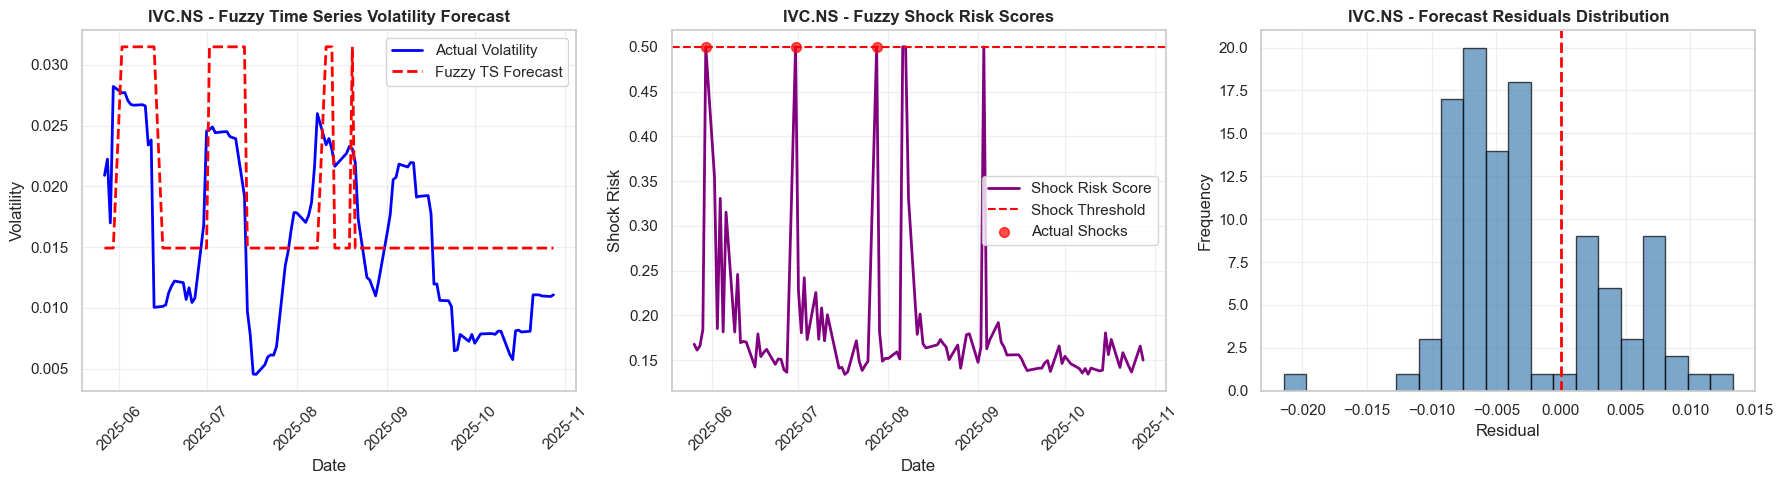

------------------------------------------------------------

==================== FUZZY TIME SERIES FOR RS ====================
Training set size: (619, 37)
Test set size: (110, 37)

[TRAINING] Training Fuzzy Time Series Model...
           [SUCCESS] Fuzzy Time Series model trained successfully
           Fuzzy partitions: 5
           Fuzzy rules learned: 5

           [METRICS] Volatility Forecast Metrics:
                     RMSE: 0.005138
                     MAE: 0.003142

[INFERENCE] Creating Fuzzy Inference System for Shock Detection...

           [METRICS] Classification Metrics:
                     Train Accuracy: 0.905
                     Train F1: 0.897
                     Test Accuracy: 0.927
                     Test Precision: 0.921
                     Test Recall: 0.927
                     Test F1 Score: 0.921
                     Test ROC-AUC: 0.977


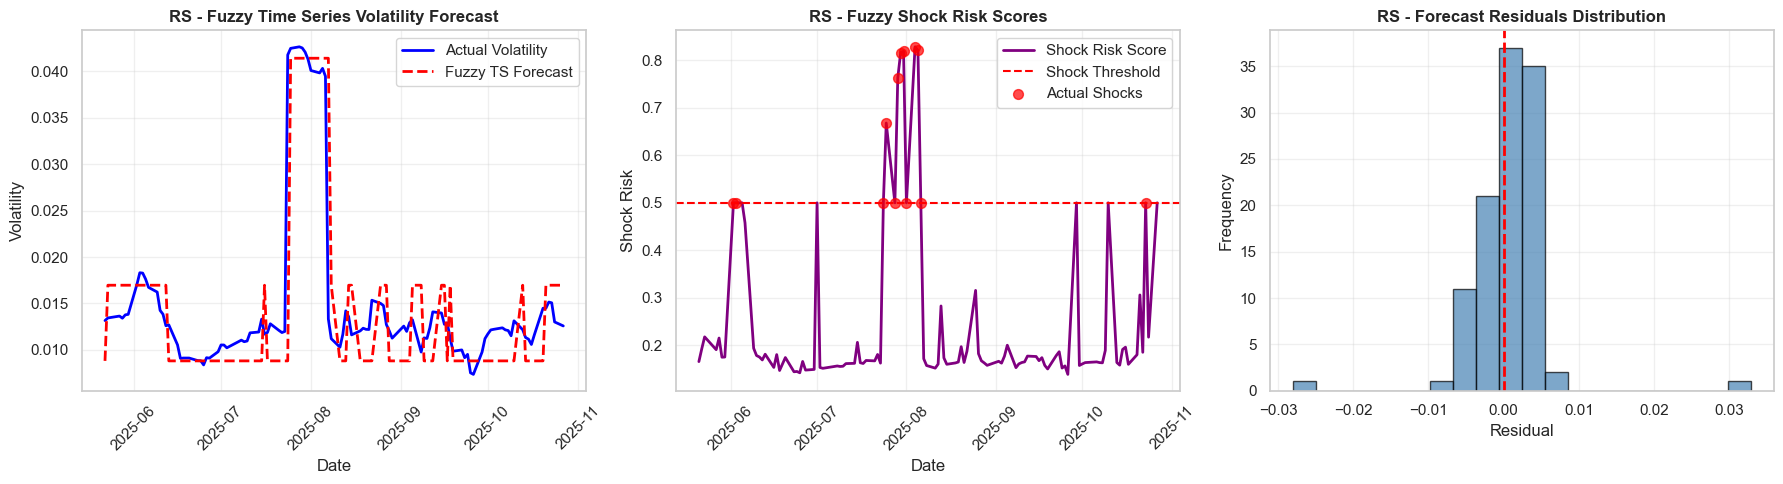

------------------------------------------------------------

==================== FUZZY TIME SERIES FOR PHARMABEES.NS ====================
Training set size: (595, 37)
Test set size: (106, 37)

[TRAINING] Training Fuzzy Time Series Model...
           [SUCCESS] Fuzzy Time Series model trained successfully
           Fuzzy partitions: 5
           Fuzzy rules learned: 5

           [METRICS] Volatility Forecast Metrics:
                     RMSE: 0.001721
                     MAE: 0.001368

[INFERENCE] Creating Fuzzy Inference System for Shock Detection...

           [METRICS] Classification Metrics:
                     Train Accuracy: 0.911
                     Train F1: 0.917
                     Test Accuracy: 0.783
                     Test Precision: 0.741
                     Test Recall: 0.783
                     Test F1 Score: 0.759
                     Test ROC-AUC: 0.646


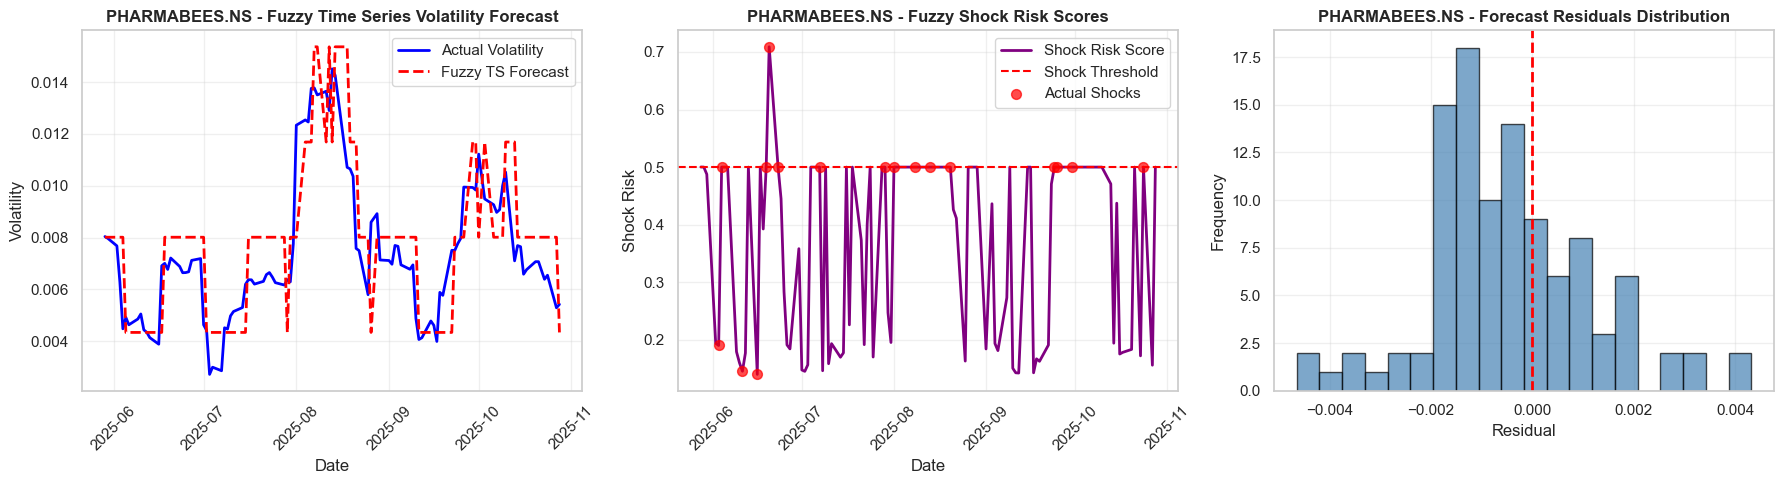

------------------------------------------------------------

==================== FUZZY TIME SERIES FOR CHWY ====================
Training set size: (621, 37)
Test set size: (110, 37)

[TRAINING] Training Fuzzy Time Series Model...
           [SUCCESS] Fuzzy Time Series model trained successfully
           Fuzzy partitions: 5
           Fuzzy rules learned: 5

           [METRICS] Volatility Forecast Metrics:
                     RMSE: 0.007536
                     MAE: 0.004598

[INFERENCE] Creating Fuzzy Inference System for Shock Detection...

           [METRICS] Classification Metrics:
                     Train Accuracy: 0.890
                     Train F1: 0.886
                     Test Accuracy: 0.891
                     Test Precision: 0.855
                     Test Recall: 0.891
                     Test F1 Score: 0.869
                     Test ROC-AUC: 0.920


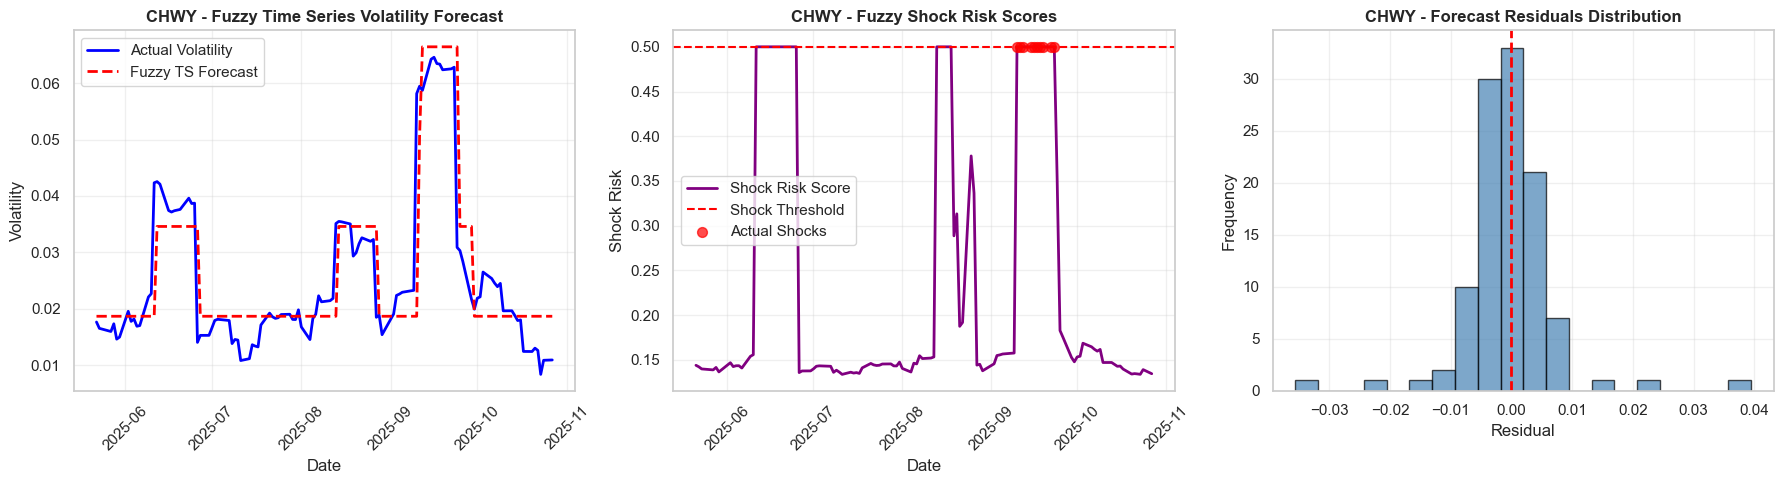

------------------------------------------------------------

FUZZY TIME SERIES MODEL PERFORMANCE SUMMARY


,Ticker,Model,Train_Accuracy,Train_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,RMSE,MAE
0,IVC.NS,Fuzzy TS,0.9248,0.9184,0.9722,0.9452,0.9722,0.9585,0.9857,0.0066,0.0059
1,RS,Fuzzy TS,0.9047,0.8974,0.9273,0.9214,0.9273,0.9214,0.9766,0.0051,0.0031
2,PHARMABEES.NS,Fuzzy TS,0.9109,0.9175,0.7830,0.7405,0.7830,0.7590,0.6461,0.0017,0.0014
3,CHWY,Fuzzy TS,0.8905,0.8858,0.8909,0.8546,0.8909,0.8691,0.9200,0.0075,0.0046



[RANKING] BEST PERFORMING STOCKS (by Test F1 Score):
--------------------------------------------------
IVC.NS         : Test F1=0.959, ROC-AUC=0.986, RMSE=0.006632
RS             : Test F1=0.921, ROC-AUC=0.977, RMSE=0.005138
CHWY           : Test F1=0.869, ROC-AUC=0.920, RMSE=0.007536
PHARMABEES.NS  : Test F1=0.759, ROC-AUC=0.646, RMSE=0.001721


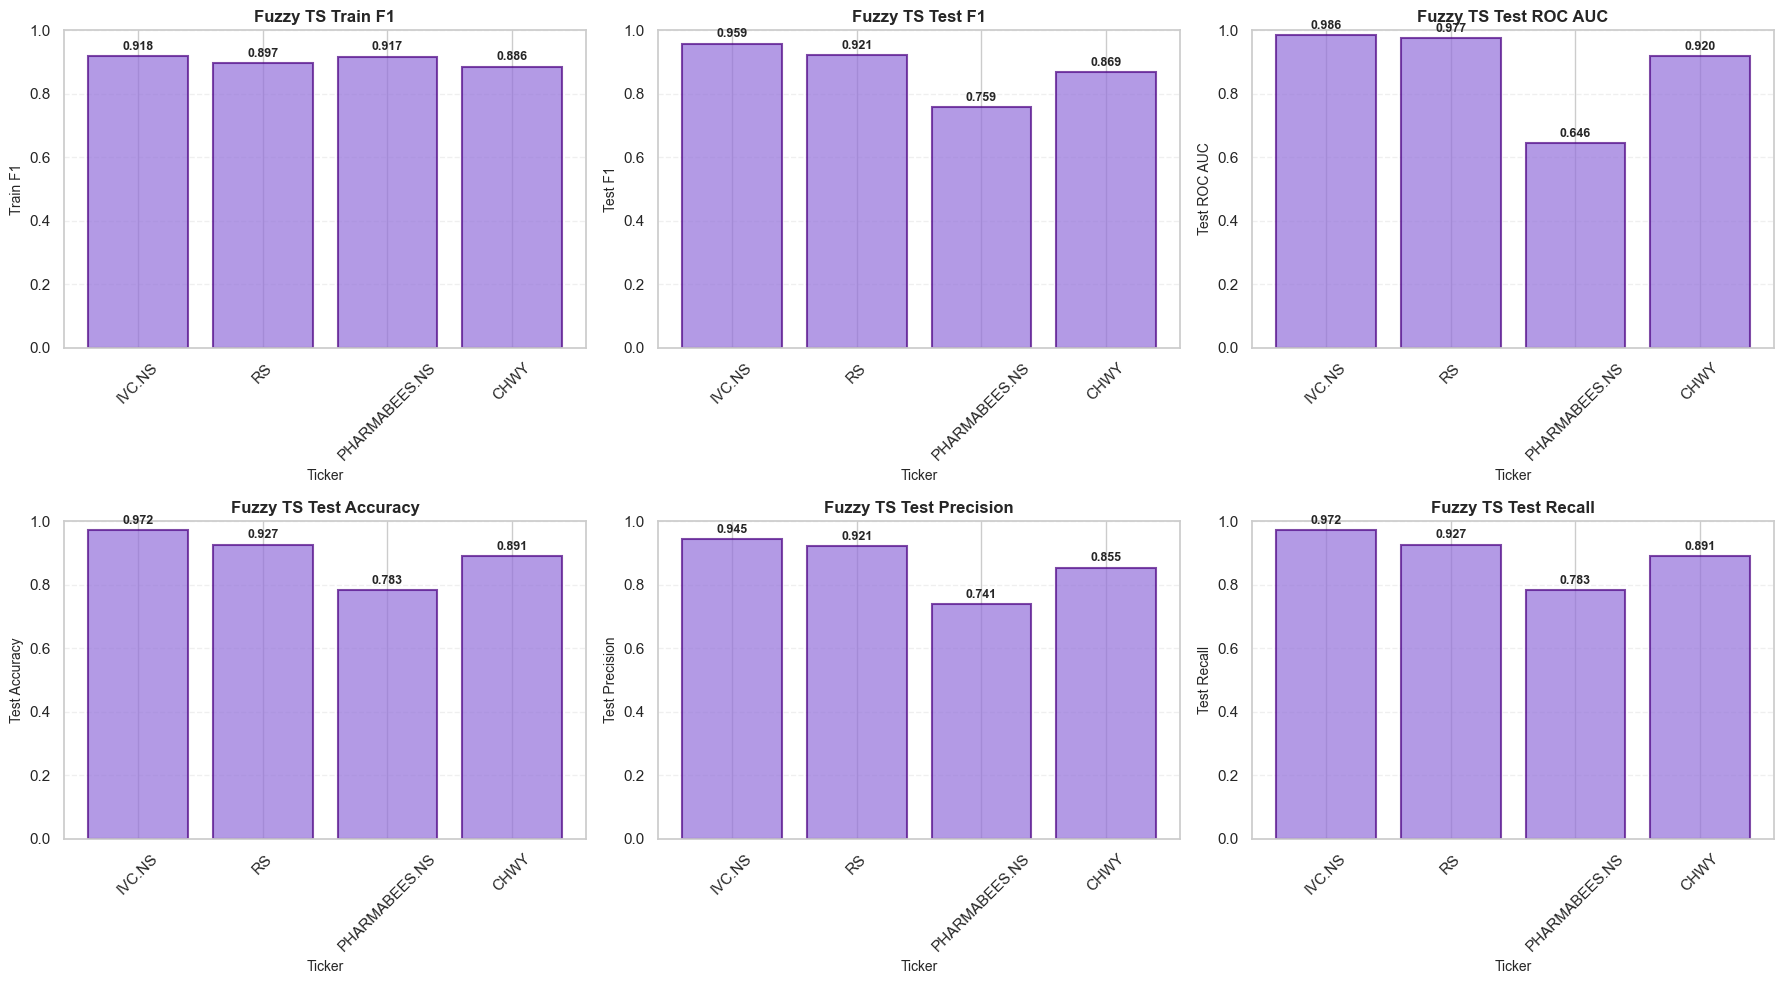


FUZZY TIME SERIES SUMMARY STATISTICS


,Train_Accuracy,Train_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC
count,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000
mean,0.9077,0.9048,0.8934,0.8654,0.8934,0.8770,0.8821
std,0.0142,0.0159,0.0807,0.0917,0.0807,0.0868,0.1600
min,0.8905,0.8858,0.7830,0.7405,0.7830,0.7590,0.6461
25%,0.9011,0.8945,0.8639,0.8261,0.8639,0.8416,0.8515
50%,0.9078,0.9074,0.9091,0.8880,0.9091,0.8953,0.9483
75%,0.9144,0.9177,0.9385,0.9273,0.9385,0.9307,0.9789
max,0.9248,0.9184,0.9722,0.9452,0.9722,0.9585,0.9857



TRAINING VS TEST PERFORMANCE


,Ticker,Train_Accuracy,Test_Accuracy,Train_F1,Test_F1,Accuracy_Diff,F1_Diff
0,IVC.NS,0.9248,0.9722,0.9184,0.9585,-0.0474,-0.0401
1,RS,0.9047,0.9273,0.8974,0.9214,-0.0226,-0.0240
2,PHARMABEES.NS,0.9109,0.7830,0.9175,0.7590,0.1279,0.1585
3,CHWY,0.8905,0.8909,0.8858,0.8691,-0.0004,0.0167



[ANALYSIS] Overfitting Analysis:
           Average Train-Test Accuracy Gap: 0.014
           Average Train-Test F1 Gap: 0.028
           [SUCCESS] Model shows good generalization

[SUCCESS] Successfully trained Fuzzy Time Series models for 4 stocks!
[INFO] Fuzzy TS: Combines fuzzy logic with time series forecasting
[METRICS] Average Test Performance: F1=0.877, ROC-AUC=0.882
[METRICS] Average Forecast Error: RMSE=0.005257, MAE=0.003762


In [9]:
# Fuzzy Time Series Model for Liquidity Shock Prediction
print("="*80)
print("TRAINING FUZZY TIME SERIES FOR LIQUIDITY SHOCK PREDICTION")
print("FUZZY LOGIC + TIME SERIES HYBRID MODEL")
print("="*80)

import warnings
warnings.filterwarnings('ignore')

import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error, mean_absolute_error

class FuzzyTimeSeriesModel:
    """
    Fuzzy Time Series Model for Liquidity Shock Prediction
    
    Uses fuzzy logic to handle uncertainty in market conditions
    Combines volatility, volume, and spread indicators with fuzzy rules
    """
    
    def __init__(self, n_partitions=5, order=1):
        """
        Initialize Fuzzy Time Series Model
        
        Args:
            n_partitions: Number of fuzzy partitions for universe of discourse
            order: Order of the model (how many past observations to consider)
        """
        self.n_partitions = n_partitions
        self.order = order
        self.universe_min = None
        self.universe_max = None
        self.partitions = {}
        self.fuzzified_series = []
        self.fuzzy_rules = {}
        
    def fuzzify(self, value, universe_min, universe_max):
        """
        Convert crisp value to fuzzy linguistic variable
        """
        # Create fuzzy partitions
        partition_size = (universe_max - universe_min) / self.n_partitions
        
        # Determine which partition the value belongs to
        if value <= universe_min:
            return 0
        elif value >= universe_max:
            return self.n_partitions - 1
        else:
            partition_idx = int((value - universe_min) / partition_size)
            return min(partition_idx, self.n_partitions - 1)
    
    def defuzzify(self, fuzzy_state):
        """
        Convert fuzzy state back to crisp value
        """
        partition_size = (self.universe_max - self.universe_min) / self.n_partitions
        return self.universe_min + (fuzzy_state + 0.5) * partition_size
    
    def fit(self, train_data):
        """
        Fit fuzzy time series model to training data
        """
        # Define universe of discourse
        self.universe_min = train_data.min()
        self.universe_max = train_data.max()
        
        # Fuzzify training data
        self.fuzzified_series = [self.fuzzify(val, self.universe_min, self.universe_max) 
                                for val in train_data]
        
        # Build fuzzy logical relationships (FLRs)
        for i in range(self.order, len(self.fuzzified_series)):
            # Get current state and previous states
            current_state = self.fuzzified_series[i]
            
            if self.order == 1:
                prev_state = self.fuzzified_series[i-1]
                key = prev_state
            else:
                prev_states = tuple(self.fuzzified_series[i-self.order:i])
                key = prev_states
            
            # Store fuzzy relationship
            if key not in self.fuzzy_rules:
                self.fuzzy_rules[key] = []
            self.fuzzy_rules[key].append(current_state)
        
        # Convert to most frequent next state
        for key in self.fuzzy_rules:
            states = self.fuzzy_rules[key]
            # Use mode (most frequent state)
            self.fuzzy_rules[key] = max(set(states), key=states.count)
        
        return self
    
    def predict(self, test_data):
        """
        Make predictions using fuzzy time series model
        """
        predictions = []
        
        # Fuzzify test data
        fuzzified_test = [self.fuzzify(val, self.universe_min, self.universe_max) 
                         for val in test_data]
        
        # Make predictions
        for i in range(self.order, len(fuzzified_test)):
            if self.order == 1:
                prev_state = fuzzified_test[i-1]
                key = prev_state
            else:
                prev_states = tuple(fuzzified_test[i-self.order:i])
                key = prev_states
            
            # Use fuzzy rule or default to previous state
            if key in self.fuzzy_rules:
                predicted_fuzzy = self.fuzzy_rules[key]
            else:
                # If no rule found, use previous state
                predicted_fuzzy = fuzzified_test[i-1]
            
            # Defuzzify to get crisp prediction
            predicted_value = self.defuzzify(predicted_fuzzy)
            predictions.append(predicted_value)
        
        return np.array(predictions)

# Advanced Fuzzy Inference System for Liquidity Shock Detection
def create_fuzzy_shock_detector():
    """
    Create fuzzy inference system with multiple input variables
    """
    # Define fuzzy variables
    volatility = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'volatility')
    volume_change = ctrl.Antecedent(np.arange(-1, 1.1, 0.01), 'volume_change')
    spread = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'spread')
    shock_risk = ctrl.Consequent(np.arange(0, 1.1, 0.01), 'shock_risk')
    
    # Define fuzzy membership functions
    volatility['low'] = fuzz.trimf(volatility.universe, [0, 0, 0.3])
    volatility['medium'] = fuzz.trimf(volatility.universe, [0.2, 0.5, 0.8])
    volatility['high'] = fuzz.trimf(volatility.universe, [0.7, 1.0, 1.0])
    
    volume_change['decrease'] = fuzz.trimf(volume_change.universe, [-1, -1, 0])
    volume_change['stable'] = fuzz.trimf(volume_change.universe, [-0.2, 0, 0.2])
    volume_change['increase'] = fuzz.trimf(volume_change.universe, [0, 1, 1])
    
    spread['narrow'] = fuzz.trimf(spread.universe, [0, 0, 0.3])
    spread['normal'] = fuzz.trimf(spread.universe, [0.2, 0.5, 0.8])
    spread['wide'] = fuzz.trimf(spread.universe, [0.7, 1.0, 1.0])
    
    shock_risk['low'] = fuzz.trimf(shock_risk.universe, [0, 0, 0.4])
    shock_risk['medium'] = fuzz.trimf(shock_risk.universe, [0.3, 0.5, 0.7])
    shock_risk['high'] = fuzz.trimf(shock_risk.universe, [0.6, 1.0, 1.0])
    
    # Define fuzzy rules
    rules = [
        ctrl.Rule(volatility['high'] & spread['wide'], shock_risk['high']),
        ctrl.Rule(volatility['high'] & volume_change['decrease'], shock_risk['high']),
        ctrl.Rule(volatility['high'] & spread['normal'], shock_risk['medium']),
        ctrl.Rule(volatility['medium'] & spread['wide'], shock_risk['medium']),
        ctrl.Rule(volatility['medium'] & volume_change['decrease'], shock_risk['medium']),
        ctrl.Rule(volatility['low'] & spread['narrow'], shock_risk['low']),
        ctrl.Rule(volatility['low'] & volume_change['stable'], shock_risk['low']),
        ctrl.Rule(spread['wide'] & volume_change['decrease'], shock_risk['high']),
    ]
    
    # Create control system
    shock_ctrl = ctrl.ControlSystem(rules)
    shock_detector = ctrl.ControlSystemSimulation(shock_ctrl)
    
    return shock_detector

# Store fuzzy results
fuzzy_results = {}
fuzzy_performance = []

print("\n[CONFIG] Fuzzy Time Series Configuration:")
print(f"         Number of fuzzy partitions: 5")
print(f"         Model order: 1 (considers previous observation)")
print(f"         Fuzzy rules: Volatility + Volume + Spread combined")
print("="*80)

# Train Fuzzy Time Series for each stock
for ticker in stock_data_prepared.keys():
    print(f"\n{'='*20} FUZZY TIME SERIES FOR {ticker} {'='*20}")
    
    # Get data
    stock_data = stock_data_prepared[ticker]
    X_train = stock_data['X_train']
    X_test = stock_data['X_test']
    y_train_binary = stock_data['y_train_binary']
    y_test_binary = stock_data['y_test_binary']
    
    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    
    # Get original data
    train_data_full = labeled_data[ticker].loc[X_train.index]
    test_data_full = labeled_data[ticker].loc[X_test.index]
    
    try:
        print(f"\n[TRAINING] Training Fuzzy Time Series Model...")
        
        # Method 1: Simple Fuzzy Time Series on volatility
        fts_model = FuzzyTimeSeriesModel(n_partitions=5, order=1)
        fts_model.fit(train_data_full['volatility'].values)
        
        # Predict volatility
        volatility_predictions = fts_model.predict(test_data_full['volatility'].values)
        
        print(f"           [SUCCESS] Fuzzy Time Series model trained successfully")
        print(f"           Fuzzy partitions: {fts_model.n_partitions}")
        print(f"           Fuzzy rules learned: {len(fts_model.fuzzy_rules)}")
        
        # Calculate RMSE for volatility prediction
        actual_volatility = test_data_full['volatility'].values[1:]  # Skip first value
        rmse_fts = np.sqrt(mean_squared_error(actual_volatility, volatility_predictions))
        mae_fts = mean_absolute_error(actual_volatility, volatility_predictions)
        
        print(f"\n           [METRICS] Volatility Forecast Metrics:")
        print(f"                     RMSE: {rmse_fts:.6f}")
        print(f"                     MAE: {mae_fts:.6f}")
        
        # Method 2: Advanced Fuzzy Inference System
        print(f"\n[INFERENCE] Creating Fuzzy Inference System for Shock Detection...")
        
        fuzzy_detector = create_fuzzy_shock_detector()
        
        # Normalize features for fuzzy system
        def normalize_feature(data, min_val=None, max_val=None):
            if min_val is None:
                min_val = data.min()
            if max_val is None:
                max_val = data.max()
            return (data - min_val) / (max_val - min_val + 1e-10)
        
        # Normalize training data
        vol_norm = normalize_feature(train_data_full['volatility'])
        spread_norm = normalize_feature(train_data_full['spread_proxy'])
        
        # Calculate volume change
        volume_change_train = train_data_full['Volume'].pct_change().fillna(0)
        volume_change_train = np.clip(volume_change_train, -1, 1)  # Clip to [-1, 1]
        
        # Get normalization parameters for test data
        vol_min, vol_max = train_data_full['volatility'].min(), train_data_full['volatility'].max()
        spread_min, spread_max = train_data_full['spread_proxy'].min(), train_data_full['spread_proxy'].max()
        
        # Normalize test data using training parameters
        vol_norm_test = normalize_feature(test_data_full['volatility'], vol_min, vol_max)
        spread_norm_test = normalize_feature(test_data_full['spread_proxy'], spread_min, spread_max)
        volume_change_test = test_data_full['Volume'].pct_change().fillna(0)
        volume_change_test = np.clip(volume_change_test, -1, 1)
        
        # Apply fuzzy inference to test data
        shock_risks = []
        for i in range(len(test_data_full)):
            try:
                fuzzy_detector.input['volatility'] = float(vol_norm_test.iloc[i])
                fuzzy_detector.input['spread'] = float(spread_norm_test.iloc[i])
                fuzzy_detector.input['volume_change'] = float(volume_change_test.iloc[i])
                
                fuzzy_detector.compute()
                shock_risks.append(fuzzy_detector.output['shock_risk'])
            except:
                # If computation fails, use medium risk
                shock_risks.append(0.5)
        
        shock_risks = np.array(shock_risks)
        
        # Convert shock risks to binary predictions
        shock_threshold = 0.5  # Risk > 0.5 indicates shock
        y_pred_fuzzy = (shock_risks > shock_threshold).astype(int)
        
        # Training predictions (for comparison)
        shock_risks_train = []
        vol_norm_train = normalize_feature(train_data_full['volatility'])
        spread_norm_train = normalize_feature(train_data_full['spread_proxy'])
        
        for i in range(len(train_data_full)):
            try:
                fuzzy_detector.input['volatility'] = float(vol_norm_train.iloc[i])
                fuzzy_detector.input['spread'] = float(spread_norm_train.iloc[i])
                fuzzy_detector.input['volume_change'] = float(volume_change_train.iloc[i])
                
                fuzzy_detector.compute()
                shock_risks_train.append(fuzzy_detector.output['shock_risk'])
            except:
                shock_risks_train.append(0.5)
        
        shock_risks_train = np.array(shock_risks_train)
        y_pred_fuzzy_train = (shock_risks_train > shock_threshold).astype(int)
        
        # Calculate metrics
        train_accuracy_fuzzy = accuracy_score(y_train_binary, y_pred_fuzzy_train)
        train_f1_fuzzy = f1_score(y_train_binary, y_pred_fuzzy_train, average='weighted', zero_division=0)
        
        test_accuracy_fuzzy = accuracy_score(y_test_binary, y_pred_fuzzy)
        test_precision_fuzzy = precision_score(y_test_binary, y_pred_fuzzy, average='weighted', zero_division=0)
        test_recall_fuzzy = recall_score(y_test_binary, y_pred_fuzzy, average='weighted', zero_division=0)
        test_f1_fuzzy = f1_score(y_test_binary, y_pred_fuzzy, average='weighted', zero_division=0)
        
        # ROC AUC using shock risk scores
        try:
            if len(np.unique(y_test_binary)) > 1:
                test_roc_auc_fuzzy = roc_auc_score(y_test_binary, shock_risks)
            else:
                test_roc_auc_fuzzy = 0.5
        except:
            test_roc_auc_fuzzy = 0.5
        
        # Store results
        fuzzy_results[ticker] = {
            'fts_model': fts_model,
            'fuzzy_detector': fuzzy_detector,
            'shock_threshold': shock_threshold,
            'train_accuracy': train_accuracy_fuzzy,
            'train_f1': train_f1_fuzzy,
            'test_accuracy': test_accuracy_fuzzy,
            'test_precision': test_precision_fuzzy,
            'test_recall': test_recall_fuzzy,
            'test_f1': test_f1_fuzzy,
            'test_roc_auc': test_roc_auc_fuzzy,
            'rmse': rmse_fts,
            'mae': mae_fts,
            'shock_risks': shock_risks
        }
        
        fuzzy_performance.append({
            'Ticker': ticker,
            'Model': 'Fuzzy TS',
            'Train_Accuracy': train_accuracy_fuzzy,
            'Train_F1': train_f1_fuzzy,
            'Test_Accuracy': test_accuracy_fuzzy,
            'Test_Precision': test_precision_fuzzy,
            'Test_Recall': test_recall_fuzzy,
            'Test_F1': test_f1_fuzzy,
            'Test_ROC_AUC': test_roc_auc_fuzzy,
            'RMSE': rmse_fts,
            'MAE': mae_fts
        })
        
        print(f"\n           [METRICS] Classification Metrics:")
        print(f"                     Train Accuracy: {train_accuracy_fuzzy:.3f}")
        print(f"                     Train F1: {train_f1_fuzzy:.3f}")
        print(f"                     Test Accuracy: {test_accuracy_fuzzy:.3f}")
        print(f"                     Test Precision: {test_precision_fuzzy:.3f}")
        print(f"                     Test Recall: {test_recall_fuzzy:.3f}")
        print(f"                     Test F1 Score: {test_f1_fuzzy:.3f}")
        print(f"                     Test ROC-AUC: {test_roc_auc_fuzzy:.3f}")
        
        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Fuzzy Time Series Volatility Forecast
        axes[0].plot(test_data_full.index[1:], actual_volatility, label='Actual Volatility', 
                       color='blue', linewidth=2)
        axes[0].plot(test_data_full.index[1:], volatility_predictions, 
                       label='Fuzzy TS Forecast', color='red', linestyle='--', linewidth=2)
        axes[0].set_title(f'{ticker} - Fuzzy Time Series Volatility Forecast', 
                            fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Volatility')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)
        
        # Plot 2: Shock Risk Scores
        axes[1].plot(test_data_full.index, shock_risks, label='Shock Risk Score', 
                       color='purple', linewidth=2)
        axes[1].axhline(y=shock_threshold, color='red', linestyle='--', 
                          label='Shock Threshold', linewidth=1.5)
        shock_dates = test_data_full.index[y_test_binary == 1]
        shock_risks_actual = shock_risks[y_test_binary == 1]
        axes[1].scatter(shock_dates, shock_risks_actual, color='red', s=50, 
                          alpha=0.7, label='Actual Shocks', zorder=5)
        axes[1].set_title(f'{ticker} - Fuzzy Shock Risk Scores', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Shock Risk')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)
        
        # Plot 3: Residuals Distribution
        residuals = actual_volatility - volatility_predictions
        axes[2].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
        axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[2].set_title(f'{ticker} - Forecast Residuals Distribution', 
                            fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Residual')
        axes[2].set_ylabel('Frequency')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"           [ERROR] Fuzzy modeling failed for {ticker}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue
    
    print("-" * 60)

# Performance Summary
print(f"\n{'='*80}")
print("FUZZY TIME SERIES MODEL PERFORMANCE SUMMARY")
print("="*80)

if fuzzy_performance:
    fuzzy_df = pd.DataFrame(fuzzy_performance)
    display(fuzzy_df)
    
    # Best performing ticker
    print(f"\n[RANKING] BEST PERFORMING STOCKS (by Test F1 Score):")
    print("-" * 50)
    best_performers = fuzzy_df.nlargest(len(fuzzy_df), 'Test_F1')
    for idx, row in best_performers.iterrows():
        print(f"{row['Ticker']:15s}: Test F1={row['Test_F1']:.3f}, ROC-AUC={row['Test_ROC_AUC']:.3f}, RMSE={row['RMSE']:.6f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    metrics = ['Train_F1', 'Test_F1', 'Test_ROC_AUC', 'Test_Accuracy', 'Test_Precision', 'Test_Recall']
    
    for i, metric in enumerate(metrics):
        row, col = divmod(i, 3)
        ax = axes[row, col]
        
        bars = ax.bar(fuzzy_df['Ticker'], fuzzy_df[metric], 
                     color='mediumpurple', alpha=0.7, edgecolor='indigo', linewidth=1.5)
        
        for bar, value in zip(bars, fuzzy_df[metric]):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_title(f'Fuzzy TS {metric.replace("_", " ")}', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric.replace('_', ' '), fontsize=10)
        ax.set_xlabel('Ticker', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim(0, min(1.0, fuzzy_df[metric].max() * 1.15))
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("FUZZY TIME SERIES SUMMARY STATISTICS")
    print("="*60)
    
    summary_cols = ['Train_Accuracy', 'Train_F1', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC']
    summary_stats = fuzzy_df[summary_cols].describe()
    display(summary_stats)
    
    # Training vs Test Performance
    print(f"\n{'='*60}")
    print("TRAINING VS TEST PERFORMANCE")
    print("="*60)
    
    comparison_df = fuzzy_df[['Ticker', 'Train_Accuracy', 'Test_Accuracy', 'Train_F1', 'Test_F1']].copy()
    comparison_df['Accuracy_Diff'] = comparison_df['Train_Accuracy'] - comparison_df['Test_Accuracy']
    comparison_df['F1_Diff'] = comparison_df['Train_F1'] - comparison_df['Test_F1']
    display(comparison_df)
    
    # Check for overfitting
    print(f"\n[ANALYSIS] Overfitting Analysis:")
    avg_acc_diff = comparison_df['Accuracy_Diff'].mean()
    avg_f1_diff = comparison_df['F1_Diff'].mean()
    print(f"           Average Train-Test Accuracy Gap: {avg_acc_diff:.3f}")
    print(f"           Average Train-Test F1 Gap: {avg_f1_diff:.3f}")
    
    if avg_acc_diff > 0.1 or avg_f1_diff > 0.1:
        print(f"           [WARNING] Possible overfitting detected (gap > 0.1)")
    else:
        print(f"           [SUCCESS] Model shows good generalization")
    
    print(f"\n[SUCCESS] Successfully trained Fuzzy Time Series models for {len(fuzzy_df)} stocks!")
    print(f"[INFO] Fuzzy TS: Combines fuzzy logic with time series forecasting")
    print(f"[METRICS] Average Test Performance: F1={fuzzy_df['Test_F1'].mean():.3f}, ROC-AUC={fuzzy_df['Test_ROC_AUC'].mean():.3f}")
    print(f"[METRICS] Average Forecast Error: RMSE={fuzzy_df['RMSE'].mean():.6f}, MAE={fuzzy_df['MAE'].mean():.6f}")
    
else:
    print("[WARNING] No Fuzzy Time Series models were successfully trained. Check your data.")

print("="*80)

#### GRU (Gated Recurrent Unit) Model

TRAINING GRU FOR LIQUIDITY SHOCK PREDICTION
GATED RECURRENT UNIT - EFFICIENT DEEP LEARNING TIME SERIES MODEL
[CONFIG] Class Imbalance Strategy: Computed class weights (balanced)

==================== GRU TRAINING FOR IVC.NS ====================
Training set size: (612, 37)
Test set size: (108, 37)
Training period: 2022-11-28 to 2025-05-23
Test period: 2025-05-26 to 2025-10-28
Training distribution: Normal=555, Shock=57
Test distribution: Normal=105, Shock=3
Class imbalance ratio: 9.74:1

[TRAINING] Training GRU Model...
           Created 602 training sequences and 98 test sequences
           Class weights: {0: 0.5522935779816514, 1: 5.280701754385965}
           Applying class weights to handle imbalance ratio of 9.74:1

           [CONFIG] GRU Model Architecture:
                    Input shape: (10, 37)
                    Layer 1: GRU(64 units) + Dropout(0.3)
                    Layer 2: GRU(32 units) + Dropout(0.3)
                    Layer 3: Dense(16, relu)
                    

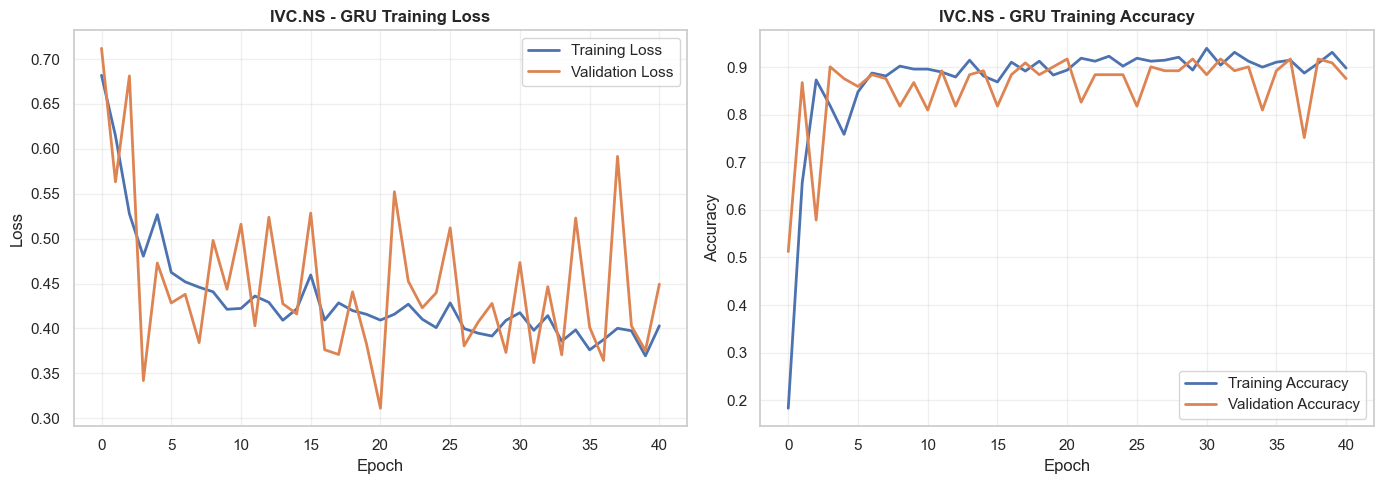

------------------------------------------------------------

==================== GRU TRAINING FOR RS ====================
Training set size: (619, 37)
Test set size: (110, 37)
Training period: 2022-11-28 to 2025-05-20
Test period: 2025-05-21 to 2025-10-27
Training distribution: Normal=560, Shock=59
Test distribution: Normal=97, Shock=13
Class imbalance ratio: 9.49:1

[TRAINING] Training GRU Model...
           Created 609 training sequences and 100 test sequences
           Class weights: {0: 0.5536363636363636, 1: 5.161016949152542}
           Applying class weights to handle imbalance ratio of 9.49:1

           [CONFIG] GRU Model Architecture:
                    Input shape: (10, 37)
                    Layer 1: GRU(64 units) + Dropout(0.3)
                    Layer 2: GRU(32 units) + Dropout(0.3)
                    Layer 3: Dense(16, relu)
                    Output: Dense(1, sigmoid)
                    Total parameters: 29,729

           Training GRU with class weights (this

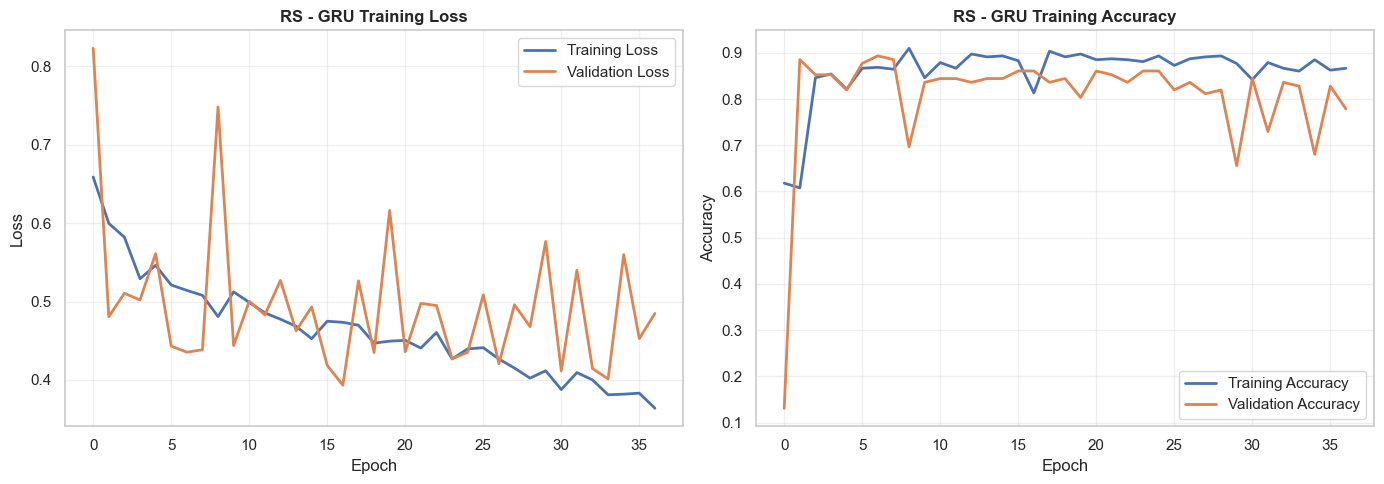

------------------------------------------------------------

==================== GRU TRAINING FOR PHARMABEES.NS ====================
Training set size: (595, 37)
Test set size: (106, 37)
Training period: 2022-11-28 to 2025-05-27
Test period: 2025-05-28 to 2025-10-28
Training distribution: Normal=556, Shock=39
Test distribution: Normal=89, Shock=17
Class imbalance ratio: 14.26:1

[TRAINING] Training GRU Model...
           Created 585 training sequences and 96 test sequences
           Class weights: {0: 0.5347349177330896, 1: 7.697368421052632}
           Applying class weights to handle imbalance ratio of 14.26:1

           [CONFIG] GRU Model Architecture:
                    Input shape: (10, 37)
                    Layer 1: GRU(64 units) + Dropout(0.3)
                    Layer 2: GRU(32 units) + Dropout(0.3)
                    Layer 3: Dense(16, relu)
                    Output: Dense(1, sigmoid)
                    Total parameters: 29,729

           Training GRU with class w

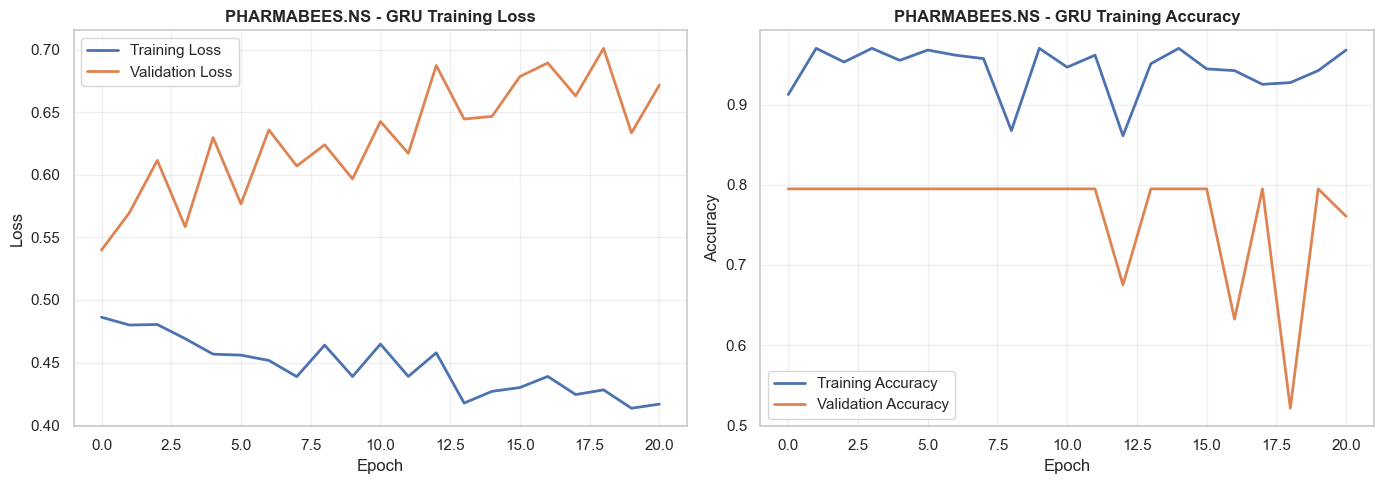

------------------------------------------------------------

==================== GRU TRAINING FOR CHWY ====================
Training set size: (621, 37)
Test set size: (110, 37)
Training period: 2022-11-28 to 2025-05-20
Test period: 2025-05-21 to 2025-10-27
Training distribution: Normal=563, Shock=58
Test distribution: Normal=100, Shock=10
Class imbalance ratio: 9.71:1

[TRAINING] Training GRU Model...
           Created 611 training sequences and 100 test sequences
           Class weights: {0: 0.5514440433212996, 1: 5.359649122807017}
           Applying class weights to handle imbalance ratio of 9.71:1

           [CONFIG] GRU Model Architecture:
                    Input shape: (10, 37)
                    Layer 1: GRU(64 units) + Dropout(0.3)
                    Layer 2: GRU(32 units) + Dropout(0.3)
                    Layer 3: Dense(16, relu)
                    Output: Dense(1, sigmoid)
                    Total parameters: 29,729

           Training GRU with class weights (t

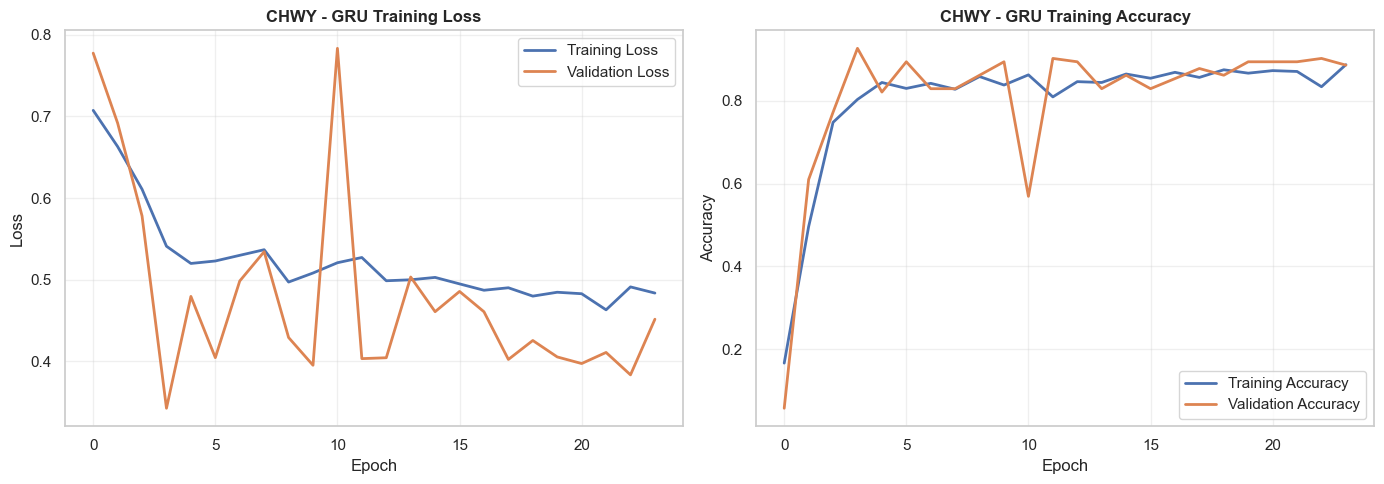

------------------------------------------------------------

GRU MODEL PERFORMANCE SUMMARY


,Ticker,Model,Train_Accuracy,Train_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Sequences_Train,Sequences_Test,Total_Params
0,IVC.NS,GRU,0.9385,0.9343,0.9796,0.9596,0.9796,0.9695,0.1667,602,98,29729
1,RS,GRU,0.9031,0.9073,0.9500,0.9523,0.9500,0.9509,0.9213,609,100,29729
2,PHARMABEES.NS,GRU,0.9350,0.9037,0.8438,0.7119,0.8438,0.7722,0.4436,585,96,29729
3,CHWY,GRU,0.9051,0.9035,0.9500,0.9525,0.9500,0.9511,0.9500,611,100,29729



[RANKING] BEST PERFORMING STOCKS (by Test F1 Score):
--------------------------------------------------
IVC.NS         : Test F1=0.969, ROC-AUC=0.167, Accuracy=0.980
CHWY           : Test F1=0.951, ROC-AUC=0.950, Accuracy=0.950
RS             : Test F1=0.951, ROC-AUC=0.921, Accuracy=0.950
PHARMABEES.NS  : Test F1=0.772, ROC-AUC=0.444, Accuracy=0.844


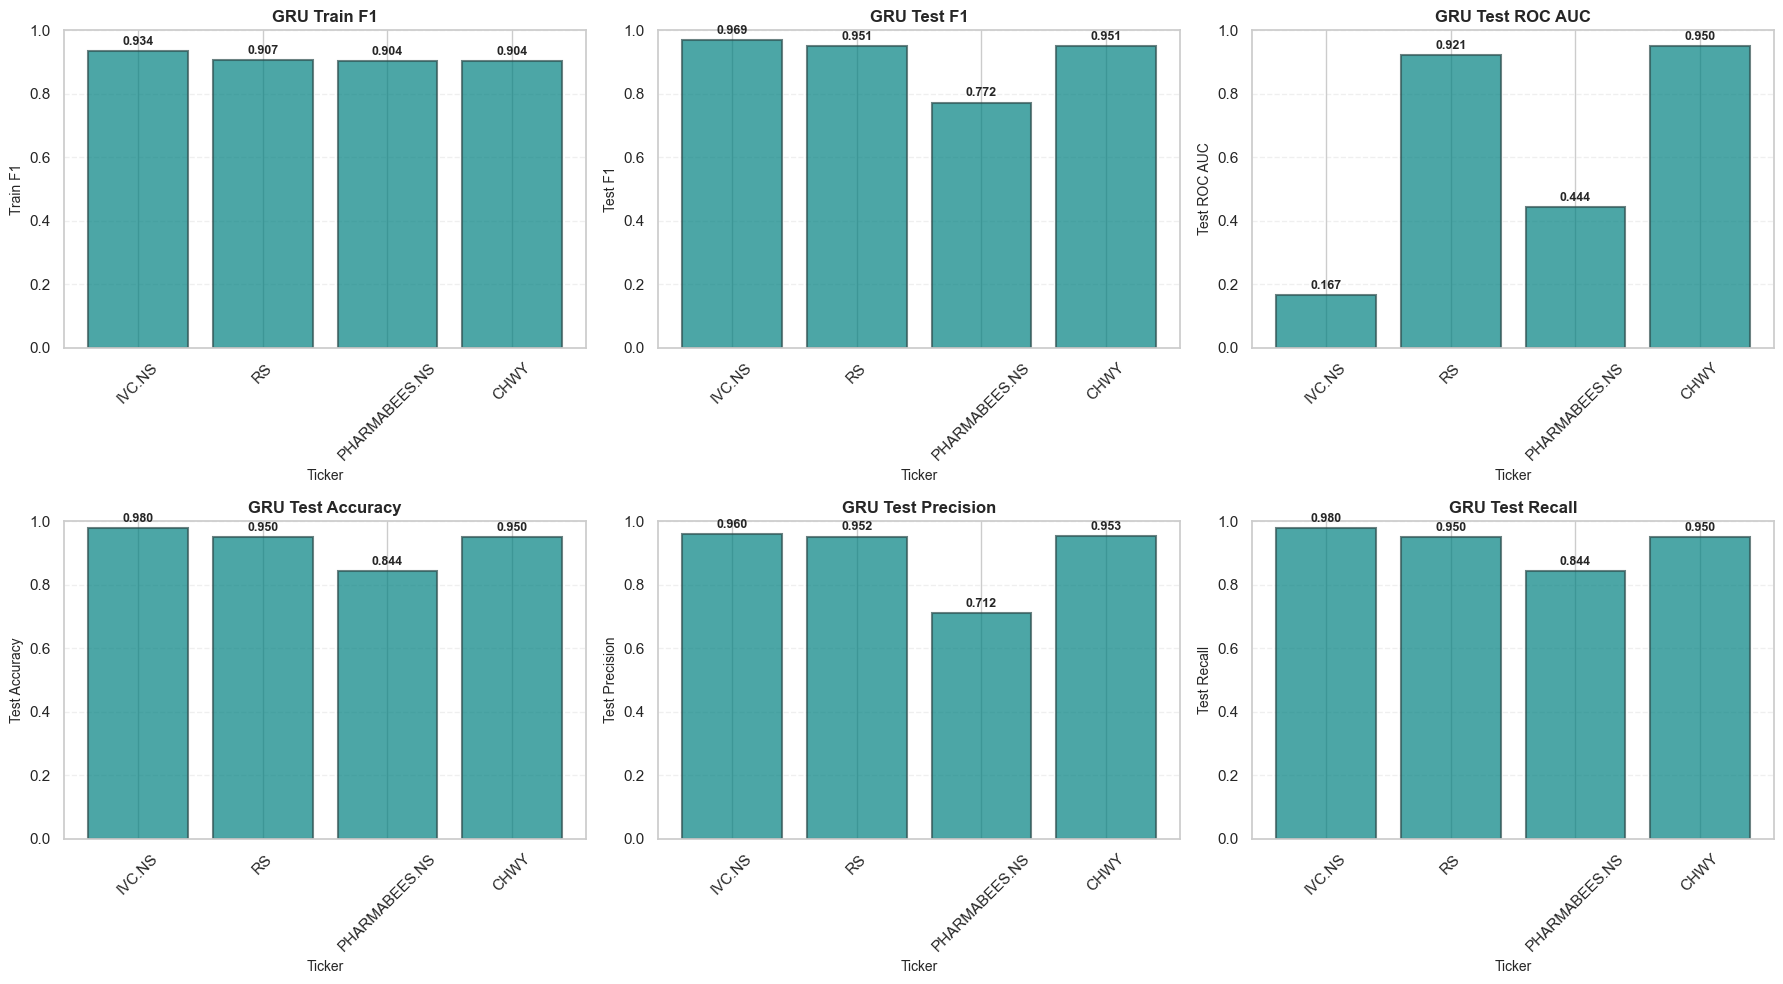


GRU MODEL SUMMARY STATISTICS


,Train_Accuracy,Train_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC
count,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000
mean,0.9204,0.9122,0.9308,0.8941,0.9308,0.9109,0.6204
std,0.0189,0.0148,0.0597,0.1215,0.0597,0.0929,0.3814
min,0.9031,0.9035,0.8438,0.7119,0.8438,0.7722,0.1667
25%,0.9046,0.9036,0.9234,0.8922,0.9234,0.9063,0.3744
50%,0.9201,0.9055,0.9500,0.9524,0.9500,0.9510,0.6825
75%,0.9359,0.9141,0.9574,0.9543,0.9574,0.9557,0.9285
max,0.9385,0.9343,0.9796,0.9596,0.9796,0.9695,0.9500



TRAINING VS TEST PERFORMANCE


,Ticker,Train_Accuracy,Test_Accuracy,Train_F1,Test_F1,Accuracy_Diff,F1_Diff
0,IVC.NS,0.9385,0.9796,0.9343,0.9695,-0.0411,-0.0352
1,RS,0.9031,0.9500,0.9073,0.9509,-0.0469,-0.0436
2,PHARMABEES.NS,0.9350,0.8438,0.9037,0.7722,0.0913,0.1314
3,CHWY,0.9051,0.9500,0.9035,0.9511,-0.0449,-0.0475



[ANALYSIS] Overfitting Analysis:
           Average Train-Test Accuracy Gap: -0.010
           Average Train-Test F1 Gap: 0.001
           [SUCCESS] Model shows good generalization

GRU MODEL EFFICIENCY
Average model parameters: 29,729
Parameter range: 29,729 to 29,729
Note: GRU typically has ~25% fewer parameters than LSTM for the same architecture

[SUCCESS] Successfully trained GRU models for 4 stocks!
[INFO] GRU: Gated Recurrent Unit with 10-step sequence processing
[METRICS] Average Test Performance: F1=0.911, ROC-AUC=0.620
[INFO] Efficiency: Faster training than LSTM with comparable performance


In [ ]:
# GRU Model for Financial Time Series Liquidity Shock Prediction
print("="*80)
print("TRAINING GRU FOR LIQUIDITY SHOCK PREDICTION")
print("GATED RECURRENT UNIT - EFFICIENT DEEP LEARNING TIME SERIES MODEL")
print("="*80)
print("[CONFIG] Class Imbalance Strategy: Computed class weights (balanced)")
print("="*80)

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import TensorFlow for GRU
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_sequences_gru(X, y, sequence_length=10):
    """
    Create sequences for GRU training
    """
    X_seq, y_seq = [], []
    
    # Convert to numpy arrays for reliable indexing
    X_array = X.values if isinstance(X, pd.DataFrame) else X
    y_array = y.values if isinstance(y, pd.Series) else np.array(y)
    
    # Ensure y_array is 1D
    if y_array.ndim > 1:
        y_array = y_array.flatten()
    
    # Create sequences using array indexing
    for i in range(sequence_length, len(X_array)):
        X_seq.append(X_array[i-sequence_length:i])
        y_seq.append(y_array[i])
    
    if len(X_seq) == 0:
        return np.array([]), np.array([])
    
    return np.array(X_seq), np.array(y_seq)

def create_gru_model(input_shape):
    """
    Create GRU model architecture
    GRU has fewer parameters than LSTM, making it faster to train
    """
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(32, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

# Store results for all stocks
gru_results = {}
gru_performance = []

# Parameters
sequence_length = 10

# Train GRU model for each stock individually
for ticker in stock_data_prepared.keys():
    print(f"\n{'='*20} GRU TRAINING FOR {ticker} {'='*20}")
    
    # Get data for this stock
    stock_data = stock_data_prepared[ticker]
    X_train = stock_data['X_train']
    X_test = stock_data['X_test']
    y_train_binary = stock_data['y_train_binary']
    y_test_binary = stock_data['y_test_binary']
    
    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    print(f"Training period: {X_train.index.min().date()} to {X_train.index.max().date()}")
    print(f"Test period: {X_test.index.min().date()} to {X_test.index.max().date()}")
    
    # Analyze class distribution
    train_dist = y_train_binary.value_counts().sort_index()
    test_dist = y_test_binary.value_counts().sort_index()
    
    print(f"Training distribution: Normal={train_dist.get(0, 0)}, Shock={train_dist.get(1, 0)}")
    print(f"Test distribution: Normal={test_dist.get(0, 0)}, Shock={test_dist.get(1, 0)}")
    
    # Skip if we don't have both classes in training set
    if len(train_dist) < 2:
        print(f"[WARNING] Only one class present in training data for {ticker}. Skipping...")
        continue
    
    # Calculate class imbalance ratio
    minority_class = train_dist.min()
    majority_class = train_dist.max()
    imbalance_ratio = majority_class / minority_class if minority_class > 0 else float('inf')
    
    print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")
    
    gru_results[ticker] = {}
    
    # GRU Training
    print(f"\n[TRAINING] Training GRU Model...")
    
    try:
        # Scale features for GRU
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), 
            index=X_train.index, 
            columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test), 
            index=X_test.index, 
            columns=X_test.columns
        )
        
        # Create sequences for training and testing
        X_train_seq, y_train_seq = create_sequences_gru(X_train_scaled, y_train_binary, sequence_length)
        X_test_seq, y_test_seq = create_sequences_gru(X_test_scaled, y_test_binary, sequence_length)
        
        if len(X_train_seq) > 0 and len(X_test_seq) > 0:
            print(f"           Created {len(X_train_seq)} training sequences and {len(X_test_seq)} test sequences")
            
            # Calculate class weights to handle imbalance
            from sklearn.utils.class_weight import compute_class_weight
            classes = np.unique(y_train_seq)
            class_weights_array = compute_class_weight('balanced', classes=classes, y=y_train_seq)
            class_weights = {int(classes[i]): class_weights_array[i] for i in range(len(classes))}
            
            print(f"           Class weights: {class_weights}")
            print(f"           Applying class weights to handle imbalance ratio of {imbalance_ratio:.2f}:1")
            
            # Create GRU model
            gru_model = create_gru_model((sequence_length, X_train_seq.shape[2]))
            
            # Display model architecture
            print(f"\n           [CONFIG] GRU Model Architecture:")
            print(f"                    Input shape: ({sequence_length}, {X_train_seq.shape[2]})")
            print(f"                    Layer 1: GRU(64 units) + Dropout(0.3)")
            print(f"                    Layer 2: GRU(32 units) + Dropout(0.3)")
            print(f"                    Layer 3: Dense(16, relu)")
            print(f"                    Output: Dense(1, sigmoid)")
            
            # Count parameters
            total_params = gru_model.count_params()
            print(f"                    Total parameters: {total_params:,}")
            
            # Train model with early stopping
            early_stopping = EarlyStopping(
                monitor='val_loss', 
                patience=20, 
                restore_best_weights=True,
                verbose=0
            )
            
            # Train the model with class weights
            print(f"\n           Training GRU with class weights (this may take a moment)...")
            history = gru_model.fit(
                X_train_seq, y_train_seq, 
                epochs=150, 
                batch_size=16, 
                verbose=0, 
                callbacks=[early_stopping],
                validation_split=0.2,
                class_weight=class_weights
            )
            
            print(f"           [SUCCESS] Training completed in {len(history.history['loss'])} epochs")
            
            # Make predictions
            y_pred_prob_gru = gru_model.predict(X_test_seq, verbose=0)
            y_pred_test_gru = (y_pred_prob_gru > 0.5).astype(int).flatten()
            
            # Also get training predictions
            y_pred_prob_train = gru_model.predict(X_train_seq, verbose=0)
            y_pred_train_gru = (y_pred_prob_train > 0.5).astype(int).flatten()
            
            # Calculate training metrics
            train_accuracy_gru = accuracy_score(y_train_seq, y_pred_train_gru)
            train_precision_gru = precision_score(y_train_seq, y_pred_train_gru, average='weighted', zero_division=0)
            train_recall_gru = recall_score(y_train_seq, y_pred_train_gru, average='weighted', zero_division=0)
            train_f1_gru = f1_score(y_train_seq, y_pred_train_gru, average='weighted', zero_division=0)
            
            # Calculate test metrics
            test_accuracy_gru = accuracy_score(y_test_seq, y_pred_test_gru)
            test_precision_gru = precision_score(y_test_seq, y_pred_test_gru, average='weighted', zero_division=0)
            test_recall_gru = recall_score(y_test_seq, y_pred_test_gru, average='weighted', zero_division=0)
            test_f1_gru = f1_score(y_test_seq, y_pred_test_gru, average='weighted', zero_division=0)
            
            # ROC AUC
            try:
                if len(np.unique(y_test_seq)) > 1:
                    test_roc_auc_gru = roc_auc_score(y_test_seq, y_pred_prob_gru.flatten())
                else:
                    test_roc_auc_gru = 0.5
            except:
                test_roc_auc_gru = 0.5
            
            # Store results
            gru_results[ticker]['GRU'] = {
                'model': gru_model,
                'scaler': scaler,
                'sequence_length': sequence_length,
                'train_accuracy': train_accuracy_gru,
                'train_precision': train_precision_gru,
                'train_recall': train_recall_gru,
                'train_f1': train_f1_gru,
                'test_accuracy': test_accuracy_gru,
                'test_precision': test_precision_gru,
                'test_recall': test_recall_gru,
                'test_f1': test_f1_gru,
                'test_roc_auc': test_roc_auc_gru,
                'predictions': y_pred_test_gru,
                'probabilities': y_pred_prob_gru,
                'training_history': history.history
            }
            
            gru_performance.append({
                'Ticker': ticker,
                'Model': 'GRU',
                'Train_Accuracy': train_accuracy_gru,
                'Train_F1': train_f1_gru,
                'Test_Accuracy': test_accuracy_gru,
                'Test_Precision': test_precision_gru,
                'Test_Recall': test_recall_gru,
                'Test_F1': test_f1_gru,
                'Test_ROC_AUC': test_roc_auc_gru,
                'Sequences_Train': len(X_train_seq),
                'Sequences_Test': len(X_test_seq),
                'Total_Params': total_params
            })
            
            print(f"\n           [METRICS] Training Results:")
            print(f"                     Accuracy: {train_accuracy_gru:.3f}")
            print(f"                     F1 Score: {train_f1_gru:.3f}")
            
            print(f"\n           [METRICS] Test Results:")
            print(f"                     Accuracy: {test_accuracy_gru:.3f}")
            print(f"                     Precision: {test_precision_gru:.3f}")
            print(f"                     Recall: {test_recall_gru:.3f}")
            print(f"                     F1 Score: {test_f1_gru:.3f}")
            print(f"                     ROC-AUC: {test_roc_auc_gru:.3f}")
            
            # Classification Report
            print(f"\n           [REPORT] Classification Report (Test):")
            target_names = ['Normal', 'Liquidity Shock']
            unique_preds = np.unique(y_pred_test_gru)
            if len(unique_preds) > 1:
                print(classification_report(y_test_seq, y_pred_test_gru, target_names=target_names, zero_division=0))
            else:
                print(f"                    Only one class predicted: {target_names[unique_preds[0]]}")
                print(f"                    Accuracy: {test_accuracy_gru:.3f}")
            
            # Training History Visualization
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Plot 1: Loss curves
            axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
            axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
            axes[0].set_title(f'{ticker} - GRU Training Loss', fontsize=12, fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot 2: Accuracy curves
            axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
            axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
            axes[1].set_title(f'{ticker} - GRU Training Accuracy', fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        else:
            print(f"           [WARNING] Insufficient data for GRU sequence creation")
    
    except Exception as e:
        print(f"           [ERROR] GRU training failed for {ticker}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue
    
    print("-" * 60)

# Performance Summary
print(f"\n{'='*80}")
print("GRU MODEL PERFORMANCE SUMMARY")
print("="*80)

if gru_performance:
    performance_df = pd.DataFrame(gru_performance)
    display(performance_df)
    
    # Best performing ticker
    print(f"\n[RANKING] BEST PERFORMING STOCKS (by Test F1 Score):")
    print("-" * 50)
    best_performers = performance_df.nlargest(len(performance_df), 'Test_F1')
    for idx, row in best_performers.iterrows():
        print(f"{row['Ticker']:15s}: Test F1={row['Test_F1']:.3f}, ROC-AUC={row['Test_ROC_AUC']:.3f}, Accuracy={row['Test_Accuracy']:.3f}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    metrics = ['Train_F1', 'Test_F1', 'Test_ROC_AUC', 'Test_Accuracy', 'Test_Precision', 'Test_Recall']
    
    for i, metric in enumerate(metrics):
        row, col = divmod(i, 3)
        ax = axes[row, col]
        
        # Bar plot for each ticker
        bars = ax.bar(performance_df['Ticker'], performance_df[metric], 
                     color='teal', alpha=0.7, edgecolor='darkslategray', linewidth=1.5)
        
        # Add value labels on bars
        for bar, value in zip(bars, performance_df[metric]):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_title(f'GRU {metric.replace("_", " ")}', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric.replace('_', ' '), fontsize=10)
        ax.set_xlabel('Ticker', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim(0, min(1.0, performance_df[metric].max() * 1.15))
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("GRU MODEL SUMMARY STATISTICS")
    print("="*60)
    
    summary_cols = ['Train_Accuracy', 'Train_F1', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC']
    summary_stats = performance_df[summary_cols].describe()
    display(summary_stats)
    
    # Training vs Test Performance Comparison
    print(f"\n{'='*60}")
    print("TRAINING VS TEST PERFORMANCE")
    print("="*60)
    
    comparison_df = performance_df[['Ticker', 'Train_Accuracy', 'Test_Accuracy', 'Train_F1', 'Test_F1']].copy()
    comparison_df['Accuracy_Diff'] = comparison_df['Train_Accuracy'] - comparison_df['Test_Accuracy']
    comparison_df['F1_Diff'] = comparison_df['Train_F1'] - comparison_df['Test_F1']
    display(comparison_df)
    
    # Check for overfitting
    print(f"\n[ANALYSIS] Overfitting Analysis:")
    avg_acc_diff = comparison_df['Accuracy_Diff'].mean()
    avg_f1_diff = comparison_df['F1_Diff'].mean()
    print(f"           Average Train-Test Accuracy Gap: {avg_acc_diff:.3f}")
    print(f"           Average Train-Test F1 Gap: {avg_f1_diff:.3f}")
    
    if avg_acc_diff > 0.1 or avg_f1_diff > 0.1:
        print(f"           [WARNING] Possible overfitting detected (gap > 0.1)")
    else:
        print(f"           [SUCCESS] Model shows good generalization")
    
    # Model Efficiency Comparison
    print(f"\n{'='*60}")
    print("GRU MODEL EFFICIENCY")
    print("="*60)
    print(f"Average model parameters: {performance_df['Total_Params'].mean():,.0f}")
    print(f"Parameter range: {performance_df['Total_Params'].min():,} to {performance_df['Total_Params'].max():,}")
    
    print(f"\n[SUCCESS] Successfully trained GRU models for {len(performance_df)} stocks!")
    print(f"[INFO] GRU: Gated Recurrent Unit with {sequence_length}-step sequence processing")
    print(f"[METRICS] Average Test Performance: F1={performance_df['Test_F1'].mean():.3f}, ROC-AUC={performance_df['Test_ROC_AUC'].mean():.3f}")
    print(f"[INFO] Efficiency: Faster training than LSTM with comparable performance")
    
else:
    print("[WARNING] No GRU models were successfully trained. Check your data.")

print("="*80)

## Ensemble Learning - Combining All Three Models

Ensemble learning combines LSTM, Fuzzy Time Series, and GRU models for improved predictions through:
- **Simple Average**: Equal weights (1/3) for each model's probability
- **Weighted Average**: F1-score-based weights for each model
- **Majority Voting**: Binary vote from each model (≥2 votes wins)

In [11]:
# Ensemble Learning Implementation
print("="*80)
print("ENSEMBLE LEARNING - COMBINING LSTM, FUZZY TS, AND GRU MODELS")
print("="*80)

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize ensemble results storage
ensemble_results = {}
ensemble_performance = []

# Process each ticker
for ticker in stock_data_prepared.keys():
    print(f"\n{'='*20} ENSEMBLE FOR {ticker} {'='*20}")
    
    try:
        # Get test data
        stock_data = stock_data_prepared[ticker]
        X_test = stock_data['X_test']
        y_test_binary = stock_data['y_test_binary']
        
        # Get LSTM results
        if ticker in all_results and 'LSTM' in all_results[ticker]:
            lstm_data = all_results[ticker]['LSTM']
            lstm_proba = lstm_data['probabilities'].flatten()
            lstm_pred = lstm_data['predictions']
            lstm_f1 = lstm_data['test_f1']
            lstm_roc_auc = lstm_data['test_roc_auc']
            sequence_length = lstm_data['sequence_length']
            
            # Align test data with LSTM sequences
            y_test_aligned = y_test_binary.values[sequence_length:]
            
            print(f"[LSTM] F1: {lstm_f1:.3f}, ROC-AUC: {lstm_roc_auc:.3f}")
        else:
            print(f"[WARNING] LSTM results not available for {ticker}")
            continue
        
        # Get Fuzzy TS results
        if ticker in fuzzy_results:
            fuzzy_data = fuzzy_results[ticker]
            fuzzy_shock_risks = fuzzy_data['shock_risks']
            fuzzy_threshold = fuzzy_data['shock_threshold']
            fuzzy_pred = (fuzzy_shock_risks > fuzzy_threshold).astype(int)
            fuzzy_f1 = fuzzy_data['test_f1']
            fuzzy_roc_auc = fuzzy_data['test_roc_auc']
            
            # Align Fuzzy predictions with LSTM
            fuzzy_proba_aligned = fuzzy_shock_risks[sequence_length:]
            fuzzy_pred_aligned = fuzzy_pred[sequence_length:]
            
            print(f"[Fuzzy TS] F1: {fuzzy_f1:.3f}, ROC-AUC: {fuzzy_roc_auc:.3f}")
        else:
            print(f"[WARNING] Fuzzy TS results not available for {ticker}")
            continue
        
        # Get GRU results
        if ticker in gru_results and 'GRU' in gru_results[ticker]:
            gru_data = gru_results[ticker]['GRU']
            gru_proba = gru_data['probabilities'].flatten()
            gru_pred = gru_data['predictions']
            gru_f1 = gru_data['test_f1']
            gru_roc_auc = gru_data['test_roc_auc']
            
            print(f"[GRU] F1: {gru_f1:.3f}, ROC-AUC: {gru_roc_auc:.3f}")
        else:
            print(f"[WARNING] GRU results not available for {ticker}")
            continue
        
        # Ensure all predictions have the same length
        min_len = min(len(lstm_proba), len(fuzzy_proba_aligned), len(gru_proba), len(y_test_aligned))
        
        lstm_proba = lstm_proba[:min_len]
        fuzzy_proba_aligned = fuzzy_proba_aligned[:min_len]
        gru_proba = gru_proba[:min_len]
        y_test_final = y_test_aligned[:min_len]
        
        print(f"\n[ENSEMBLE] Aligned predictions length: {min_len}")
        
        # Method 1: Simple Average (Equal Weights)
        print(f"\n[METHOD 1] Simple Average Ensemble")
        ensemble_proba_simple = (lstm_proba + fuzzy_proba_aligned + gru_proba) / 3
        ensemble_pred_simple = (ensemble_proba_simple > 0.5).astype(int)
        
        acc_simple = accuracy_score(y_test_final, ensemble_pred_simple)
        f1_simple = f1_score(y_test_final, ensemble_pred_simple, average='weighted', zero_division=0)
        precision_simple = precision_score(y_test_final, ensemble_pred_simple, average='weighted', zero_division=0)
        recall_simple = recall_score(y_test_final, ensemble_pred_simple, average='weighted', zero_division=0)
        
        try:
            if len(np.unique(y_test_final)) > 1:
                roc_auc_simple = roc_auc_score(y_test_final, ensemble_proba_simple)
            else:
                roc_auc_simple = 0.5
        except:
            roc_auc_simple = 0.5
        
        print(f"           Accuracy: {acc_simple:.3f}, F1: {f1_simple:.3f}, ROC-AUC: {roc_auc_simple:.3f}")
        
        # Method 2: Weighted Average (Performance-based weights)
        print(f"\n[METHOD 2] Weighted Average Ensemble (F1-based weights)")
        
        # Calculate weights based on F1 scores
        total_f1 = lstm_f1 + fuzzy_f1 + gru_f1
        weight_lstm = lstm_f1 / total_f1
        weight_fuzzy = fuzzy_f1 / total_f1
        weight_gru = gru_f1 / total_f1
        
        print(f"           Weights - LSTM: {weight_lstm:.3f}, Fuzzy: {weight_fuzzy:.3f}, GRU: {weight_gru:.3f}")
        
        ensemble_proba_weighted = (weight_lstm * lstm_proba + 
                                   weight_fuzzy * fuzzy_proba_aligned + 
                                   weight_gru * gru_proba)
        ensemble_pred_weighted = (ensemble_proba_weighted > 0.5).astype(int)
        
        acc_weighted = accuracy_score(y_test_final, ensemble_pred_weighted)
        f1_weighted = f1_score(y_test_final, ensemble_pred_weighted, average='weighted', zero_division=0)
        precision_weighted = precision_score(y_test_final, ensemble_pred_weighted, average='weighted', zero_division=0)
        recall_weighted = recall_score(y_test_final, ensemble_pred_weighted, average='weighted', zero_division=0)
        
        try:
            if len(np.unique(y_test_final)) > 1:
                roc_auc_weighted = roc_auc_score(y_test_final, ensemble_proba_weighted)
            else:
                roc_auc_weighted = 0.5
        except:
            roc_auc_weighted = 0.5
        
        print(f"           Accuracy: {acc_weighted:.3f}, F1: {f1_weighted:.3f}, ROC-AUC: {roc_auc_weighted:.3f}")
        
        # Method 3: Majority Voting
        print(f"\n[METHOD 3] Majority Voting Ensemble")
        
        lstm_pred_aligned = lstm_pred[:min_len]
        fuzzy_pred_final = fuzzy_pred_aligned[:min_len]
        gru_pred_aligned = gru_pred[:min_len]
        
        # Stack predictions
        vote_array = np.stack([lstm_pred_aligned, fuzzy_pred_final, gru_pred_aligned], axis=1)
        ensemble_pred_voting = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=vote_array)
        
        acc_voting = accuracy_score(y_test_final, ensemble_pred_voting)
        f1_voting = f1_score(y_test_final, ensemble_pred_voting, average='weighted', zero_division=0)
        precision_voting = precision_score(y_test_final, ensemble_pred_voting, average='weighted', zero_division=0)
        recall_voting = recall_score(y_test_final, ensemble_pred_voting, average='weighted', zero_division=0)
        
        # Use weighted ensemble probabilities for ROC-AUC in voting method
        try:
            if len(np.unique(y_test_final)) > 1:
                roc_auc_voting = roc_auc_score(y_test_final, ensemble_proba_weighted)
            else:
                roc_auc_voting = 0.5
        except:
            roc_auc_voting = 0.5
        
        print(f"           Accuracy: {acc_voting:.3f}, F1: {f1_voting:.3f}, ROC-AUC: {roc_auc_voting:.3f}")
        
        # Store ensemble results
        ensemble_results[ticker] = {
            'simple_average': {
                'predictions': ensemble_pred_simple,
                'probabilities': ensemble_proba_simple,
                'accuracy': acc_simple,
                'f1': f1_simple,
                'precision': precision_simple,
                'recall': recall_simple,
                'roc_auc': roc_auc_simple
            },
            'weighted_average': {
                'predictions': ensemble_pred_weighted,
                'probabilities': ensemble_proba_weighted,
                'accuracy': acc_weighted,
                'f1': f1_weighted,
                'precision': precision_weighted,
                'recall': recall_weighted,
                'roc_auc': roc_auc_weighted,
                'weights': {'lstm': weight_lstm, 'fuzzy': weight_fuzzy, 'gru': weight_gru}
            },
            'majority_voting': {
                'predictions': ensemble_pred_voting,
                'accuracy': acc_voting,
                'f1': f1_voting,
                'precision': precision_voting,
                'recall': recall_voting,
                'roc_auc': roc_auc_voting
            },
            'individual_models': {
                'lstm': {'f1': lstm_f1, 'roc_auc': lstm_roc_auc},
                'fuzzy': {'f1': fuzzy_f1, 'roc_auc': fuzzy_roc_auc},
                'gru': {'f1': gru_f1, 'roc_auc': gru_roc_auc}
            },
            'y_test': y_test_final
        }
        
        # Add to performance tracking
        for method, method_name in [('simple_average', 'Simple Average'), 
                                     ('weighted_average', 'Weighted Average'), 
                                     ('majority_voting', 'Majority Voting')]:
            result = ensemble_results[ticker][method]
            ensemble_performance.append({
                'Ticker': ticker,
                'Method': method_name,
                'Accuracy': result['accuracy'],
                'Precision': result['precision'],
                'Recall': result['recall'],
                'F1': result['f1'],
                'ROC_AUC': result['roc_auc']
            })
        
        print(f"\n[SUCCESS] Ensemble models created for {ticker}")
        print("-" * 60)
        
    except Exception as e:
        print(f"[ERROR] Ensemble creation failed for {ticker}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print("ENSEMBLE LEARNING COMPLETED")
print("="*80)
print(f"Successfully created ensemble models for {len(ensemble_results)} stocks")
print(f"Ensemble methods: Simple Average, Weighted Average, Majority Voting")

ENSEMBLE LEARNING - COMBINING LSTM, FUZZY TS, AND GRU MODELS

==================== ENSEMBLE FOR IVC.NS ====================
[LSTM] F1: 0.969, ROC-AUC: 0.266
[Fuzzy TS] F1: 0.959, ROC-AUC: 0.986
[GRU] F1: 0.969, ROC-AUC: 0.167

[ENSEMBLE] Aligned predictions length: 98

[METHOD 1] Simple Average Ensemble
           Accuracy: 0.980, F1: 0.969, ROC-AUC: 0.969

[METHOD 2] Weighted Average Ensemble (F1-based weights)
           Weights - LSTM: 0.335, Fuzzy: 0.331, GRU: 0.335
           Accuracy: 0.980, F1: 0.969, ROC-AUC: 0.969

[METHOD 3] Majority Voting Ensemble
           Accuracy: 0.980, F1: 0.969, ROC-AUC: 0.969

[SUCCESS] Ensemble models created for IVC.NS
------------------------------------------------------------

==================== ENSEMBLE FOR RS ====================
[LSTM] F1: 0.934, ROC-AUC: 0.934
[Fuzzy TS] F1: 0.921, ROC-AUC: 0.977
[GRU] F1: 0.951, ROC-AUC: 0.921

[ENSEMBLE] Aligned predictions length: 100

[METHOD 1] Simple Average Ensemble
           Accuracy: 0.950, F1: 

### Ensemble Performance Visualization

ENSEMBLE MODEL PERFORMANCE ANALYSIS


,Ticker,Method,Accuracy,Precision,Recall,F1,ROC_AUC
0,IVC.NS,Simple Average,0.9796,0.9596,0.9796,0.9695,0.9688
1,IVC.NS,Weighted Average,0.9796,0.9596,0.9796,0.9695,0.9688
2,IVC.NS,Majority Voting,0.9796,0.9596,0.9796,0.9695,0.9688
3,RS,Simple Average,0.9500,0.9523,0.9500,0.9509,0.9857
4,RS,Weighted Average,0.9500,0.9523,0.9500,0.9509,0.9857
5,RS,Majority Voting,0.9500,0.9523,0.9500,0.9509,0.9857
6,PHARMABEES.NS,Simple Average,0.8438,0.7119,0.8438,0.7722,0.7152
7,PHARMABEES.NS,Weighted Average,0.8438,0.7119,0.8438,0.7722,0.7152
8,PHARMABEES.NS,Majority Voting,0.8438,0.7119,0.8438,0.7722,0.7152
9,CHWY,Simple Average,0.9400,0.9437,0.9400,0.9281,0.9789



ENSEMBLE METHODS COMPARISON


,Accuracy,Precision,Recall,F1,ROC_AUC
Method,,,,,
Majority Voting,0.9258,0.8897,0.9258,0.9013,0.9121
Simple Average,0.9283,0.8919,0.9283,0.9052,0.9121
Weighted Average,0.9283,0.8919,0.9283,0.9052,0.9121


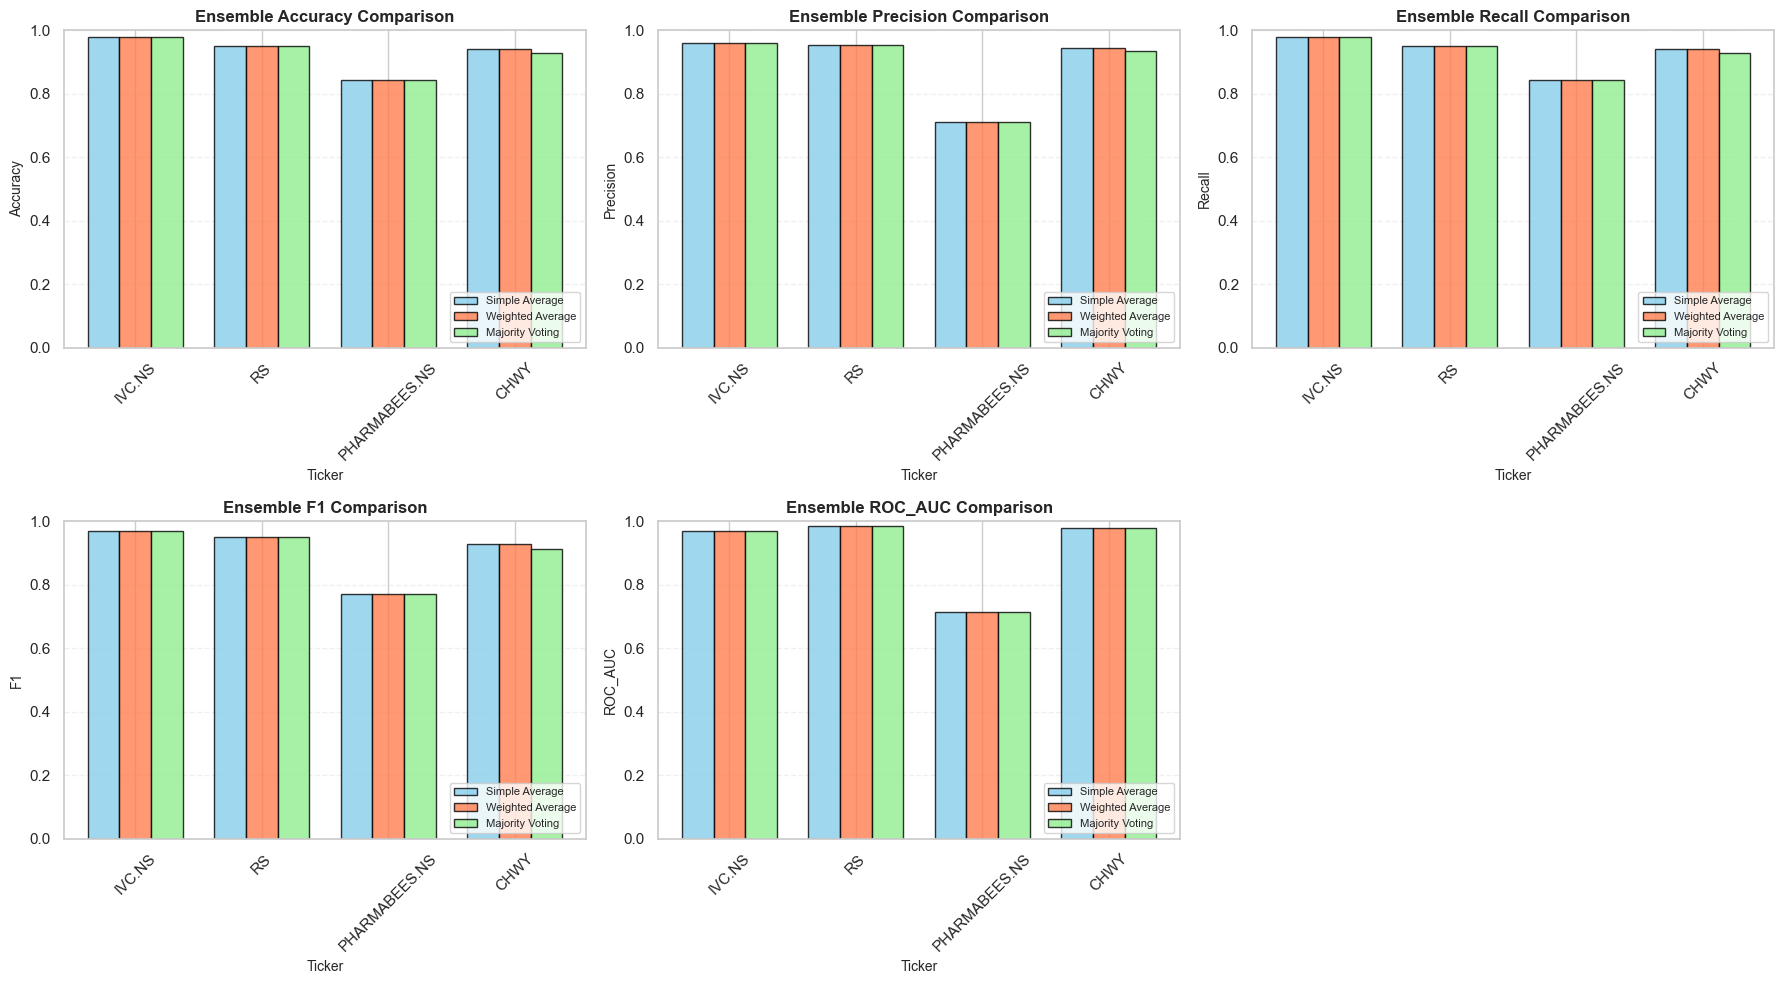


INDIVIDUAL MODELS VS ENSEMBLE COMPARISON


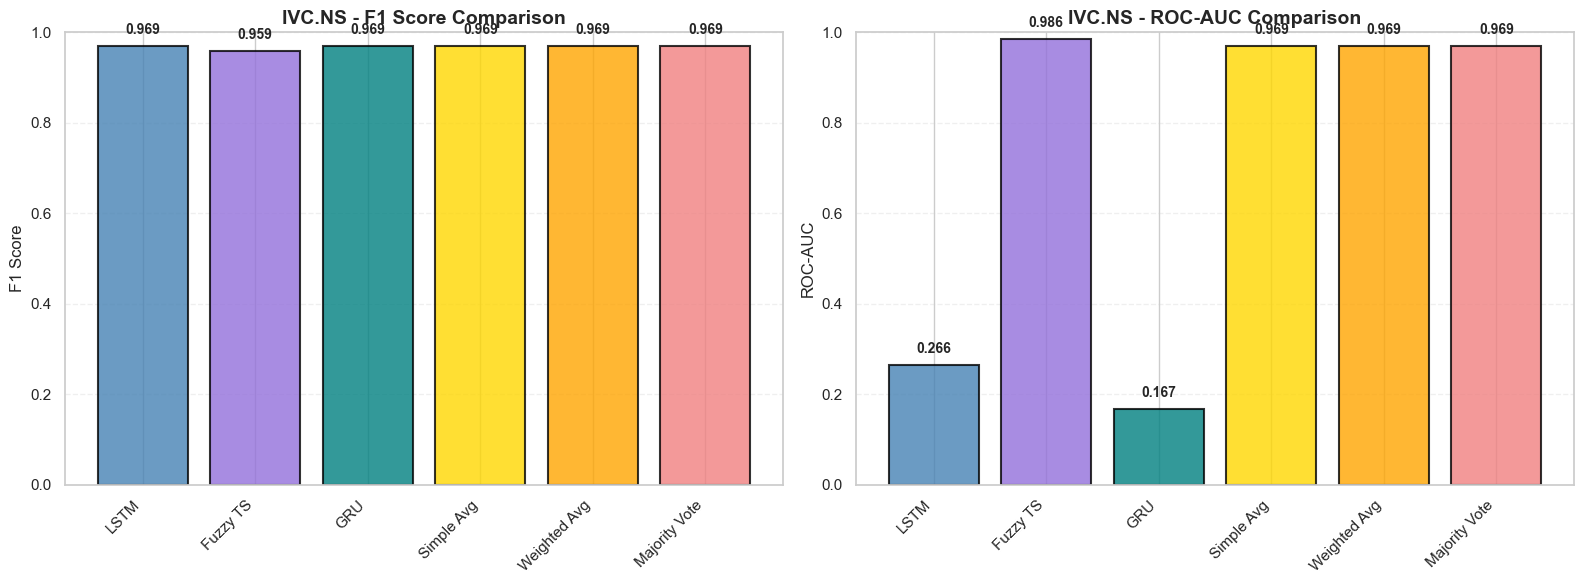

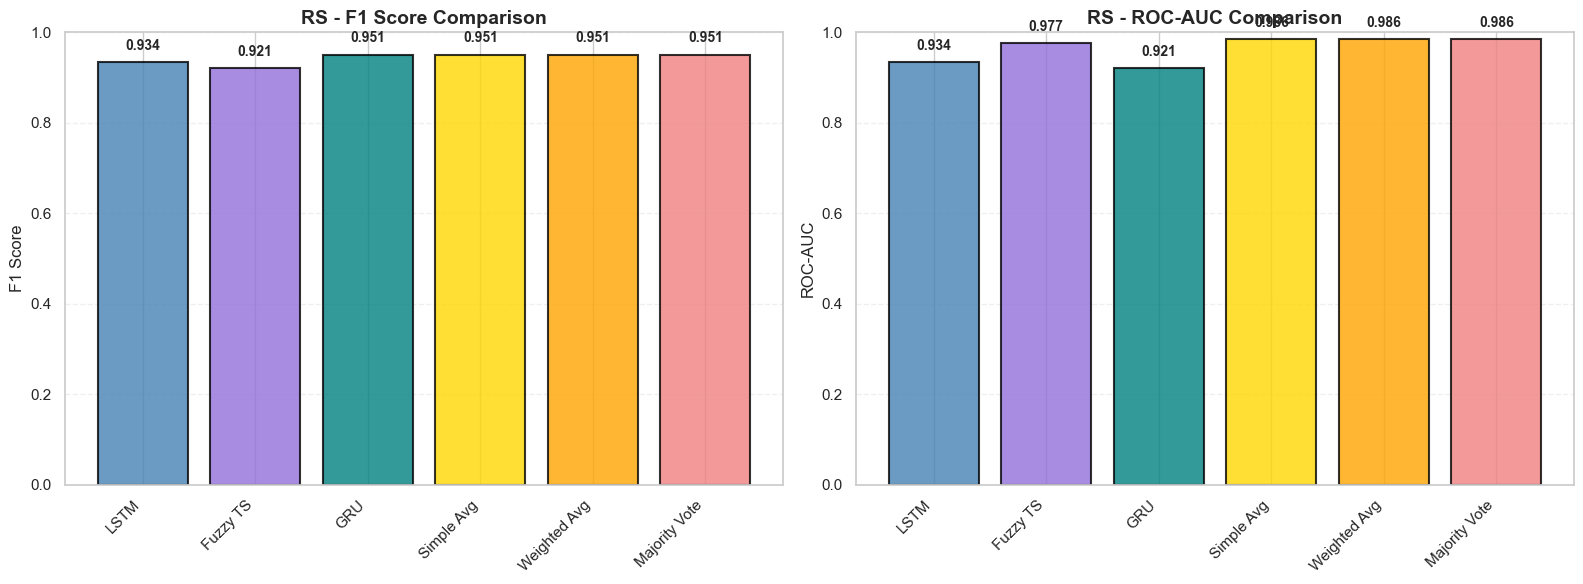

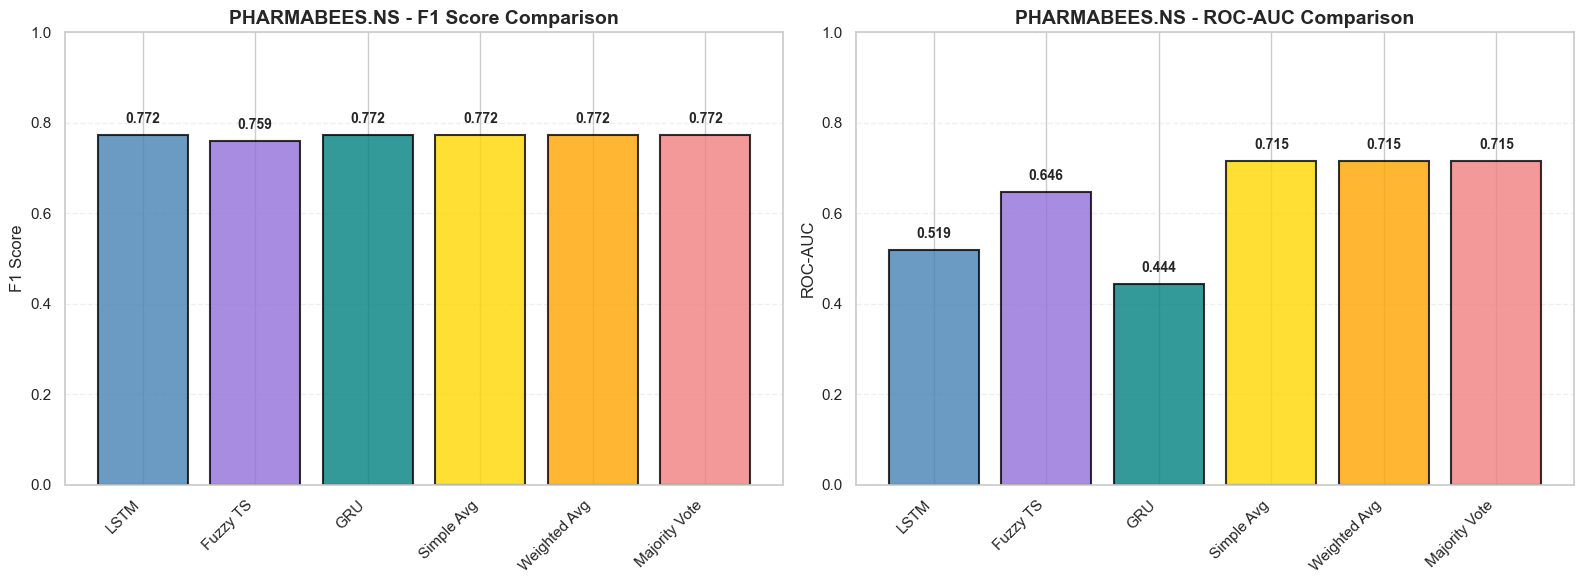

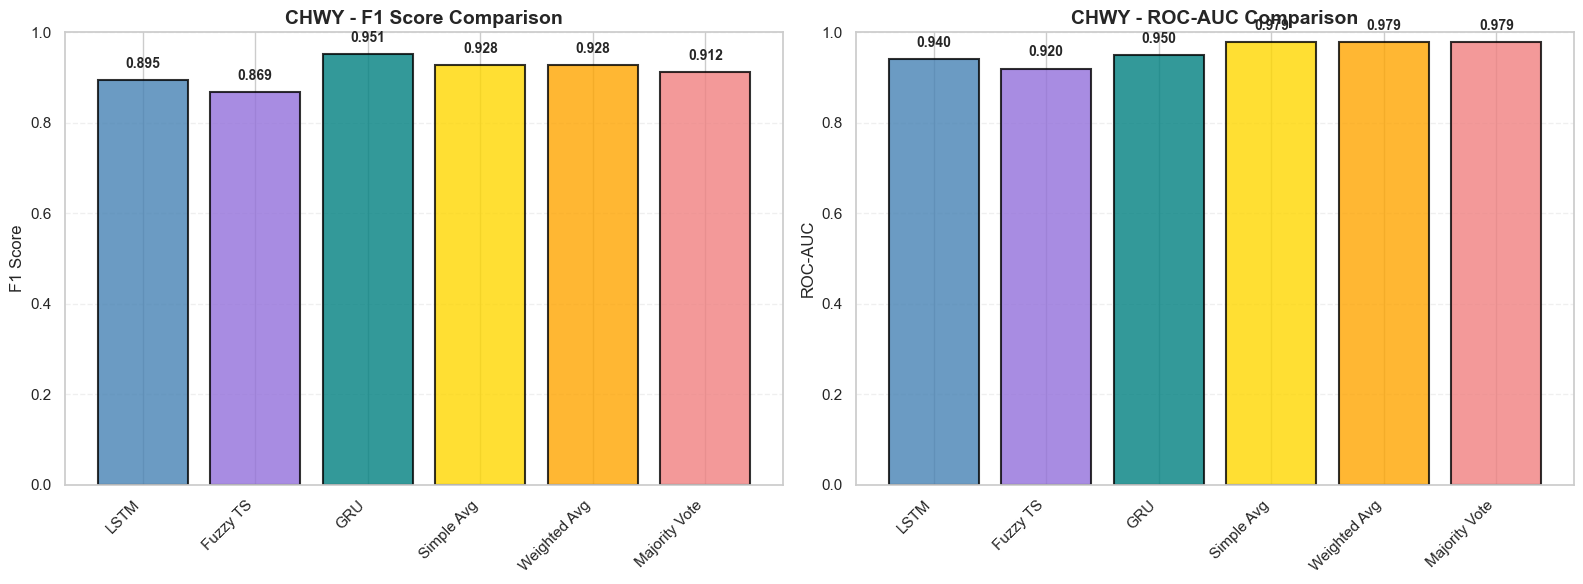


CONFUSION MATRICES - WEIGHTED AVERAGE ENSEMBLE

IVC.NS - Classification Report (Weighted Ensemble):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99        96
       Shock       0.00      0.00      0.00         2

    accuracy                           0.98        98
   macro avg       0.49      0.50      0.49        98
weighted avg       0.96      0.98      0.97        98


RS - Classification Report (Weighted Ensemble):
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.97        89
       Shock       0.75      0.82      0.78        11

    accuracy                           0.95       100
   macro avg       0.86      0.89      0.88       100
weighted avg       0.95      0.95      0.95       100


PHARMABEES.NS - Classification Report (Weighted Ensemble):
              precision    recall  f1-score   support

      Normal       0.84      1.00      0.92        81
       Shock       0.00    

Accuracy                                                   \
                    count   mean    std    min    25%    50%    75%    max   
Method                                                                       
Majority Voting    4.0000 0.9258 0.0584 0.8438 0.9084 0.9400 0.9574 0.9796   
Simple Average     4.0000 0.9283 0.0588 0.8438 0.9159 0.9450 0.9574 0.9796   
Weighted Average   4.0000 0.9283 0.0588 0.8438 0.9159 0.9450 0.9574 0.9796   

                     F1                                                   \
                  count   mean    std    min    25%    50%    75%    max   
Method                                                                     
Majority Voting  4.0000 0.9013 0.0892 0.7722 0.8774 0.9317 0.9556 0.9695   
Simple Average   4.0000 0.9052 0.0902 0.7722 0.8891 0.9395 0.9556 0.9695   
Weighted Average 4.0000 0.9052 0.0902 0.7722 0.8891 0.9395 0.9556 0.9695   

                 ROC_AUC                                                   
                   count   mean    std    min    25%    50%    75%    max  
Method                                                                     
Majority Voting   4.0000 0.9121 0.1315 0.7152 0.9054 0.9738 0.9806 0.9857  
Simple Average    4.0000 0.9121 0.1315 0.7152 0.9054 0.9738 0.9806 0.9857  
Weighted Average  4.0000 0.9121 0.1315 0.7152 0.9054 0.9738 0.9806 0.9857


[SUCCESS] Ensemble visualization completed!
[INFO] Total ensemble models: 12
[INFO] Best method: Simple Average


In [12]:
# Ensemble Performance Summary and Visualizations
print("="*80)
print("ENSEMBLE MODEL PERFORMANCE ANALYSIS")
print("="*80)

if ensemble_performance:
    ensemble_df = pd.DataFrame(ensemble_performance)
    display(ensemble_df)
    
    # Compare ensemble methods across stocks
    print(f"\n{'='*60}")
    print("ENSEMBLE METHODS COMPARISON")
    print("="*60)
    
    # Group by method and show average performance
    method_comparison = ensemble_df.groupby('Method')[['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']].mean()
    display(method_comparison)
    
    # Visualization 1: Compare ensemble methods performance
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    colors = {'Simple Average': 'skyblue', 'Weighted Average': 'coral', 'Majority Voting': 'lightgreen'}
    
    for i, metric in enumerate(metrics):
        row, col = divmod(i, 3)
        ax = axes[row, col]
        
        # Create grouped bar chart
        methods = ensemble_df['Method'].unique()
        x_pos = np.arange(len(ensemble_df['Ticker'].unique()))
        width = 0.25
        
        for j, method in enumerate(methods):
            method_data = ensemble_df[ensemble_df['Method'] == method]
            ax.bar(x_pos + j*width, method_data[metric], width, 
                   label=method, color=colors[method], alpha=0.8, edgecolor='black')
        
        ax.set_title(f'Ensemble {metric} Comparison', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric, fontsize=10)
        ax.set_xlabel('Ticker', fontsize=10)
        ax.set_xticks(x_pos + width)
        ax.set_xticklabels(ensemble_df['Ticker'].unique(), rotation=45)
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim(0, 1.0)
    
    # Hide the 6th subplot
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: Individual vs Ensemble Comparison
    print(f"\n{'='*60}")
    print("INDIVIDUAL MODELS VS ENSEMBLE COMPARISON")
    print("="*60)
    
    for ticker in ensemble_results.keys():
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Get individual model performances
        individual = ensemble_results[ticker]['individual_models']
        ensemble_methods = ['simple_average', 'weighted_average', 'majority_voting']
        
        # Plot 1: F1 Score Comparison
        models_f1 = {
            'LSTM': individual['lstm']['f1'],
            'Fuzzy TS': individual['fuzzy']['f1'],
            'GRU': individual['gru']['f1'],
            'Simple Avg': ensemble_results[ticker]['simple_average']['f1'],
            'Weighted Avg': ensemble_results[ticker]['weighted_average']['f1'],
            'Majority Vote': ensemble_results[ticker]['majority_voting']['f1']
        }
        
        bars1 = axes[0].bar(range(len(models_f1)), list(models_f1.values()), 
                            color=['steelblue', 'mediumpurple', 'teal', 'gold', 'orange', 'lightcoral'],
                            alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[0].set_xticks(range(len(models_f1)))
        axes[0].set_xticklabels(list(models_f1.keys()), rotation=45, ha='right')
        axes[0].set_title(f'{ticker} - F1 Score Comparison', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('F1 Score', fontsize=12)
        axes[0].grid(axis='y', alpha=0.3, linestyle='--')
        axes[0].set_ylim(0, 1.0)
        
        # Add value labels on bars
        for bar, value in zip(bars1, models_f1.values()):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.02,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Plot 2: ROC-AUC Comparison
        models_roc = {
            'LSTM': individual['lstm']['roc_auc'],
            'Fuzzy TS': individual['fuzzy']['roc_auc'],
            'GRU': individual['gru']['roc_auc'],
            'Simple Avg': ensemble_results[ticker]['simple_average']['roc_auc'],
            'Weighted Avg': ensemble_results[ticker]['weighted_average']['roc_auc'],
            'Majority Vote': ensemble_results[ticker]['majority_voting']['roc_auc']
        }
        
        bars2 = axes[1].bar(range(len(models_roc)), list(models_roc.values()), 
                            color=['steelblue', 'mediumpurple', 'teal', 'gold', 'orange', 'lightcoral'],
                            alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[1].set_xticks(range(len(models_roc)))
        axes[1].set_xticklabels(list(models_roc.keys()), rotation=45, ha='right')
        axes[1].set_title(f'{ticker} - ROC-AUC Comparison', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('ROC-AUC', fontsize=12)
        axes[1].grid(axis='y', alpha=0.3, linestyle='--')
        axes[1].set_ylim(0, 1.0)
        
        # Add value labels on bars
        for bar, value in zip(bars2, models_roc.values()):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.02,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Visualization 3: Confusion Matrices for best ensemble method
    print(f"\n{'='*60}")
    print("CONFUSION MATRICES - WEIGHTED AVERAGE ENSEMBLE")
    print("="*60)
    
    for ticker in ensemble_results.keys():
        y_test = ensemble_results[ticker]['y_test']
        y_pred = ensemble_results[ticker]['weighted_average']['predictions']
        
        
        # Classification report
        print(f"\n{ticker} - Classification Report (Weighted Ensemble):")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Shock'], zero_division=0))
    
    # Best performing ensemble method
    print(f"\n{'='*60}")
    print("BEST ENSEMBLE METHOD SELECTION")
    print("="*60)
    
    avg_performance = ensemble_df.groupby('Method')[['F1', 'ROC_AUC']].mean()
    best_method = avg_performance['F1'].idxmax()
    
    print(f"Best ensemble method based on F1 Score: {best_method}")
    print(f"Average F1: {avg_performance.loc[best_method, 'F1']:.3f}")
    print(f"Average ROC-AUC: {avg_performance.loc[best_method, 'ROC_AUC']:.3f}")
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("ENSEMBLE PERFORMANCE SUMMARY STATISTICS")
    print("="*60)
    
    summary_stats = ensemble_df.groupby('Method').describe()[['Accuracy', 'F1', 'ROC_AUC']]
    display(summary_stats)
    
    print(f"\n[SUCCESS] Ensemble visualization completed!")
    print(f"[INFO] Total ensemble models: {len(ensemble_results) * 3}")
    print(f"[INFO] Best method: {best_method}")
    
else:
    print("[WARNING] No ensemble performance data available for visualization.")

### Real-Time Prediction Using Ensemble Model

Real-time liquidity shock prediction using the weighted ensemble approach

In [13]:
# Real-Time Prediction Function Using Ensemble
print("="*80)
print("REAL-TIME LIQUIDITY SHOCK PREDICTION - ENSEMBLE MODEL")
print("="*80)

import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def fetch_realtime_data(ticker, days=30):
    """
    Fetch recent stock data for real-time prediction
    
    Args:
        ticker: Stock ticker symbol
        days: Number of days of historical data to fetch
    
    Returns:
        DataFrame with recent stock data
    """
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days)
    
    try:
        # Download data
        data = yf.download(ticker, start=start_date, end=end_date, 
                          interval='1d', progress=False, auto_adjust=True)
        
        if len(data) == 0:
            print(f"[ERROR] No data available for {ticker}")
            return None
        
        # Reset index and remove timezone
        data = data.reset_index()
        if 'Date' in data.columns:
            data['Date'] = pd.to_datetime(data['Date'])
            if hasattr(data['Date'].iloc[0], 'tz'):
                data['Date'] = data['Date'].dt.tz_localize(None)
        
        print(f"[SUCCESS] Fetched {len(data)} days of data for {ticker}")
        return data
    
    except Exception as e:
        print(f"[ERROR] Failed to fetch data for {ticker}: {str(e)}")
        return None

def engineer_realtime_features(df, vol_threshold=2, spread_threshold=95, volume_threshold=5):
    """
    Engineer features for real-time data (same as training)
    Includes liquidity shock labeling features
    """
    df_featured = df.copy()
    
    # Set Date as index
    if 'Date' in df_featured.columns:
        df_featured.set_index('Date', inplace=True)
    
    # Keep only numeric columns
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    df_featured = df_featured[numeric_columns]
    
    # Calculate features
    df_featured['returns'] = df_featured['Close'].pct_change()
    df_featured['volatility'] = df_featured['returns'].rolling(window=10).std()
    df_featured['spread_proxy'] = (df_featured['High'] - df_featured['Low']) / df_featured['Close']
    df_featured['turnover'] = df_featured['Volume'] * df_featured['Close']
    df_featured['volume_rolling_mean'] = df_featured['Volume'].rolling(window=20).mean()
    df_featured['volume_rolling_std'] = df_featured['Volume'].rolling(window=20).std()
    
    # Lagged features
    for lag in range(1, 6):
        df_featured[f'returns_lag_{lag}'] = df_featured['returns'].shift(lag)
        df_featured[f'volume_lag_{lag}'] = df_featured['Volume'].shift(lag)
        df_featured[f'spread_proxy_lag_{lag}'] = df_featured['spread_proxy'].shift(lag)
    
    # Technical indicators
    df_featured['tr1'] = abs(df_featured['High'] - df_featured['Low'])
    df_featured['tr2'] = abs(df_featured['High'] - df_featured['Close'].shift(1))
    df_featured['tr3'] = abs(df_featured['Low'] - df_featured['Close'].shift(1))
    df_featured['true_range'] = df_featured[['tr1', 'tr2', 'tr3']].max(axis=1)
    df_featured['atr'] = df_featured['true_range'].rolling(window=14).mean()
    df_featured['volume_change'] = df_featured['Volume'].pct_change()
    df_featured['price_volume_ratio'] = df_featured['returns'] / df_featured['volume_change']
    df_featured.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop NaN rows before computing z-scores
    df_featured.dropna(inplace=True)
    
    # Add liquidity shock labeling features (same as training)
    # Identify volatility spikes (z-score > threshold)
    volatility_mean = df_featured['volatility'].mean()
    volatility_std = df_featured['volatility'].std()
    df_featured['vol_zscore'] = (df_featured['volatility'] - volatility_mean) / volatility_std
    
    # Identify spread spikes (percentile-based)
    spread_threshold_value = np.percentile(df_featured['spread_proxy'], spread_threshold)
    
    # Identify volume spikes (z-score > threshold)
    volume_mean = df_featured['Volume'].mean()
    volume_std = df_featured['Volume'].std()
    df_featured['volume_zscore'] = (df_featured['Volume'] - volume_mean) / volume_std
    
    # Create liquidity shock indicator (binary classification)
    df_featured['liquidity_shock'] = (
        (df_featured['vol_zscore'] > vol_threshold) |
        (df_featured['spread_proxy'] > spread_threshold_value) |
        (df_featured['volume_zscore'] > volume_threshold)
    ).astype(int)
    
    # Create multi-class labels for different types of shocks
    df_featured['shock_type'] = 0  # No shock
    df_featured.loc[df_featured['vol_zscore'] > vol_threshold, 'shock_type'] = 1  # Volatility shock
    df_featured.loc[df_featured['spread_proxy'] > spread_threshold_value, 'shock_type'] = 2  # Spread shock
    df_featured.loc[df_featured['volume_zscore'] > volume_threshold, 'shock_type'] = 3  # Volume shock
    
    # Handle cases where multiple conditions are met (choose the most severe)
    df_featured.loc[(df_featured['vol_zscore'] > vol_threshold) & 
                   (df_featured['spread_proxy'] > spread_threshold_value), 'shock_type'] = 4  # Combined shock
    
    return df_featured

def predict_ensemble_realtime(ticker, ensemble_method='weighted_average'):
    """
    Make real-time prediction using ensemble model
    
    Args:
        ticker: Stock ticker symbol
        ensemble_method: 'weighted_average', 'simple_average', or 'majority_voting'
    
    Returns:
        Dictionary with prediction results
    """
    print(f"\n{'='*60}")
    print(f"REAL-TIME PREDICTION FOR {ticker}")
    print("="*60)
    
    # Check if models exist for this ticker
    if ticker not in ensemble_results:
        print(f"[ERROR] No trained ensemble model found for {ticker}")
        return None
    
    # Fetch real-time data
    print(f"[STEP 1] Fetching recent market data...")
    realtime_data = fetch_realtime_data(ticker, days=60)
    
    if realtime_data is None or len(realtime_data) == 0:
        print(f"[ERROR] Could not fetch real-time data for {ticker}")
        return None
    
    # Engineer features
    print(f"[STEP 2] Engineering features...")
    try:
        featured_data = engineer_realtime_features(realtime_data)
        
        if len(featured_data) == 0:
            print(f"[ERROR] Insufficient data after feature engineering")
            return None
        
        print(f"           Processed {len(featured_data)} data points")
    except Exception as e:
        print(f"[ERROR] Feature engineering failed: {str(e)}")
        return None
    
    # Get the most recent data point
    latest_data = featured_data.iloc[-1:]
    
    # Prepare features (align with training features)
    try:
        print(f"[STEP 3] Preparing features for prediction...")
        
        # Get training feature names
        training_features = stock_data_prepared[ticker]['feature_names']
        
        # Ensure all required features are present
        missing_features = set(training_features) - set(featured_data.columns)
        if missing_features:
            print(f"[WARNING] Missing features: {missing_features}")
            for feature in missing_features:
                featured_data[feature] = 0
        
        # Select only training features
        X_realtime = featured_data[training_features]
        X_latest = X_realtime.iloc[-1:]
        
        # Handle any infinite or NaN values
        X_latest = X_latest.replace([np.inf, -np.inf], np.nan)
        X_latest = X_latest.fillna(X_latest.median() if len(X_latest) > 1 else 0)
        
    except Exception as e:
        print(f"[ERROR] Feature preparation failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    
    # Make predictions with each model
    print(f"[STEP 4] Making predictions with individual models...")
    
    try:
        # LSTM Prediction
        if ticker in all_results and 'LSTM' in all_results[ticker]:
            lstm_model = all_results[ticker]['LSTM']['model']
            lstm_scaler = all_results[ticker]['LSTM']['scaler']
            sequence_length = all_results[ticker]['LSTM']['sequence_length']
            
            # Scale features
            X_scaled = pd.DataFrame(
                lstm_scaler.transform(X_realtime),
                index=X_realtime.index,
                columns=X_realtime.columns
            )
            
            # Create sequence
            if len(X_scaled) >= sequence_length:
                X_seq = X_scaled.iloc[-sequence_length:].values.reshape(1, sequence_length, -1)
                lstm_proba = lstm_model.predict(X_seq, verbose=0)[0][0]
                print(f"           LSTM Prediction: {lstm_proba:.4f}")
            else:
                print(f"           [WARNING] Insufficient data for LSTM sequence")
                lstm_proba = 0.5
        else:
            print(f"           [WARNING] LSTM model not available")
            lstm_proba = 0.5
        
        # Fuzzy TS Prediction
        if ticker in fuzzy_results:
            fuzzy_detector = fuzzy_results[ticker]['fuzzy_detector']
            
            # Normalize features for fuzzy system
            vol_val = float(featured_data['volatility'].iloc[-1])
            spread_val = float(featured_data['spread_proxy'].iloc[-1])
            vol_change_val = float(featured_data['volume_change'].iloc[-1])
            
            # Normalize using min-max from training data
            vol_min = float(labeled_data[ticker]['volatility'].min())
            vol_max = float(labeled_data[ticker]['volatility'].max())
            spread_min = float(labeled_data[ticker]['spread_proxy'].min())
            spread_max = float(labeled_data[ticker]['spread_proxy'].max())
            
            vol_norm = (vol_val - vol_min) / (vol_max - vol_min + 1e-10)
            spread_norm = (spread_val - spread_min) / (spread_max - spread_min + 1e-10)
            vol_change_norm = np.clip(vol_change_val, -1, 1)
            
            # Clip to valid range [0, 1]
            vol_norm = np.clip(vol_norm, 0, 1)
            spread_norm = np.clip(spread_norm, 0, 1)
            
            try:
                fuzzy_detector.input['volatility'] = float(vol_norm)
                fuzzy_detector.input['spread'] = float(spread_norm)
                fuzzy_detector.input['volume_change'] = float(vol_change_norm)
                fuzzy_detector.compute()
                fuzzy_proba = fuzzy_detector.output['shock_risk']
                print(f"           Fuzzy TS Prediction: {fuzzy_proba:.4f}")
            except:
                fuzzy_proba = 0.5
                print(f"           [WARNING] Fuzzy computation failed, using default")
        else:
            print(f"           [WARNING] Fuzzy TS model not available")
            fuzzy_proba = 0.5
        
        # GRU Prediction
        if ticker in gru_results and 'GRU' in gru_results[ticker]:
            gru_model = gru_results[ticker]['GRU']['model']
            gru_scaler = gru_results[ticker]['GRU']['scaler']
            sequence_length = gru_results[ticker]['GRU']['sequence_length']
            
            # Scale features
            X_scaled = pd.DataFrame(
                gru_scaler.transform(X_realtime),
                index=X_realtime.index,
                columns=X_realtime.columns
            )
            
            # Create sequence
            if len(X_scaled) >= sequence_length:
                X_seq = X_scaled.iloc[-sequence_length:].values.reshape(1, sequence_length, -1)
                gru_proba = gru_model.predict(X_seq, verbose=0)[0][0]
                print(f"           GRU Prediction: {gru_proba:.4f}")
            else:
                print(f"           [WARNING] Insufficient data for GRU sequence")
                gru_proba = 0.5
        else:
            print(f"           [WARNING] GRU model not available")
            gru_proba = 0.5
        
    except Exception as e:
        print(f"[ERROR] Prediction failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    
    # Ensemble prediction
    print(f"\n[STEP 5] Computing ensemble prediction...")
    
    if ensemble_method == 'weighted_average':
        # Use saved weights
        weights = ensemble_results[ticker]['weighted_average']['weights']
        ensemble_proba = (weights['lstm'] * lstm_proba + 
                         weights['fuzzy'] * fuzzy_proba + 
                         weights['gru'] * gru_proba)
        print(f"           Using weighted average (LSTM: {weights['lstm']:.3f}, "
              f"Fuzzy: {weights['fuzzy']:.3f}, GRU: {weights['gru']:.3f})")
    elif ensemble_method == 'simple_average':
        ensemble_proba = (lstm_proba + fuzzy_proba + gru_proba) / 3
        print(f"           Using simple average (equal weights)")
    else:  # majority_voting
        lstm_pred = 1 if lstm_proba > 0.5 else 0
        fuzzy_pred = 1 if fuzzy_proba > 0.5 else 0
        gru_pred = 1 if gru_proba > 0.5 else 0
        ensemble_pred = 1 if (lstm_pred + fuzzy_pred + gru_pred) >= 2 else 0
        ensemble_proba = ensemble_pred
        print(f"           Using majority voting")
    
    ensemble_pred = 1 if ensemble_proba > 0.5 else 0
    
    # Display results
    print(f"\n{'='*60}")
    print(f"PREDICTION RESULTS FOR {ticker}")
    print("="*60)
    print(f"Date: {featured_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Close Price: ${float(featured_data['Close'].iloc[-1]):.2f}")
    print(f"Volatility: {float(featured_data['volatility'].iloc[-1]):.6f}")
    print(f"Volume: {float(featured_data['Volume'].iloc[-1]):,.0f}")
    print(f"\n{'='*60}")
    print(f"ENSEMBLE PREDICTION ({ensemble_method.upper().replace('_', ' ')})")
    print("="*60)
    print(f"Shock Probability: {ensemble_proba:.4f} ({ensemble_proba*100:.2f}%)")
    print(f"Prediction: {'⚠️ LIQUIDITY SHOCK WARNING' if ensemble_pred == 1 else '✅ NORMAL CONDITIONS'}")
    print(f"Confidence: {'HIGH' if abs(ensemble_proba - 0.5) > 0.3 else 'MODERATE' if abs(ensemble_proba - 0.5) > 0.15 else 'LOW'}")
    print("="*60)
    
    # Return results
    result = {
        'ticker': ticker,
        'date': featured_data.index[-1],
        'close_price': float(featured_data['Close'].iloc[-1]),
        'volatility': float(featured_data['volatility'].iloc[-1]),
        'volume': float(featured_data['Volume'].iloc[-1]),
        'lstm_proba': lstm_proba,
        'fuzzy_proba': fuzzy_proba,
        'gru_proba': gru_proba,
        'ensemble_proba': ensemble_proba,
        'ensemble_pred': ensemble_pred,
        'prediction': 'SHOCK' if ensemble_pred == 1 else 'NORMAL',
        'method': ensemble_method
    }
    
    return result

# Run real-time predictions for all tickers
print("\n" + "="*80)
print("RUNNING REAL-TIME PREDICTIONS FOR ALL STOCKS")
print("="*80)

realtime_predictions = []

for ticker in ensemble_results.keys():
    try:
        result = predict_ensemble_realtime(ticker, ensemble_method='weighted_average')
        if result:
            realtime_predictions.append(result)
    except Exception as e:
        print(f"[ERROR] Real-time prediction failed for {ticker}: {str(e)}")
        continue

# Display summary
if realtime_predictions:
    print(f"\n{'='*80}")
    print("REAL-TIME PREDICTIONS SUMMARY")
    print("="*80)
    
    realtime_df = pd.DataFrame(realtime_predictions)
    display(realtime_df[['ticker', 'date', 'close_price', 'ensemble_proba', 'prediction']])
    
    # Count predictions
    shock_count = sum(1 for p in realtime_predictions if p['prediction'] == 'SHOCK')
    normal_count = len(realtime_predictions) - shock_count
    
    print(f"\n[SUMMARY]")
    print(f"   Total stocks analyzed: {len(realtime_predictions)}")
    print(f"   Stocks with SHOCK warning: {shock_count}")
    print(f"   Stocks with NORMAL conditions: {normal_count}")
    
    if shock_count > 0:
        print(f"\n[ALERTS] Stocks with liquidity shock warnings:")
        for pred in realtime_predictions:
            if pred['prediction'] == 'SHOCK':
                print(f"   ⚠️ {pred['ticker']}: Shock probability = {pred['ensemble_proba']:.2%}")
    
    print(f"\n[SUCCESS] Real-time prediction completed!")
    
else:
    print("[WARNING] No real-time predictions were generated.")

REAL-TIME LIQUIDITY SHOCK PREDICTION - ENSEMBLE MODEL

RUNNING REAL-TIME PREDICTIONS FOR ALL STOCKS

REAL-TIME PREDICTION FOR IVC.NS
[STEP 1] Fetching recent market data...
[SUCCESS] Fetched 41 days of data for IVC.NS
[STEP 2] Engineering features...
           Processed 22 data points
[STEP 3] Preparing features for prediction...
[STEP 4] Making predictions with individual models...
           LSTM Prediction: 0.2767
           Fuzzy TS Prediction: 0.1500
           GRU Prediction: 0.1581

[STEP 5] Computing ensemble prediction...
           Using weighted average (LSTM: 0.335, Fuzzy: 0.331, GRU: 0.335)

PREDICTION RESULTS FOR IVC.NS
Date: 2025-10-28
Close Price: $7.72
Volatility: 0.010980
Volume: 96,659

ENSEMBLE PREDICTION (WEIGHTED AVERAGE)
Shock Probability: 0.1951 (19.51%)
Prediction: ✅ NORMAL CONDITIONS
Confidence: HIGH

REAL-TIME PREDICTION FOR RS
[STEP 1] Fetching recent market data...
[SUCCESS] Fetched 41 days of data for RS
[STEP 2] Engineering features...
           Process

,ticker,date,close_price,ensemble_proba,prediction
0,IVC.NS,2025-10-28,7.7200,0.1951,NORMAL
1,RS,2025-10-27,278.7300,0.2699,NORMAL
2,PHARMABEES.NS,2025-10-28,22.7300,0.2624,NORMAL
3,CHWY,2025-10-27,34.6100,0.1193,NORMAL



[SUMMARY]
   Total stocks analyzed: 4
   Stocks with SHOCK warning: 0
   Stocks with NORMAL conditions: 4

[SUCCESS] Real-time prediction completed!


### Real-Time Prediction Visualization

REAL-TIME PREDICTION VISUALIZATIONS


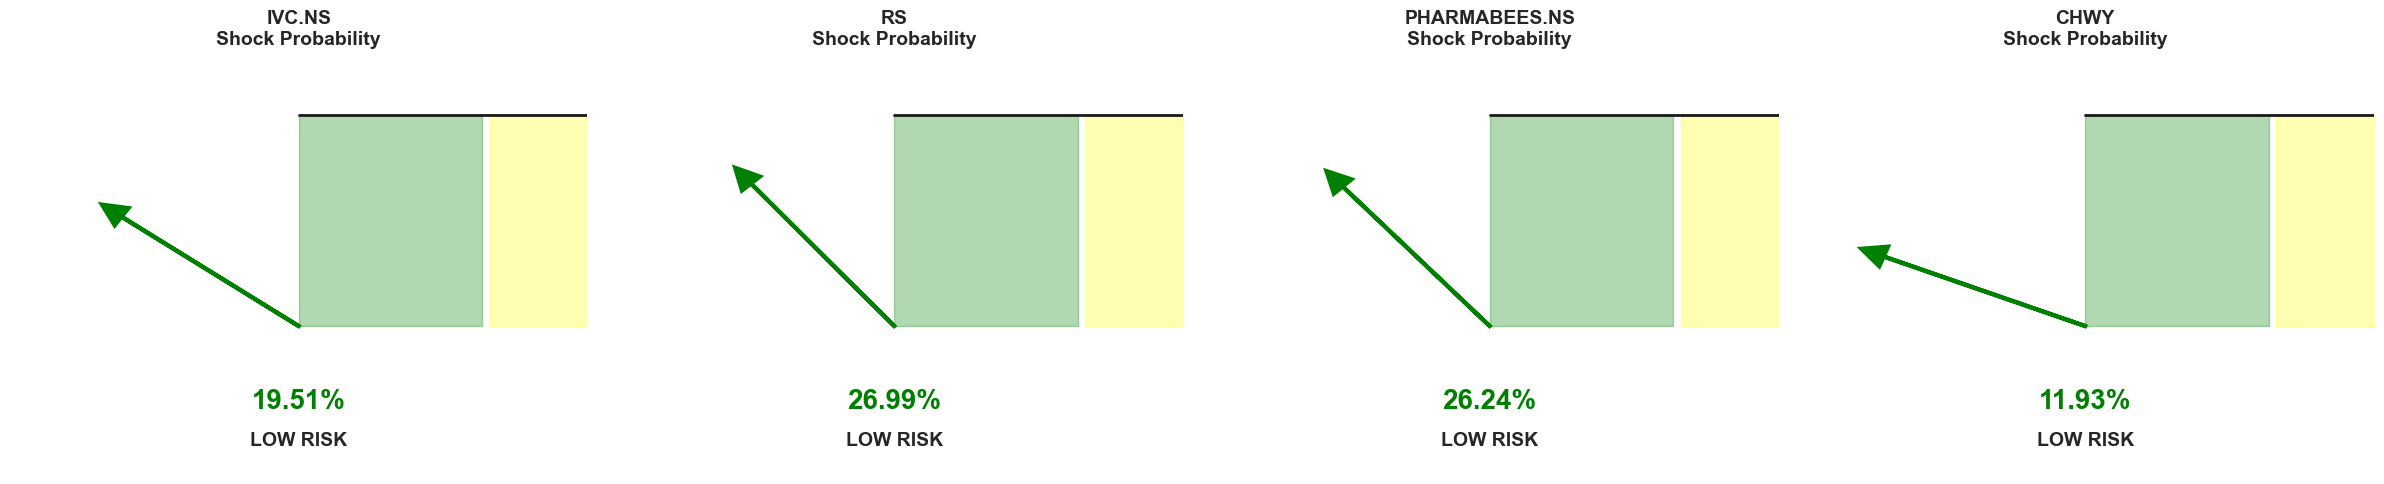

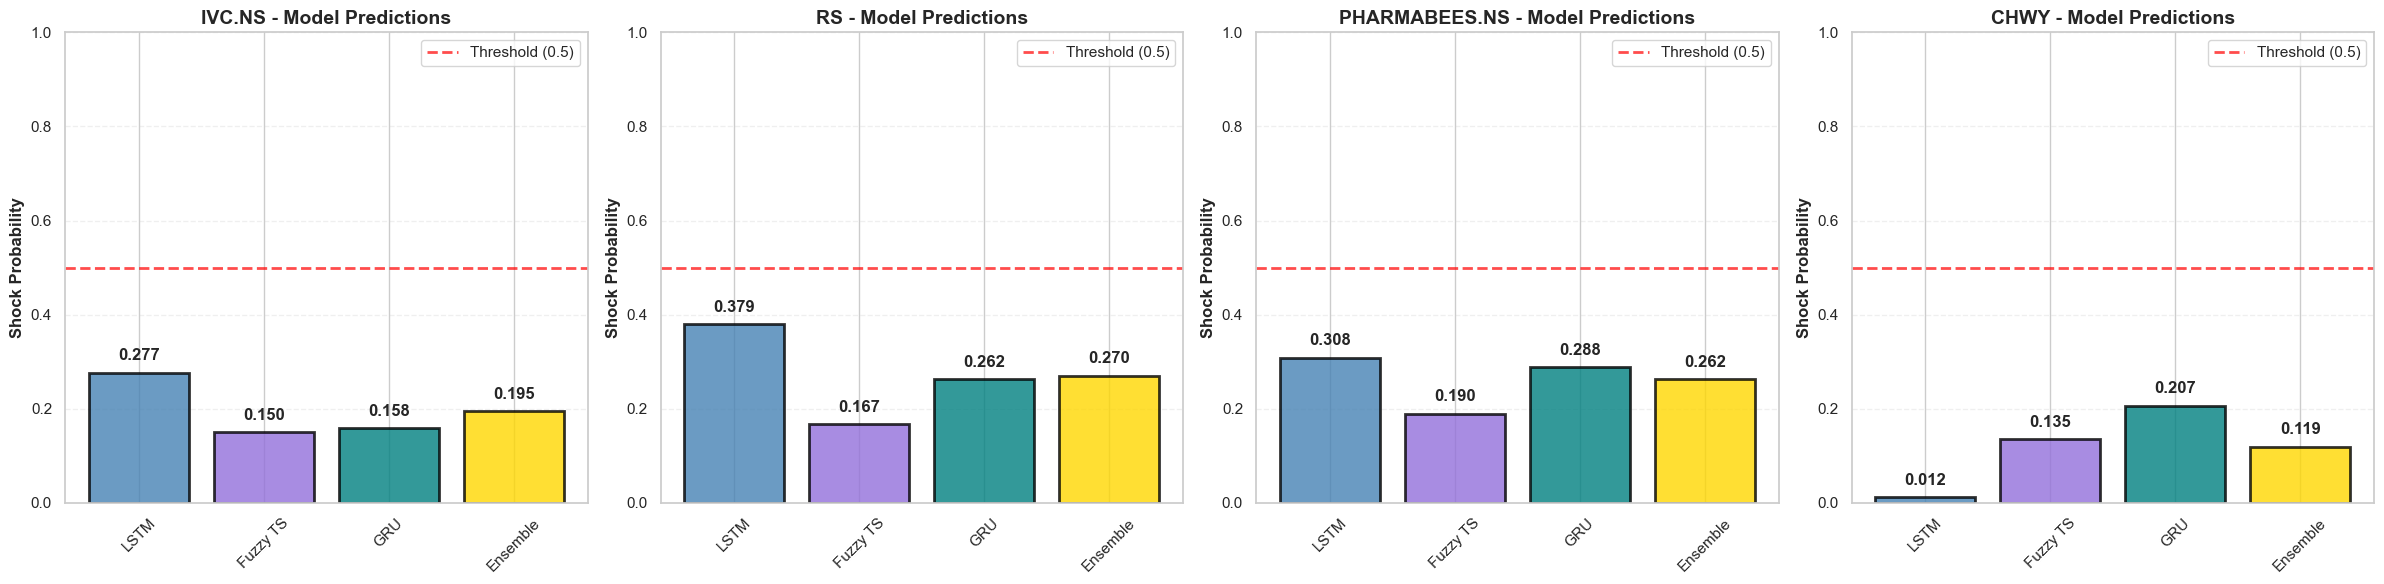


LIQUIDITY SHOCK RISK DASHBOARD


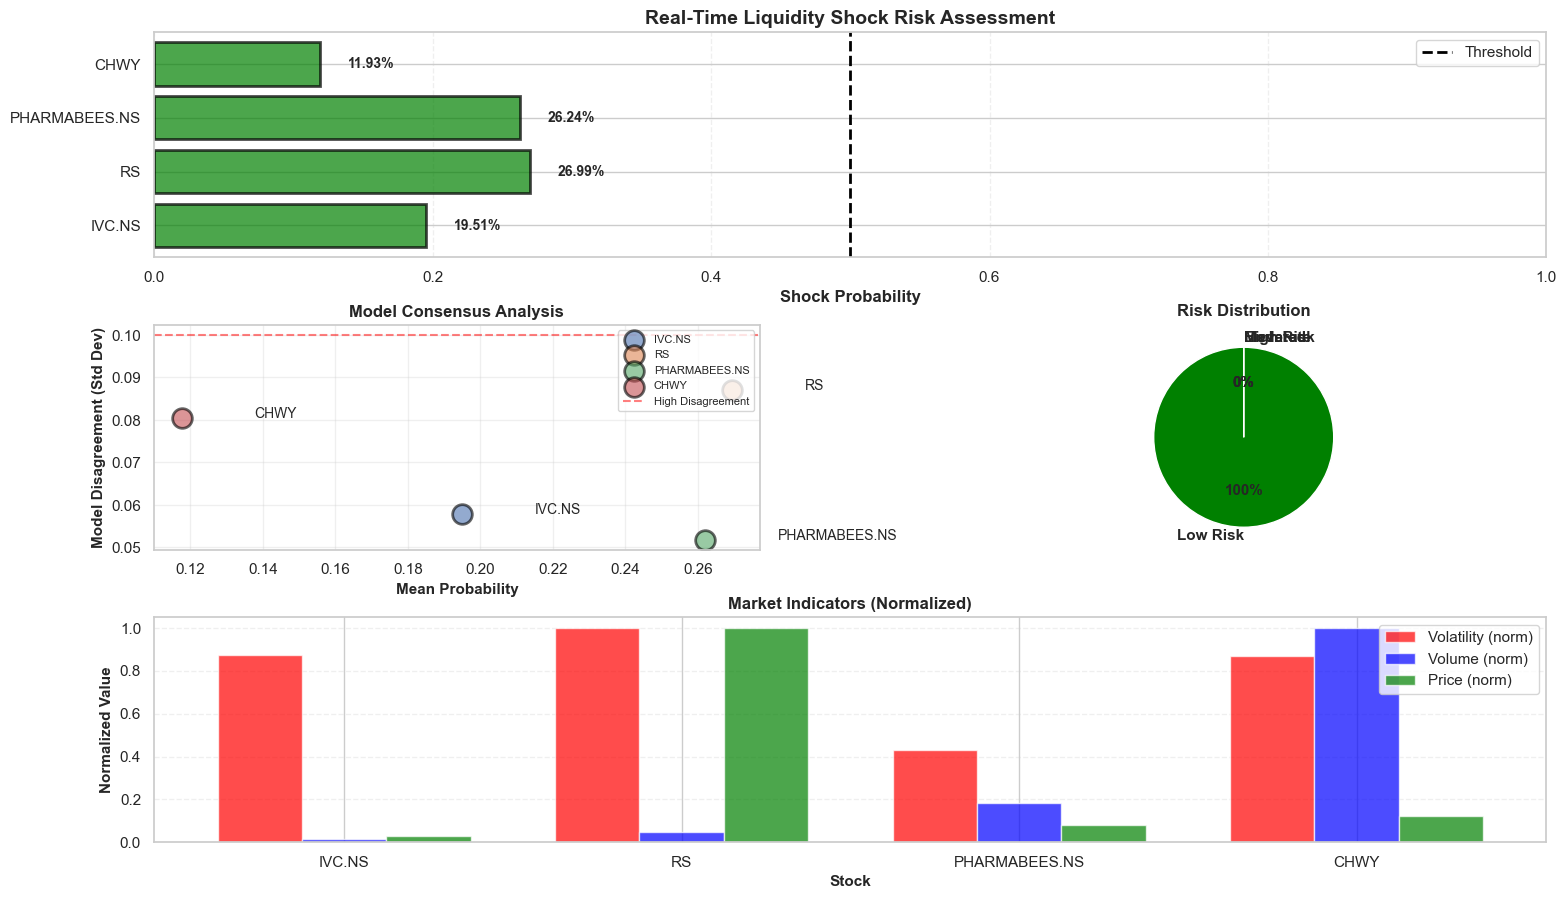


DETAILED RISK REPORT

IVC.NS:
  Date: 2025-10-28
  Close Price: $7.72
  Volatility: 0.010980
  Volume: 96,659
  Model Predictions:
    - LSTM: 0.2767
    - Fuzzy TS: 0.1500
    - GRU: 0.1581
  Ensemble: 0.1951 (19.51%)
  Status: NORMAL
  Model Agreement: 94.21%
  Confidence: HIGH

RS:
  Date: 2025-10-27
  Close Price: $278.73
  Volatility: 0.012582
  Volume: 305,600
  Model Predictions:
    - LSTM: 0.3794
    - Fuzzy TS: 0.1667
    - GRU: 0.2622
  Ensemble: 0.2699 (26.99%)
  Status: NORMAL
  Model Agreement: 91.30%
  Confidence: MODERATE

PHARMABEES.NS:
  Date: 2025-10-28
  Close Price: $22.73
  Volatility: 0.005424
  Volume: 1,192,944
  Model Predictions:
    - LSTM: 0.3081
    - Fuzzy TS: 0.1895
    - GRU: 0.2884
  Ensemble: 0.2624 (26.24%)
  Status: NORMAL
  Model Agreement: 94.81%
  Confidence: MODERATE

CHWY:
  Date: 2025-10-27
  Close Price: $34.61
  Volatility: 0.010929
  Volume: 6,571,000
  Model Predictions:
    - LSTM: 0.0118
    - Fuzzy TS: 0.1346
    - GRU: 0.2065
  Ensemb

In [ ]:
# Visualize Real-Time Predictions
print("="*80)
print("REAL-TIME PREDICTION VISUALIZATIONS")
print("="*80)

if realtime_predictions:
    # Visualization 1: Shock Probability Gauge Chart
    plt.figure(figsize=(6*len(realtime_predictions), 5))
    fig, axes = plt.subplots(1, len(realtime_predictions), figsize=(6*len(realtime_predictions), 5))
    
    if len(realtime_predictions) == 1:
        axes = [axes]
    
    for i, pred in enumerate(realtime_predictions):
        ax = axes[i]
        
        # Create gauge chart
        prob = pred['ensemble_proba']
        
        # Color based on probability
        if prob < 0.3:
            color = 'green'
            status = 'LOW RISK'
        elif prob < 0.5:
            color = 'yellowgreen'
            status = 'MODERATE'
        elif prob < 0.7:
            color = 'orange'
            status = 'ELEVATED'
        else:
            color = 'red'
            status = 'HIGH RISK'
        
        # Draw gauge
        theta = np.linspace(0, np.pi, 100)
        r = np.ones(100)
        
        # Background
        ax.plot(theta, r, 'k-', linewidth=2)
        ax.fill_between(theta[:25], 0, r[:25], color='green', alpha=0.3, label='Low')
        ax.fill_between(theta[25:50], 0, r[25:50], color='yellow', alpha=0.3, label='Moderate')
        ax.fill_between(theta[50:75], 0, r[50:75], color='orange', alpha=0.3, label='Elevated')
        ax.fill_between(theta[75:], 0, r[75:], color='red', alpha=0.3, label='High')
        
        # Needle
        needle_angle = np.pi * (1 - prob)
        ax.arrow(0, 0, np.cos(needle_angle)*0.9, np.sin(needle_angle)*0.9,
                head_width=0.1, head_length=0.1, fc=color, ec=color, linewidth=3)
        
        # Labels
        ax.text(0, -0.3, f'{prob:.2%}', ha='center', va='top', 
               fontsize=20, fontweight='bold', color=color)
        ax.text(0, -0.5, status, ha='center', va='top',
               fontsize=14, fontweight='bold')
        
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-0.7, 1.2)
        ax.axis('off')
        ax.set_title(f'{pred["ticker"]}\nShock Probability', 
                    fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Visualization 2: Model Contributions Bar Chart
    fig, axes = plt.subplots(1, len(realtime_predictions), figsize=(6*len(realtime_predictions), 6))
    
    if len(realtime_predictions) == 1:
        axes = [axes]
    
    for i, pred in enumerate(realtime_predictions):
        ax = axes[i]
        
        models = ['LSTM', 'Fuzzy TS', 'GRU', 'Ensemble']
        probas = [pred['lstm_proba'], pred['fuzzy_proba'], 
                 pred['gru_proba'], pred['ensemble_proba']]
        colors_bar = ['steelblue', 'mediumpurple', 'teal', 'gold']
        
        bars = ax.bar(models, probas, color=colors_bar, alpha=0.8, 
                     edgecolor='black', linewidth=2)
        
        # Add value labels
        for bar, prob in zip(bars, probas):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                   f'{prob:.3f}', ha='center', va='bottom', 
                   fontsize=12, fontweight='bold')
        
        # Add threshold line
        ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
                  label='Threshold (0.5)', alpha=0.7)
        
        ax.set_ylabel('Shock Probability', fontsize=12, fontweight='bold')
        ax.set_title(f'{pred["ticker"]} - Model Predictions', 
                    fontsize=14, fontweight='bold')
        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.legend(loc='upper right')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Visualization 3: Risk Dashboard
    print(f"\n{'='*80}")
    print("LIQUIDITY SHOCK RISK DASHBOARD")
    print("="*80)
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Probability Distribution
    ax1 = fig.add_subplot(gs[0, :])
    tickers = [p['ticker'] for p in realtime_predictions]
    probas = [p['ensemble_proba'] for p in realtime_predictions]
    colors_risk = ['red' if p > 0.5 else 'green' for p in probas]
    
    bars = ax1.barh(tickers, probas, color=colors_risk, alpha=0.7, edgecolor='black', linewidth=2)
    ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
    ax1.set_xlabel('Shock Probability', fontsize=12, fontweight='bold')
    ax1.set_title('Real-Time Liquidity Shock Risk Assessment', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 1.0)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.legend()
    
    # Add value labels
    for bar, prob in zip(bars, probas):
        width = bar.get_width()
        ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f'{prob:.2%}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    # Plot 2: Model Agreement
    ax2 = fig.add_subplot(gs[1, 0])
    
    for pred in realtime_predictions:
        model_probs = [pred['lstm_proba'], pred['fuzzy_proba'], pred['gru_proba']]
        std_dev = np.std(model_probs)
        mean_prob = np.mean(model_probs)
        
        ax2.scatter(mean_prob, std_dev, s=200, alpha=0.6, 
                   label=pred['ticker'], edgecolors='black', linewidth=2)
        ax2.text(mean_prob + 0.02, std_dev, pred['ticker'], fontsize=10)
    
    ax2.set_xlabel('Mean Probability', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Model Disagreement (Std Dev)', fontsize=11, fontweight='bold')
    ax2.set_title('Model Consensus Analysis', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High Disagreement')
    ax2.legend(loc='upper right', fontsize=8)
    
    # Plot 3: Risk Classification
    ax3 = fig.add_subplot(gs[1, 1])
    
    risk_categories = {'Low Risk': 0, 'Moderate': 0, 'Elevated': 0, 'High Risk': 0}
    for pred in realtime_predictions:
        prob = pred['ensemble_proba']
        if prob < 0.3:
            risk_categories['Low Risk'] += 1
        elif prob < 0.5:
            risk_categories['Moderate'] += 1
        elif prob < 0.7:
            risk_categories['Elevated'] += 1
        else:
            risk_categories['High Risk'] += 1
    
    colors_pie = ['green', 'yellowgreen', 'orange', 'red']
    wedges, texts, autotexts = ax3.pie(risk_categories.values(), labels=risk_categories.keys(),
                                        colors=colors_pie, autopct='%1.0f%%', startangle=90,
                                        textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax3.set_title('Risk Distribution', fontsize=12, fontweight='bold')
    
    # Plot 4: Recent Market Indicators
    ax4 = fig.add_subplot(gs[2, :])
    
    x = np.arange(len(realtime_predictions))
    width = 0.25
    
    volatilities = [p['volatility'] for p in realtime_predictions]
    volumes = [p['volume'] / 1e6 for p in realtime_predictions]  # In millions
    prices = [p['close_price'] for p in realtime_predictions]
    
    # Normalize for visualization
    vol_norm = [v / max(volatilities) if max(volatilities) > 0 else 0 for v in volatilities]
    vol_volumes = [v / max(volumes) if max(volumes) > 0 else 0 for v in volumes]
    price_norm = [p / max(prices) if max(prices) > 0 else 0 for p in prices]
    
    ax4.bar(x - width, vol_norm, width, label='Volatility (norm)', color='red', alpha=0.7)
    ax4.bar(x, vol_volumes, width, label='Volume (norm)', color='blue', alpha=0.7)
    ax4.bar(x + width, price_norm, width, label='Price (norm)', color='green', alpha=0.7)
    
    ax4.set_xlabel('Stock', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Normalized Value', fontsize=11, fontweight='bold')
    ax4.set_title('Market Indicators (Normalized)', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(tickers)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Print detailed report
    print(f"\n{'='*80}")
    print("DETAILED RISK REPORT")
    print("="*80)
    
    for pred in realtime_predictions:
        print(f"\n{pred['ticker']}:")
        print(f"  Date: {pred['date'].strftime('%Y-%m-%d')}")
        print(f"  Close Price: ${pred['close_price']:.2f}")
        print(f"  Volatility: {pred['volatility']:.6f}")
        print(f"  Volume: {pred['volume']:,.0f}")
        print(f"  Model Predictions:")
        print(f"    - LSTM: {pred['lstm_proba']:.4f}")
        print(f"    - Fuzzy TS: {pred['fuzzy_proba']:.4f}")
        print(f"    - GRU: {pred['gru_proba']:.4f}")
        print(f"  Ensemble: {pred['ensemble_proba']:.4f} ({pred['ensemble_proba']*100:.2f}%)")
        print(f"  Status: {pred['prediction']}")
        
        # Model agreement
        model_probs = [pred['lstm_proba'], pred['fuzzy_proba'], pred['gru_proba']]
        agreement = 1 - np.std(model_probs)
        print(f"  Model Agreement: {agreement:.2%}")
        print(f"  Confidence: {'HIGH' if abs(pred['ensemble_proba'] - 0.5) > 0.3 else 'MODERATE' if abs(pred['ensemble_proba'] - 0.5) > 0.15 else 'LOW'}")
    
    print(f"\n{'='*80}")
    print("[SUCCESS] Real-time visualization completed!")
    print("="*80)
    
else:
    print("[WARNING] No real-time predictions available for visualization.")